In [ ]:
!pip install optuna

     |████████████████████████████████| 296kB 6.0MB/s 
     |████████████████████████████████| 81kB 5.2MB/s 
     |████████████████████████████████| 163kB 7.8MB/s 
     |████████████████████████████████| 112kB 10.6MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 143kB 8.9MB/s 
     |████████████████████████████████| 81kB 6.2MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=00ee67050950c47e0d76114edb0078e1582006a920c8a4da77a9defe89feac2d
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [ ]:
from glob import glob
from keras import optimizers
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, models
import cv2
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import optuna
import os

In [ ]:
path = glob("ohhara/*/")
data = []
label = [] 
total = 0
x = 32
y = 18

def append_data(directory, total):
  files = os.listdir(directory)
  print(files)
  for image in files:
    if image.endswith(".jpg"):
      image = cv2.imread(directory + image)
      image = cv2.resize(image, (x, y))
      image_gs = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      image_gs = image_gs.flatten()
      data.append(image_gs)
      label.append(total)

for i in path:
    append_data(i, total)
    total += 1

['kyogoku_008.jpg', 'kyogoku_009.jpg', 'kyogoku_010.jpg', 'kyogoku_011.jpg', 'kaibara_137.jpg', 'kaibara_138.jpg', 'kaibara_139.jpg', 'kyogoku_012.jpg', 'kyogoku_014.jpg', 'kyogoku_015.jpg', 'kyogoku_016.jpg', 'kyogoku_017.jpg', 'kaibara_140.jpg', 'kaibara_141.jpg', 'kyogoku_018.jpg', 'kyogoku_019.jpg', 'kyogoku_020.jpg', 'kyogoku_021.jpg', 'kyogoku_022.jpg', 'kyogoku_023.jpg', 'kaibara_142.jpg', 'kyogoku_025.jpg', 'kyogoku_026.jpg', 'kyogoku_027.jpg', 'kyogoku_028.jpg', 'kaibara_143.jpg', 'kaibara_144.jpg', 'kaibara_145.jpg', 'kyogoku_029.jpg', 'kurita_160.jpg', 'kyogoku_030.jpg', 'tomii_156.jpg', 'tanimura_050.jpg', 'tanimura_052.jpg', 'kurita_162.jpg', 'kaibara_146.jpg', 'kaibara_147.jpg', 'kaibara_148.jpg', 'kaibara_149.jpg', 'kaibara_150.jpg', 'kaibara_151.jpg', 'kaibara_152.jpg', 'kaibara_153.jpg', 'kaibara_154.jpg', 'kaibara_155.jpg', 'kaibara_156.jpg', 'kaibara_157.jpg', 'kaibara_158.jpg', 'kaibara_159.jpg', 'kaibara_160.jpg', 'kaibara_161.jpg', 'kaibara_162.jpg', 'kaibara_163.

In [ ]:
data = np.array(data, dtype=np.float64)
label = np.array(label, dtype=np.float64)

train_data, test_data, train_label, test_label = train_test_split(data, label, random_state=1, stratify=label, test_size=0.1)

train_data = train_data.reshape((len(train_data)), x, y, 1)
test_data = test_data.reshape((len(test_data)), x, y, 1)

train_data /= 255
test_data /= 255

train_label = to_categorical(train_label, num_classes=2)
test_label = to_categorical(test_label, num_classes=2)
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(1152, 32, 18, 1)
(1152, 2)
(129, 32, 18, 1)
(129, 2)


In [ ]:
model_list = []
result_list = []

def create_model(layer, filter_size, filters, activation, dropout_rate):
  model = model = models.Sequential()
  model.add(layers.Conv2D(16, (filter_size, filter_size), activation="relu", padding="same", input_shape=(x, y, 1)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2), strides=(1, 1)))
  model.add(layers.Flatten())
  for i in range(layer):
    model.add(layers.Dense(filters, activation=activation))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(rate=dropout_rate))
  model.add(layers.Dense(2, activation="softmax"))
  return model

def optimisation(choice):
  K.clear_session()
  layer = choice.suggest_int("layer", 1, 8)
  filter_size = choice.suggest_int("filter_size", 3, 7, 2)
  filters = choice.suggest_int("filters", 32, 256, 32)
  optimizer = choice.suggest_categorical("optimizer", ["SGD", "RMSprop", "Adagrad", "Adadelta", "Adam", "Adamax", "Nadam"])
  activation = choice.suggest_categorical("activation", ["softmax", "elu", "selu", "softplus", "softsign", "relu", "tanh", "sigmoid", "hard_sigmoid", "linear"])
  dropout_rate = choice.suggest_uniform("dropout_rate", 0.25, 0.5)
  model = create_model(layer, filter_size, filters, activation, dropout_rate)
  model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  result = model.fit(train_data, train_label, batch_size=batchsize, epochs=epoch, verbose=2, validation_data=(test_data, test_label))
  model_list.append(model)
  result_list.append(result)
  return 1 - result.history["val_accuracy"][-1]

In [ ]:
batchsize = train_data.shape[0] // 64
print(batchsize)
epoch = 16
study = optuna.create_study()
study.optimize(optimisation, n_trials=256)

[I 2021-03-17 06:54:00,051] A new study created in memory with name: no-name-fe3d68a3-d7ff-42d2-80d2-66c8150307cb


18
Epoch 1/16
64/64 - 32s - loss: 0.9277 - accuracy: 0.5842 - val_loss: 0.5202 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7036 - accuracy: 0.6858 - val_loss: 0.4622 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5999 - accuracy: 0.7248 - val_loss: 0.5358 - val_accuracy: 0.8837
Epoch 4/16
64/64 - 0s - loss: 0.4525 - accuracy: 0.8082 - val_loss: 0.6557 - val_accuracy: 0.6202
Epoch 5/16
64/64 - 0s - loss: 0.4184 - accuracy: 0.8247 - val_loss: 0.5396 - val_accuracy: 0.7907
Epoch 6/16
64/64 - 0s - loss: 0.3542 - accuracy: 0.8585 - val_loss: 0.3645 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.3143 - accuracy: 0.8698 - val_loss: 0.3473 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.3113 - accuracy: 0.8776 - val_loss: 0.3424 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.2874 - accuracy: 0.8924 - val_loss: 0.2863 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2851 - accuracy: 0.8811 - val_loss: 0.3207 - val_accuracy: 0.9070
Epoch 11/16
64/

[I 2021-03-17 06:54:41,638] Trial 0 finished with value: 0.10852712392807007 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.35570190861850604}. Best is trial 0 with value: 0.10852712392807007.


Epoch 1/16
64/64 - 6s - loss: 1.0028 - accuracy: 0.5790 - val_loss: 0.5935 - val_accuracy: 0.7984
Epoch 2/16
64/64 - 1s - loss: 0.7048 - accuracy: 0.6997 - val_loss: 0.5052 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.6168 - accuracy: 0.7405 - val_loss: 0.4967 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.5660 - accuracy: 0.7656 - val_loss: 0.6829 - val_accuracy: 0.5426
Epoch 5/16
64/64 - 1s - loss: 0.5444 - accuracy: 0.7760 - val_loss: 0.7115 - val_accuracy: 0.4031
Epoch 6/16
64/64 - 1s - loss: 0.5214 - accuracy: 0.7882 - val_loss: 0.4631 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 1s - loss: 0.5187 - accuracy: 0.7795 - val_loss: 0.6061 - val_accuracy: 0.6822
Epoch 8/16
64/64 - 1s - loss: 0.4691 - accuracy: 0.8003 - val_loss: 0.6294 - val_accuracy: 0.5969
Epoch 9/16
64/64 - 1s - loss: 0.4608 - accuracy: 0.8082 - val_loss: 0.4002 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 1s - loss: 0.4292 - accuracy: 0.8212 - val_loss: 0.3919 - val_accuracy: 0.8295
Epoch 11/16
64/64 -

[I 2021-03-17 06:54:58,238] Trial 1 finished with value: 0.356589138507843 and parameters: {'layer': 8, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.48948070701804364}. Best is trial 0 with value: 0.10852712392807007.


Epoch 1/16
64/64 - 1s - loss: 0.8365 - accuracy: 0.6241 - val_loss: 0.4338 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6181 - accuracy: 0.7075 - val_loss: 0.4426 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5206 - accuracy: 0.7682 - val_loss: 0.4791 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.4921 - accuracy: 0.7899 - val_loss: 0.3890 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4725 - accuracy: 0.8021 - val_loss: 0.4013 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4563 - accuracy: 0.8125 - val_loss: 0.3980 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.4476 - accuracy: 0.8125 - val_loss: 0.4276 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.4587 - accuracy: 0.8151 - val_loss: 0.4016 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4157 - accuracy: 0.8238 - val_loss: 0.3993 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.4142 - accuracy: 0.8325 - val_loss: 0.3863 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 06:55:04,050] Trial 2 finished with value: 0.1860465407371521 and parameters: {'layer': 3, 'filter_size': 7, 'filters': 160, 'optimizer': 'SGD', 'activation': 'tanh', 'dropout_rate': 0.2662625823107798}. Best is trial 0 with value: 0.10852712392807007.


Epoch 1/16
64/64 - 4s - loss: 1.0185 - accuracy: 0.5712 - val_loss: 0.5564 - val_accuracy: 0.7674
Epoch 2/16
64/64 - 1s - loss: 0.6972 - accuracy: 0.6988 - val_loss: 0.8753 - val_accuracy: 0.2248
Epoch 3/16
64/64 - 1s - loss: 0.6228 - accuracy: 0.7569 - val_loss: 0.4187 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.5679 - accuracy: 0.7717 - val_loss: 0.4232 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.5640 - accuracy: 0.7630 - val_loss: 0.4250 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.5150 - accuracy: 0.8012 - val_loss: 0.4794 - val_accuracy: 0.7597
Epoch 7/16
64/64 - 1s - loss: 0.4756 - accuracy: 0.8056 - val_loss: 0.4222 - val_accuracy: 0.8217
Epoch 8/16
64/64 - 1s - loss: 0.4430 - accuracy: 0.8099 - val_loss: 0.4914 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 1s - loss: 0.4406 - accuracy: 0.8151 - val_loss: 0.4208 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 1s - loss: 0.4082 - accuracy: 0.8177 - val_loss: 0.3304 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 06:55:17,403] Trial 3 finished with value: 0.20930230617523193 and parameters: {'layer': 6, 'filter_size': 5, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.47635092903768356}. Best is trial 0 with value: 0.10852712392807007.


Epoch 1/16
64/64 - 2s - loss: 1.1006 - accuracy: 0.5035 - val_loss: 0.5105 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 1.0249 - accuracy: 0.5148 - val_loss: 0.5451 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 1.0045 - accuracy: 0.5269 - val_loss: 0.5689 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 1.0606 - accuracy: 0.5095 - val_loss: 0.5731 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 1.0062 - accuracy: 0.5200 - val_loss: 0.5662 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 1.0644 - accuracy: 0.5035 - val_loss: 0.5472 - val_accuracy: 0.8295
Epoch 7/16
64/64 - 0s - loss: 0.9943 - accuracy: 0.5321 - val_loss: 0.5214 - val_accuracy: 0.8062
Epoch 8/16
64/64 - 0s - loss: 0.9895 - accuracy: 0.5278 - val_loss: 0.5217 - val_accuracy: 0.7752
Epoch 9/16
64/64 - 0s - loss: 1.0118 - accuracy: 0.5217 - val_loss: 0.5461 - val_accuracy: 0.7519
Epoch 10/16
64/64 - 0s - loss: 1.0204 - accuracy: 0.5373 - val_loss: 0.5617 - val_accuracy: 0.7597
Epoch 11/16
64/64 -

[I 2021-03-17 06:55:24,973] Trial 4 finished with value: 0.30232560634613037 and parameters: {'layer': 4, 'filter_size': 7, 'filters': 256, 'optimizer': 'Adadelta', 'activation': 'hard_sigmoid', 'dropout_rate': 0.2524998256285231}. Best is trial 0 with value: 0.10852712392807007.


Epoch 1/16
64/64 - 1s - loss: 0.9086 - accuracy: 0.6233 - val_loss: 0.5484 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5540 - accuracy: 0.7448 - val_loss: 0.5412 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4638 - accuracy: 0.8116 - val_loss: 0.5292 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.3890 - accuracy: 0.8229 - val_loss: 0.5639 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.3530 - accuracy: 0.8576 - val_loss: 0.5199 - val_accuracy: 0.8140
Epoch 6/16
64/64 - 0s - loss: 0.3075 - accuracy: 0.8828 - val_loss: 0.5144 - val_accuracy: 0.7984
Epoch 7/16
64/64 - 0s - loss: 0.2647 - accuracy: 0.9002 - val_loss: 0.6306 - val_accuracy: 0.6202
Epoch 8/16
64/64 - 0s - loss: 0.2551 - accuracy: 0.9010 - val_loss: 0.3154 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2181 - accuracy: 0.9193 - val_loss: 0.5719 - val_accuracy: 0.6822
Epoch 10/16
64/64 - 0s - loss: 0.2082 - accuracy: 0.9193 - val_loss: 0.3363 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:55:29,815] Trial 5 finished with value: 0.13953489065170288 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.33726258788673846}. Best is trial 0 with value: 0.10852712392807007.


Epoch 1/16
64/64 - 4s - loss: 0.9433 - accuracy: 0.6024 - val_loss: 0.4413 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.6166 - accuracy: 0.7431 - val_loss: 0.4372 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.5983 - accuracy: 0.7587 - val_loss: 0.4358 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.5731 - accuracy: 0.7812 - val_loss: 0.4460 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.5568 - accuracy: 0.7969 - val_loss: 0.4479 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.5211 - accuracy: 0.8108 - val_loss: 0.4559 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 1s - loss: 0.4916 - accuracy: 0.8099 - val_loss: 0.4297 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 1s - loss: 0.4850 - accuracy: 0.8090 - val_loss: 0.4800 - val_accuracy: 0.8295
Epoch 9/16
64/64 - 1s - loss: 0.4713 - accuracy: 0.8238 - val_loss: 0.5426 - val_accuracy: 0.8372
Epoch 10/16
64/64 - 1s - loss: 0.4619 - accuracy: 0.8238 - val_loss: 0.4708 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:55:42,470] Trial 6 finished with value: 0.1550387740135193 and parameters: {'layer': 8, 'filter_size': 3, 'filters': 256, 'optimizer': 'RMSprop', 'activation': 'sigmoid', 'dropout_rate': 0.39789040408299103}. Best is trial 0 with value: 0.10852712392807007.


Epoch 1/16
64/64 - 1s - loss: 0.4875 - accuracy: 0.8238 - val_loss: 0.4311 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4361 - accuracy: 0.8438 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4365 - accuracy: 0.8438 - val_loss: 0.4311 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4371 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4348 - accuracy: 0.8438 - val_loss: 0.4322 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4378 - accuracy: 0.8438 - val_loss: 0.4331 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4348 - accuracy: 0.8438 - val_loss: 0.4343 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4371 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4368 - accuracy: 0.8438 - val_loss: 0.4323 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4340 - accuracy: 0.8438 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:55:48,164] Trial 7 finished with value: 0.1550387740135193 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'softmax', 'dropout_rate': 0.4170899565621668}. Best is trial 0 with value: 0.10852712392807007.


Epoch 1/16
64/64 - 4s - loss: 0.8979 - accuracy: 0.5773 - val_loss: 0.5841 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6703 - accuracy: 0.6736 - val_loss: 0.4973 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5723 - accuracy: 0.7457 - val_loss: 0.4322 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.5278 - accuracy: 0.7856 - val_loss: 0.4279 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.5310 - accuracy: 0.8090 - val_loss: 0.4288 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.5039 - accuracy: 0.8168 - val_loss: 0.4607 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 1s - loss: 0.5064 - accuracy: 0.8047 - val_loss: 0.4459 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 1s - loss: 0.4909 - accuracy: 0.8125 - val_loss: 0.4216 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 1s - loss: 0.4842 - accuracy: 0.8281 - val_loss: 0.4249 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 1s - loss: 0.4813 - accuracy: 0.8299 - val_loss: 0.4388 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:56:00,104] Trial 8 finished with value: 0.1550387740135193 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 96, 'optimizer': 'Nadam', 'activation': 'tanh', 'dropout_rate': 0.3648853622725606}. Best is trial 0 with value: 0.10852712392807007.


Epoch 1/16
64/64 - 3s - loss: 1.0873 - accuracy: 0.5556 - val_loss: 0.5442 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7070 - accuracy: 0.6753 - val_loss: 0.4425 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6222 - accuracy: 0.7483 - val_loss: 0.4292 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5829 - accuracy: 0.7726 - val_loss: 0.4250 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5488 - accuracy: 0.7960 - val_loss: 0.4259 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5385 - accuracy: 0.7865 - val_loss: 0.4267 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5315 - accuracy: 0.8012 - val_loss: 0.4224 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5169 - accuracy: 0.7986 - val_loss: 0.4207 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4734 - accuracy: 0.8099 - val_loss: 0.4056 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4617 - accuracy: 0.8064 - val_loss: 0.3920 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:56:09,876] Trial 9 finished with value: 0.1550387740135193 and parameters: {'layer': 8, 'filter_size': 7, 'filters': 96, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.4437618398103069}. Best is trial 0 with value: 0.10852712392807007.


Epoch 1/16
64/64 - 1s - loss: 0.9115 - accuracy: 0.5547 - val_loss: 1.1059 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.7745 - accuracy: 0.6111 - val_loss: 0.9525 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 0.7488 - accuracy: 0.6207 - val_loss: 1.4220 - val_accuracy: 0.1550
Epoch 4/16
64/64 - 0s - loss: 0.7247 - accuracy: 0.6484 - val_loss: 1.8136 - val_accuracy: 0.1550
Epoch 5/16
64/64 - 0s - loss: 0.6370 - accuracy: 0.6953 - val_loss: 1.5406 - val_accuracy: 0.1628
Epoch 6/16
64/64 - 0s - loss: 0.6376 - accuracy: 0.6832 - val_loss: 1.9002 - val_accuracy: 0.1783
Epoch 7/16
64/64 - 0s - loss: 0.5907 - accuracy: 0.7196 - val_loss: 1.2421 - val_accuracy: 0.2558
Epoch 8/16
64/64 - 0s - loss: 0.5888 - accuracy: 0.7205 - val_loss: 0.8549 - val_accuracy: 0.5116
Epoch 9/16
64/64 - 0s - loss: 0.5768 - accuracy: 0.7378 - val_loss: 0.6529 - val_accuracy: 0.6589
Epoch 10/16
64/64 - 0s - loss: 0.5537 - accuracy: 0.7569 - val_loss: 0.5976 - val_accuracy: 0.6744
Epoch 11/16
64/64 -

[I 2021-03-17 06:56:15,287] Trial 10 finished with value: 0.12403100728988647 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adagrad', 'activation': 'selu', 'dropout_rate': 0.2969627327353549}. Best is trial 0 with value: 0.10852712392807007.


Epoch 1/16
64/64 - 1s - loss: 1.0104 - accuracy: 0.5469 - val_loss: 0.7341 - val_accuracy: 0.3566
Epoch 2/16
64/64 - 0s - loss: 0.8152 - accuracy: 0.6102 - val_loss: 1.0583 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 0.8483 - accuracy: 0.5946 - val_loss: 1.0212 - val_accuracy: 0.1550
Epoch 4/16
64/64 - 0s - loss: 0.7865 - accuracy: 0.6406 - val_loss: 1.0377 - val_accuracy: 0.1860
Epoch 5/16
64/64 - 0s - loss: 0.7972 - accuracy: 0.6398 - val_loss: 0.6806 - val_accuracy: 0.6124
Epoch 6/16
64/64 - 0s - loss: 0.7510 - accuracy: 0.6606 - val_loss: 0.7584 - val_accuracy: 0.4651
Epoch 7/16
64/64 - 0s - loss: 0.7136 - accuracy: 0.6727 - val_loss: 0.9785 - val_accuracy: 0.2946
Epoch 8/16
64/64 - 0s - loss: 0.6578 - accuracy: 0.6866 - val_loss: 0.6955 - val_accuracy: 0.5814
Epoch 9/16
64/64 - 0s - loss: 0.6855 - accuracy: 0.6814 - val_loss: 0.5894 - val_accuracy: 0.6977
Epoch 10/16
64/64 - 0s - loss: 0.6273 - accuracy: 0.7083 - val_loss: 0.5905 - val_accuracy: 0.7054
Epoch 11/16
64/64 -

[I 2021-03-17 06:56:20,682] Trial 11 finished with value: 0.13178294897079468 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adagrad', 'activation': 'selu', 'dropout_rate': 0.31318312821375477}. Best is trial 0 with value: 0.10852712392807007.


Epoch 1/16
64/64 - 2s - loss: 1.0577 - accuracy: 0.5295 - val_loss: 0.7484 - val_accuracy: 0.4341
Epoch 2/16
64/64 - 0s - loss: 0.9150 - accuracy: 0.5703 - val_loss: 1.1107 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 0.7830 - accuracy: 0.6224 - val_loss: 1.3404 - val_accuracy: 0.1550
Epoch 4/16
64/64 - 0s - loss: 0.8110 - accuracy: 0.5955 - val_loss: 1.4266 - val_accuracy: 0.1550
Epoch 5/16
64/64 - 0s - loss: 0.7510 - accuracy: 0.6380 - val_loss: 1.2091 - val_accuracy: 0.1783
Epoch 6/16
64/64 - 0s - loss: 0.7262 - accuracy: 0.6415 - val_loss: 1.3113 - val_accuracy: 0.1783
Epoch 7/16
64/64 - 0s - loss: 0.6945 - accuracy: 0.6476 - val_loss: 0.7862 - val_accuracy: 0.4496
Epoch 8/16
64/64 - 0s - loss: 0.6920 - accuracy: 0.6667 - val_loss: 0.7315 - val_accuracy: 0.5349
Epoch 9/16
64/64 - 0s - loss: 0.6736 - accuracy: 0.6927 - val_loss: 0.5710 - val_accuracy: 0.6899
Epoch 10/16
64/64 - 0s - loss: 0.6814 - accuracy: 0.6606 - val_loss: 0.6813 - val_accuracy: 0.5891
Epoch 11/16
64/64 -

[I 2021-03-17 06:56:26,813] Trial 12 finished with value: 0.1550387740135193 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adagrad', 'activation': 'selu', 'dropout_rate': 0.2963958858467697}. Best is trial 0 with value: 0.10852712392807007.


Epoch 1/16
64/64 - 1s - loss: 0.8728 - accuracy: 0.5998 - val_loss: 0.5018 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6083 - accuracy: 0.7196 - val_loss: 0.4743 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5632 - accuracy: 0.7439 - val_loss: 0.4337 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4777 - accuracy: 0.8021 - val_loss: 0.4204 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.4041 - accuracy: 0.8307 - val_loss: 0.3994 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3969 - accuracy: 0.8342 - val_loss: 0.3985 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.3923 - accuracy: 0.8316 - val_loss: 0.3430 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2975 - accuracy: 0.8715 - val_loss: 0.2984 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.3014 - accuracy: 0.8759 - val_loss: 0.2720 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2816 - accuracy: 0.8898 - val_loss: 0.2593 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:56:32,418] Trial 13 finished with value: 0.04651165008544922 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.34979309542904846}. Best is trial 13 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9552 - accuracy: 0.5755 - val_loss: 0.7361 - val_accuracy: 0.2248
Epoch 2/16
64/64 - 0s - loss: 0.7355 - accuracy: 0.6554 - val_loss: 0.8978 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 0.5737 - accuracy: 0.7205 - val_loss: 0.8500 - val_accuracy: 0.1628
Epoch 4/16
64/64 - 0s - loss: 0.5457 - accuracy: 0.7595 - val_loss: 0.6834 - val_accuracy: 0.5581
Epoch 5/16
64/64 - 0s - loss: 0.4766 - accuracy: 0.7882 - val_loss: 0.6619 - val_accuracy: 0.6047
Epoch 6/16
64/64 - 0s - loss: 0.4489 - accuracy: 0.8255 - val_loss: 0.6917 - val_accuracy: 0.5194
Epoch 7/16
64/64 - 0s - loss: 0.3973 - accuracy: 0.8299 - val_loss: 0.5651 - val_accuracy: 0.7674
Epoch 8/16
64/64 - 0s - loss: 0.3824 - accuracy: 0.8290 - val_loss: 0.4959 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.3225 - accuracy: 0.8637 - val_loss: 0.4279 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.3415 - accuracy: 0.8481 - val_loss: 0.4374 - val_accuracy: 0.8372
Epoch 11/16
64/64 -

[I 2021-03-17 06:56:37,984] Trial 14 finished with value: 0.10077518224716187 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.359181741016054}. Best is trial 13 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 1.0034 - accuracy: 0.5312 - val_loss: 0.6384 - val_accuracy: 0.8140
Epoch 2/16
64/64 - 0s - loss: 0.7884 - accuracy: 0.6432 - val_loss: 0.5757 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6779 - accuracy: 0.6866 - val_loss: 0.5260 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6256 - accuracy: 0.7318 - val_loss: 0.5015 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5968 - accuracy: 0.7561 - val_loss: 0.4572 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5696 - accuracy: 0.7648 - val_loss: 0.4501 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5250 - accuracy: 0.7804 - val_loss: 0.4184 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5447 - accuracy: 0.7821 - val_loss: 0.4031 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.5237 - accuracy: 0.8047 - val_loss: 0.4074 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.4953 - accuracy: 0.8038 - val_loss: 0.3944 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:56:44,985] Trial 15 finished with value: 0.1550387740135193 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.39143695971154097}. Best is trial 13 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7623 - accuracy: 0.6328 - val_loss: 0.5157 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5450 - accuracy: 0.7561 - val_loss: 0.4342 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4568 - accuracy: 0.8099 - val_loss: 0.4090 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4113 - accuracy: 0.8325 - val_loss: 0.3957 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3436 - accuracy: 0.8568 - val_loss: 0.3779 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.2797 - accuracy: 0.9036 - val_loss: 0.3471 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2669 - accuracy: 0.8976 - val_loss: 0.3675 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.2473 - accuracy: 0.8993 - val_loss: 0.3404 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2135 - accuracy: 0.9149 - val_loss: 0.3679 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2151 - accuracy: 0.9201 - val_loss: 0.4690 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:56:49,978] Trial 16 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.32868315940856785}. Best is trial 13 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 1.0119 - accuracy: 0.5512 - val_loss: 0.5364 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7750 - accuracy: 0.6363 - val_loss: 0.4637 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6305 - accuracy: 0.7066 - val_loss: 0.4973 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5816 - accuracy: 0.7422 - val_loss: 0.4924 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5105 - accuracy: 0.7700 - val_loss: 0.4986 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5105 - accuracy: 0.7700 - val_loss: 0.4191 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4897 - accuracy: 0.7873 - val_loss: 0.4556 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.4527 - accuracy: 0.8142 - val_loss: 0.3715 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.4555 - accuracy: 0.8160 - val_loss: 0.3919 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.4106 - accuracy: 0.8333 - val_loss: 0.3616 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:56:56,291] Trial 17 finished with value: 0.11627906560897827 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.43337135227512746}. Best is trial 13 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 3s - loss: 1.0468 - accuracy: 0.5434 - val_loss: 0.5665 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7782 - accuracy: 0.6033 - val_loss: 0.5127 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6819 - accuracy: 0.6762 - val_loss: 0.4733 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6312 - accuracy: 0.7075 - val_loss: 0.4529 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5904 - accuracy: 0.7292 - val_loss: 0.4410 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5469 - accuracy: 0.7656 - val_loss: 0.4257 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5393 - accuracy: 0.7743 - val_loss: 0.4192 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5309 - accuracy: 0.7830 - val_loss: 0.4142 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4930 - accuracy: 0.8090 - val_loss: 0.4076 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4784 - accuracy: 0.8064 - val_loss: 0.3987 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:57:05,050] Trial 18 finished with value: 0.1550387740135193 and parameters: {'layer': 6, 'filter_size': 7, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.373320261891241}. Best is trial 13 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 1.1239 - accuracy: 0.4983 - val_loss: 0.7375 - val_accuracy: 0.3023
Epoch 2/16
64/64 - 0s - loss: 1.1261 - accuracy: 0.5017 - val_loss: 0.7973 - val_accuracy: 0.2791
Epoch 3/16
64/64 - 0s - loss: 1.0799 - accuracy: 0.5078 - val_loss: 0.8904 - val_accuracy: 0.2558
Epoch 4/16
64/64 - 0s - loss: 1.0877 - accuracy: 0.4878 - val_loss: 0.9137 - val_accuracy: 0.3256
Epoch 5/16
64/64 - 0s - loss: 1.0586 - accuracy: 0.5200 - val_loss: 0.9139 - val_accuracy: 0.4031
Epoch 6/16
64/64 - 0s - loss: 1.0327 - accuracy: 0.5156 - val_loss: 0.9150 - val_accuracy: 0.4264
Epoch 7/16
64/64 - 0s - loss: 1.0186 - accuracy: 0.5434 - val_loss: 0.9072 - val_accuracy: 0.4341
Epoch 8/16
64/64 - 0s - loss: 1.0860 - accuracy: 0.5017 - val_loss: 0.8768 - val_accuracy: 0.5194
Epoch 9/16
64/64 - 0s - loss: 1.0344 - accuracy: 0.5434 - val_loss: 0.8747 - val_accuracy: 0.5194
Epoch 10/16
64/64 - 0s - loss: 0.9953 - accuracy: 0.5391 - val_loss: 0.8546 - val_accuracy: 0.5426
Epoch 11/16
64/64 -

[I 2021-03-17 06:57:10,565] Trial 19 finished with value: 0.4961240291595459 and parameters: {'layer': 2, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adadelta', 'activation': 'softsign', 'dropout_rate': 0.3442318860106055}. Best is trial 13 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9678 - accuracy: 0.5764 - val_loss: 0.5285 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7522 - accuracy: 0.6528 - val_loss: 0.4837 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6094 - accuracy: 0.7231 - val_loss: 0.4475 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5491 - accuracy: 0.7726 - val_loss: 0.4483 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5010 - accuracy: 0.7977 - val_loss: 0.4441 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4822 - accuracy: 0.8142 - val_loss: 0.4326 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4790 - accuracy: 0.8090 - val_loss: 0.4290 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4678 - accuracy: 0.8299 - val_loss: 0.4222 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4593 - accuracy: 0.8342 - val_loss: 0.4294 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4516 - accuracy: 0.8368 - val_loss: 0.4243 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:57:17,697] Trial 20 finished with value: 0.1550387740135193 and parameters: {'layer': 5, 'filter_size': 5, 'filters': 64, 'optimizer': 'SGD', 'activation': 'relu', 'dropout_rate': 0.39213050589341725}. Best is trial 13 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.9196 - accuracy: 0.5877 - val_loss: 0.8415 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.6871 - accuracy: 0.6814 - val_loss: 0.7248 - val_accuracy: 0.4109
Epoch 3/16
64/64 - 0s - loss: 0.5900 - accuracy: 0.7387 - val_loss: 0.7159 - val_accuracy: 0.4651
Epoch 4/16
64/64 - 0s - loss: 0.5015 - accuracy: 0.7821 - val_loss: 0.6416 - val_accuracy: 0.7364
Epoch 5/16
64/64 - 0s - loss: 0.4118 - accuracy: 0.8247 - val_loss: 0.5090 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4074 - accuracy: 0.8264 - val_loss: 0.4345 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3500 - accuracy: 0.8628 - val_loss: 0.4075 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.3509 - accuracy: 0.8550 - val_loss: 0.4256 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3189 - accuracy: 0.8585 - val_loss: 0.3899 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.3026 - accuracy: 0.8828 - val_loss: 0.3943 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:57:23,417] Trial 21 finished with value: 0.10852712392807007 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.354508733241101}. Best is trial 13 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 1s - loss: 0.7533 - accuracy: 0.6319 - val_loss: 0.4856 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5041 - accuracy: 0.7630 - val_loss: 0.4634 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4079 - accuracy: 0.8394 - val_loss: 0.4501 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3545 - accuracy: 0.8689 - val_loss: 0.4321 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.3060 - accuracy: 0.8837 - val_loss: 0.4605 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.2961 - accuracy: 0.8880 - val_loss: 0.4632 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.2315 - accuracy: 0.9184 - val_loss: 0.3589 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.2172 - accuracy: 0.9149 - val_loss: 0.3916 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2010 - accuracy: 0.9236 - val_loss: 0.3785 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1547 - accuracy: 0.9462 - val_loss: 0.3925 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 06:57:28,375] Trial 22 finished with value: 0.10852712392807007 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.3167948147628923}. Best is trial 13 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9007 - accuracy: 0.5825 - val_loss: 0.5369 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6093 - accuracy: 0.7161 - val_loss: 0.6038 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4646 - accuracy: 0.7951 - val_loss: 0.4908 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4098 - accuracy: 0.8082 - val_loss: 0.5100 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.3373 - accuracy: 0.8576 - val_loss: 0.5167 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3261 - accuracy: 0.8698 - val_loss: 0.4148 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.2753 - accuracy: 0.8819 - val_loss: 0.3915 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2671 - accuracy: 0.8932 - val_loss: 0.7563 - val_accuracy: 0.5659
Epoch 9/16
64/64 - 0s - loss: 0.2328 - accuracy: 0.9080 - val_loss: 0.5164 - val_accuracy: 0.7597
Epoch 10/16
64/64 - 0s - loss: 0.2075 - accuracy: 0.9141 - val_loss: 0.4789 - val_accuracy: 0.7752
Epoch 11/16
64/64 -

[I 2021-03-17 06:57:34,620] Trial 23 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.362222918879531}. Best is trial 13 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8586 - accuracy: 0.5998 - val_loss: 0.6839 - val_accuracy: 0.5659
Epoch 2/16
64/64 - 0s - loss: 0.6091 - accuracy: 0.7144 - val_loss: 0.5633 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5215 - accuracy: 0.7656 - val_loss: 0.4227 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4300 - accuracy: 0.8082 - val_loss: 0.5253 - val_accuracy: 0.8295
Epoch 5/16
64/64 - 0s - loss: 0.4084 - accuracy: 0.8238 - val_loss: 0.7591 - val_accuracy: 0.3798
Epoch 6/16
64/64 - 0s - loss: 0.3480 - accuracy: 0.8507 - val_loss: 0.9638 - val_accuracy: 0.2248
Epoch 7/16
64/64 - 0s - loss: 0.3604 - accuracy: 0.8411 - val_loss: 0.8724 - val_accuracy: 0.3411
Epoch 8/16
64/64 - 0s - loss: 0.3193 - accuracy: 0.8628 - val_loss: 0.5523 - val_accuracy: 0.6899
Epoch 9/16
64/64 - 0s - loss: 0.2967 - accuracy: 0.8733 - val_loss: 0.4963 - val_accuracy: 0.7519
Epoch 10/16
64/64 - 0s - loss: 0.2708 - accuracy: 0.8872 - val_loss: 0.2436 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:57:40,964] Trial 24 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.38140223023840114}. Best is trial 13 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9490 - accuracy: 0.5712 - val_loss: 0.6287 - val_accuracy: 0.8295
Epoch 2/16
64/64 - 0s - loss: 0.6651 - accuracy: 0.6884 - val_loss: 0.5276 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5685 - accuracy: 0.7517 - val_loss: 0.5258 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5061 - accuracy: 0.7812 - val_loss: 0.6299 - val_accuracy: 0.7442
Epoch 5/16
64/64 - 0s - loss: 0.4441 - accuracy: 0.8090 - val_loss: 0.5736 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4283 - accuracy: 0.8316 - val_loss: 0.6964 - val_accuracy: 0.4884
Epoch 7/16
64/64 - 0s - loss: 0.3441 - accuracy: 0.8455 - val_loss: 0.5153 - val_accuracy: 0.8140
Epoch 8/16
64/64 - 0s - loss: 0.3647 - accuracy: 0.8429 - val_loss: 0.3454 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.3279 - accuracy: 0.8602 - val_loss: 0.7756 - val_accuracy: 0.4961
Epoch 10/16
64/64 - 0s - loss: 0.3234 - accuracy: 0.8681 - val_loss: 0.2591 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:57:47,277] Trial 25 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.4098722380136395}. Best is trial 13 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 1.0570 - accuracy: 0.5668 - val_loss: 0.5339 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7126 - accuracy: 0.6580 - val_loss: 0.5712 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5895 - accuracy: 0.7500 - val_loss: 0.4794 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5245 - accuracy: 0.7665 - val_loss: 0.6275 - val_accuracy: 0.8140
Epoch 5/16
64/64 - 0s - loss: 0.4943 - accuracy: 0.7778 - val_loss: 0.8069 - val_accuracy: 0.2248
Epoch 6/16
64/64 - 0s - loss: 0.4547 - accuracy: 0.8116 - val_loss: 0.8493 - val_accuracy: 0.2403
Epoch 7/16
64/64 - 0s - loss: 0.4198 - accuracy: 0.8116 - val_loss: 0.7610 - val_accuracy: 0.4031
Epoch 8/16
64/64 - 0s - loss: 0.3949 - accuracy: 0.8299 - val_loss: 0.4928 - val_accuracy: 0.8062
Epoch 9/16
64/64 - 0s - loss: 0.3786 - accuracy: 0.8281 - val_loss: 0.7155 - val_accuracy: 0.4884
Epoch 10/16
64/64 - 0s - loss: 0.3665 - accuracy: 0.8464 - val_loss: 0.2516 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:57:54,196] Trial 26 finished with value: 0.09302324056625366 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.4522009386706516}. Best is trial 13 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9045 - accuracy: 0.5833 - val_loss: 0.5892 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.6302 - accuracy: 0.7092 - val_loss: 0.5059 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5554 - accuracy: 0.7405 - val_loss: 0.4696 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4924 - accuracy: 0.7882 - val_loss: 0.4628 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4479 - accuracy: 0.8021 - val_loss: 0.6249 - val_accuracy: 0.6744
Epoch 6/16
64/64 - 0s - loss: 0.4171 - accuracy: 0.8142 - val_loss: 0.5090 - val_accuracy: 0.8217
Epoch 7/16
64/64 - 0s - loss: 0.3860 - accuracy: 0.8333 - val_loss: 0.4660 - val_accuracy: 0.8295
Epoch 8/16
64/64 - 0s - loss: 0.3627 - accuracy: 0.8472 - val_loss: 0.3469 - val_accuracy: 0.8295
Epoch 9/16
64/64 - 0s - loss: 0.3274 - accuracy: 0.8568 - val_loss: 0.2973 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.3276 - accuracy: 0.8620 - val_loss: 0.4288 - val_accuracy: 0.8217
Epoch 11/16
64/64 -

[I 2021-03-17 06:58:00,502] Trial 27 finished with value: 0.09302324056625366 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.4165100898298128}. Best is trial 13 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.9159 - accuracy: 0.5495 - val_loss: 0.5982 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6689 - accuracy: 0.6606 - val_loss: 0.5846 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5794 - accuracy: 0.7274 - val_loss: 0.5736 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5102 - accuracy: 0.7622 - val_loss: 0.5608 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5170 - accuracy: 0.7856 - val_loss: 0.4596 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.4753 - accuracy: 0.7934 - val_loss: 0.4894 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.4269 - accuracy: 0.8125 - val_loss: 0.5077 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.3908 - accuracy: 0.8255 - val_loss: 0.4335 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.3823 - accuracy: 0.8342 - val_loss: 0.4637 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3570 - accuracy: 0.8516 - val_loss: 0.3123 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:58:07,762] Trial 28 finished with value: 0.13953489065170288 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.41048818053443625}. Best is trial 13 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8723 - accuracy: 0.6085 - val_loss: 0.5390 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7128 - accuracy: 0.6840 - val_loss: 0.4572 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5898 - accuracy: 0.7457 - val_loss: 0.4355 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5722 - accuracy: 0.7587 - val_loss: 0.4333 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5311 - accuracy: 0.7969 - val_loss: 0.4371 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5140 - accuracy: 0.8012 - val_loss: 0.4263 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5072 - accuracy: 0.8108 - val_loss: 0.4524 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4885 - accuracy: 0.8194 - val_loss: 0.4620 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4669 - accuracy: 0.8325 - val_loss: 0.4204 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4949 - accuracy: 0.8299 - val_loss: 0.4213 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:58:14,319] Trial 29 finished with value: 0.1627907156944275 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.38903935362813796}. Best is trial 13 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8611 - accuracy: 0.5946 - val_loss: 0.8141 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.6326 - accuracy: 0.7031 - val_loss: 0.4959 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5842 - accuracy: 0.7491 - val_loss: 0.4350 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5339 - accuracy: 0.7934 - val_loss: 0.4302 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4857 - accuracy: 0.8056 - val_loss: 0.4117 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4841 - accuracy: 0.8229 - val_loss: 0.4020 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4851 - accuracy: 0.8142 - val_loss: 0.3818 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4488 - accuracy: 0.8125 - val_loss: 0.4006 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4579 - accuracy: 0.8134 - val_loss: 0.6448 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4209 - accuracy: 0.8273 - val_loss: 0.6084 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 06:58:22,048] Trial 30 finished with value: 0.1705426573753357 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adam', 'activation': 'sigmoid', 'dropout_rate': 0.38040312126813824}. Best is trial 13 with value: 0.04651165008544922.


Epoch 1/16
64/64 - 2s - loss: 0.8297 - accuracy: 0.5955 - val_loss: 0.4369 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6084 - accuracy: 0.7031 - val_loss: 0.5902 - val_accuracy: 0.8062
Epoch 3/16
64/64 - 0s - loss: 0.4631 - accuracy: 0.7908 - val_loss: 0.5755 - val_accuracy: 0.8372
Epoch 4/16
64/64 - 0s - loss: 0.4048 - accuracy: 0.8186 - val_loss: 0.5626 - val_accuracy: 0.8140
Epoch 5/16
64/64 - 0s - loss: 0.3556 - accuracy: 0.8550 - val_loss: 0.7456 - val_accuracy: 0.3488
Epoch 6/16
64/64 - 0s - loss: 0.3261 - accuracy: 0.8550 - val_loss: 0.4223 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.2965 - accuracy: 0.8741 - val_loss: 0.7084 - val_accuracy: 0.5271
Epoch 8/16
64/64 - 0s - loss: 0.2738 - accuracy: 0.8863 - val_loss: 0.3682 - val_accuracy: 0.9225
Epoch 9/16
64/64 - 0s - loss: 0.2538 - accuracy: 0.8915 - val_loss: 0.3259 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.2523 - accuracy: 0.9054 - val_loss: 0.3197 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 06:58:28,279] Trial 31 finished with value: 0.038759708404541016 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.35625707397452594}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8457 - accuracy: 0.5911 - val_loss: 0.4740 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6048 - accuracy: 0.6997 - val_loss: 0.5237 - val_accuracy: 0.8372
Epoch 3/16
64/64 - 0s - loss: 0.4743 - accuracy: 0.7830 - val_loss: 0.4856 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4282 - accuracy: 0.8073 - val_loss: 0.4892 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.3647 - accuracy: 0.8438 - val_loss: 0.6315 - val_accuracy: 0.6434
Epoch 6/16
64/64 - 0s - loss: 0.3470 - accuracy: 0.8507 - val_loss: 0.3899 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3305 - accuracy: 0.8689 - val_loss: 0.5933 - val_accuracy: 0.6667
Epoch 8/16
64/64 - 0s - loss: 0.2830 - accuracy: 0.8759 - val_loss: 0.3625 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2608 - accuracy: 0.8880 - val_loss: 0.3195 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.2460 - accuracy: 0.8993 - val_loss: 0.2884 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 06:58:34,608] Trial 32 finished with value: 0.08527129888534546 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.34479449804498336}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8575 - accuracy: 0.6094 - val_loss: 0.4250 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5947 - accuracy: 0.7257 - val_loss: 0.5028 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4557 - accuracy: 0.8073 - val_loss: 0.5240 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.4236 - accuracy: 0.8047 - val_loss: 0.6426 - val_accuracy: 0.6667
Epoch 5/16
64/64 - 0s - loss: 0.3850 - accuracy: 0.8411 - val_loss: 0.8098 - val_accuracy: 0.4186
Epoch 6/16
64/64 - 0s - loss: 0.3292 - accuracy: 0.8663 - val_loss: 0.6469 - val_accuracy: 0.7132
Epoch 7/16
64/64 - 0s - loss: 0.2947 - accuracy: 0.8785 - val_loss: 0.4993 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2613 - accuracy: 0.8898 - val_loss: 0.3730 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2731 - accuracy: 0.8941 - val_loss: 0.3656 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1979 - accuracy: 0.9106 - val_loss: 0.5736 - val_accuracy: 0.6899
Epoch 11/16
64/64 -

[I 2021-03-17 06:58:40,333] Trial 33 finished with value: 0.12403100728988647 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.40821875962656967}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.9658 - accuracy: 0.5634 - val_loss: 0.5093 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7091 - accuracy: 0.6554 - val_loss: 0.4512 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6237 - accuracy: 0.7109 - val_loss: 0.4644 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5543 - accuracy: 0.7561 - val_loss: 0.4652 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5189 - accuracy: 0.7734 - val_loss: 0.4470 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4503 - accuracy: 0.8090 - val_loss: 0.4431 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.4192 - accuracy: 0.8255 - val_loss: 0.4583 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.4046 - accuracy: 0.8177 - val_loss: 0.3979 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.3823 - accuracy: 0.8264 - val_loss: 0.3590 - val_accuracy: 0.8372
Epoch 10/16
64/64 - 0s - loss: 0.3466 - accuracy: 0.8533 - val_loss: 0.3429 - val_accuracy: 0.8062
Epoch 11/16
64/64 -

[I 2021-03-17 06:58:47,313] Trial 34 finished with value: 0.14728683233261108 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.37699471128979606}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9746 - accuracy: 0.5799 - val_loss: 0.5146 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6466 - accuracy: 0.6901 - val_loss: 0.4565 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5512 - accuracy: 0.7561 - val_loss: 0.4439 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4564 - accuracy: 0.7908 - val_loss: 0.4358 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4372 - accuracy: 0.8116 - val_loss: 0.4087 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4233 - accuracy: 0.8134 - val_loss: 0.4025 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3581 - accuracy: 0.8568 - val_loss: 0.3817 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3717 - accuracy: 0.8455 - val_loss: 0.3413 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3599 - accuracy: 0.8351 - val_loss: 0.3153 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.3213 - accuracy: 0.8707 - val_loss: 0.3286 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 06:58:53,219] Trial 35 finished with value: 0.12403100728988647 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 96, 'optimizer': 'SGD', 'activation': 'softplus', 'dropout_rate': 0.46751971564068145}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.6946 - accuracy: 0.5269 - val_loss: 0.6972 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.6951 - accuracy: 0.5095 - val_loss: 0.6951 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 0.6967 - accuracy: 0.5026 - val_loss: 0.6932 - val_accuracy: 0.1550
Epoch 4/16
64/64 - 0s - loss: 0.6924 - accuracy: 0.5252 - val_loss: 0.6916 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.6890 - accuracy: 0.5564 - val_loss: 0.6901 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.6915 - accuracy: 0.5156 - val_loss: 0.6885 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.6932 - accuracy: 0.5130 - val_loss: 0.6869 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.6882 - accuracy: 0.5582 - val_loss: 0.6849 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.6867 - accuracy: 0.5434 - val_loss: 0.6829 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.6857 - accuracy: 0.5608 - val_loss: 0.6803 - val_accuracy: 0.7674
Epoch 11/16
64/64 -

[I 2021-03-17 06:58:58,835] Trial 36 finished with value: 0.28682172298431396 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adadelta', 'activation': 'softmax', 'dropout_rate': 0.42929671426432825}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8513 - accuracy: 0.6753 - val_loss: 0.5557 - val_accuracy: 0.8217
Epoch 2/16
64/64 - 0s - loss: 0.4789 - accuracy: 0.8134 - val_loss: 0.4022 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.3644 - accuracy: 0.8542 - val_loss: 0.4446 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.3020 - accuracy: 0.8854 - val_loss: 0.7933 - val_accuracy: 0.3953
Epoch 5/16
64/64 - 0s - loss: 0.2492 - accuracy: 0.8993 - val_loss: 2.9494 - val_accuracy: 0.1550
Epoch 6/16
64/64 - 0s - loss: 0.2230 - accuracy: 0.9141 - val_loss: 6.4578 - val_accuracy: 0.1550
Epoch 7/16
64/64 - 0s - loss: 0.1857 - accuracy: 0.9245 - val_loss: 4.6957 - val_accuracy: 0.1550
Epoch 8/16
64/64 - 0s - loss: 0.1684 - accuracy: 0.9297 - val_loss: 2.0971 - val_accuracy: 0.3411
Epoch 9/16
64/64 - 0s - loss: 0.1411 - accuracy: 0.9462 - val_loss: 0.5583 - val_accuracy: 0.7132
Epoch 10/16
64/64 - 0s - loss: 0.1248 - accuracy: 0.9523 - val_loss: 0.2780 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 06:59:05,572] Trial 37 finished with value: 0.10852712392807007 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Nadam', 'activation': 'softsign', 'dropout_rate': 0.3207307142602647}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.7583 - accuracy: 0.6224 - val_loss: 0.4977 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5875 - accuracy: 0.7031 - val_loss: 0.5533 - val_accuracy: 0.8372
Epoch 3/16
64/64 - 0s - loss: 0.4805 - accuracy: 0.7925 - val_loss: 0.4945 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3923 - accuracy: 0.8281 - val_loss: 0.8738 - val_accuracy: 0.2713
Epoch 5/16
64/64 - 0s - loss: 0.3460 - accuracy: 0.8542 - val_loss: 0.7344 - val_accuracy: 0.4961
Epoch 6/16
64/64 - 0s - loss: 0.2951 - accuracy: 0.8785 - val_loss: 0.5536 - val_accuracy: 0.7287
Epoch 7/16
64/64 - 0s - loss: 0.2649 - accuracy: 0.8872 - val_loss: 0.4480 - val_accuracy: 0.8140
Epoch 8/16
64/64 - 0s - loss: 0.2432 - accuracy: 0.9045 - val_loss: 0.3355 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2277 - accuracy: 0.9123 - val_loss: 0.4886 - val_accuracy: 0.7597
Epoch 10/16
64/64 - 0s - loss: 0.2014 - accuracy: 0.9141 - val_loss: 0.3300 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 06:59:13,155] Trial 38 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 64, 'optimizer': 'RMSprop', 'activation': 'elu', 'dropout_rate': 0.29847840670972753}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.9093 - accuracy: 0.5929 - val_loss: 0.4323 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6600 - accuracy: 0.6840 - val_loss: 0.4204 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.5681 - accuracy: 0.7613 - val_loss: 0.4355 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5196 - accuracy: 0.7977 - val_loss: 0.4491 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5162 - accuracy: 0.7986 - val_loss: 0.4547 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5086 - accuracy: 0.8047 - val_loss: 0.4579 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.5015 - accuracy: 0.8116 - val_loss: 0.4590 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4931 - accuracy: 0.8194 - val_loss: 0.4556 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4881 - accuracy: 0.8264 - val_loss: 0.4589 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4666 - accuracy: 0.8255 - val_loss: 0.4512 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 06:59:20,163] Trial 39 finished with value: 0.1550387740135193 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'tanh', 'dropout_rate': 0.3371713958616083}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8260 - accuracy: 0.6207 - val_loss: 0.6750 - val_accuracy: 0.6279
Epoch 2/16
64/64 - 0s - loss: 0.5289 - accuracy: 0.7526 - val_loss: 0.4661 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4203 - accuracy: 0.8186 - val_loss: 0.4893 - val_accuracy: 0.8217
Epoch 4/16
64/64 - 0s - loss: 0.3973 - accuracy: 0.8316 - val_loss: 0.5461 - val_accuracy: 0.8295
Epoch 5/16
64/64 - 0s - loss: 0.3371 - accuracy: 0.8516 - val_loss: 0.3597 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2970 - accuracy: 0.8646 - val_loss: 0.4708 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2996 - accuracy: 0.8880 - val_loss: 0.4437 - val_accuracy: 0.8140
Epoch 8/16
64/64 - 0s - loss: 0.2674 - accuracy: 0.8793 - val_loss: 0.2778 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2092 - accuracy: 0.9193 - val_loss: 0.4529 - val_accuracy: 0.7674
Epoch 10/16
64/64 - 0s - loss: 0.1952 - accuracy: 0.9201 - val_loss: 0.3733 - val_accuracy: 0.8140
Epoch 11/16
64/64 -

[I 2021-03-17 06:59:27,098] Trial 40 finished with value: 0.06976741552352905 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.27588168887675574}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8386 - accuracy: 0.6215 - val_loss: 0.6506 - val_accuracy: 0.6667
Epoch 2/16
64/64 - 0s - loss: 0.4812 - accuracy: 0.7786 - val_loss: 0.5004 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4378 - accuracy: 0.8012 - val_loss: 0.9925 - val_accuracy: 0.2171
Epoch 4/16
64/64 - 0s - loss: 0.3512 - accuracy: 0.8585 - val_loss: 2.0013 - val_accuracy: 0.1550
Epoch 5/16
64/64 - 0s - loss: 0.3381 - accuracy: 0.8628 - val_loss: 2.6324 - val_accuracy: 0.1473
Epoch 6/16
64/64 - 0s - loss: 0.2552 - accuracy: 0.8958 - val_loss: 0.9113 - val_accuracy: 0.4186
Epoch 7/16
64/64 - 0s - loss: 0.2492 - accuracy: 0.9089 - val_loss: 1.4251 - val_accuracy: 0.3101
Epoch 8/16
64/64 - 0s - loss: 0.2067 - accuracy: 0.9175 - val_loss: 0.3594 - val_accuracy: 0.8062
Epoch 9/16
64/64 - 0s - loss: 0.1910 - accuracy: 0.9236 - val_loss: 0.7790 - val_accuracy: 0.5969
Epoch 10/16
64/64 - 0s - loss: 0.1476 - accuracy: 0.9497 - val_loss: 0.4514 - val_accuracy: 0.8372
Epoch 11/16
64/64 -

[I 2021-03-17 06:59:34,641] Trial 41 finished with value: 0.13953489065170288 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.269973506011377}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8543 - accuracy: 0.5842 - val_loss: 0.5595 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5812 - accuracy: 0.7222 - val_loss: 0.5855 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4427 - accuracy: 0.7951 - val_loss: 0.8067 - val_accuracy: 0.2403
Epoch 4/16
64/64 - 0s - loss: 0.4538 - accuracy: 0.7951 - val_loss: 0.8065 - val_accuracy: 0.2791
Epoch 5/16
64/64 - 0s - loss: 0.4159 - accuracy: 0.8247 - val_loss: 0.7324 - val_accuracy: 0.4496
Epoch 6/16
64/64 - 0s - loss: 0.3636 - accuracy: 0.8333 - val_loss: 1.1390 - val_accuracy: 0.2558
Epoch 7/16
64/64 - 0s - loss: 0.3270 - accuracy: 0.8646 - val_loss: 1.1231 - val_accuracy: 0.3411
Epoch 8/16
64/64 - 0s - loss: 0.3169 - accuracy: 0.8681 - val_loss: 0.4439 - val_accuracy: 0.8217
Epoch 9/16
64/64 - 0s - loss: 0.2666 - accuracy: 0.8889 - val_loss: 0.2844 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2756 - accuracy: 0.8863 - val_loss: 0.5228 - val_accuracy: 0.7674
Epoch 11/16
64/64 -

[I 2021-03-17 06:59:40,984] Trial 42 finished with value: 0.14728683233261108 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.3647182369004901}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8342 - accuracy: 0.6319 - val_loss: 0.5540 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5235 - accuracy: 0.7682 - val_loss: 1.5850 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 0.4795 - accuracy: 0.8125 - val_loss: 0.9575 - val_accuracy: 0.1550
Epoch 4/16
64/64 - 0s - loss: 0.4099 - accuracy: 0.8229 - val_loss: 1.5954 - val_accuracy: 0.1550
Epoch 5/16
64/64 - 0s - loss: 0.3710 - accuracy: 0.8438 - val_loss: 1.0368 - val_accuracy: 0.2558
Epoch 6/16
64/64 - 0s - loss: 0.3042 - accuracy: 0.8733 - val_loss: 0.7128 - val_accuracy: 0.5504
Epoch 7/16
64/64 - 0s - loss: 0.2939 - accuracy: 0.8785 - val_loss: 0.3853 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2232 - accuracy: 0.9149 - val_loss: 0.4661 - val_accuracy: 0.7907
Epoch 9/16
64/64 - 0s - loss: 0.1973 - accuracy: 0.9175 - val_loss: 0.3109 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2033 - accuracy: 0.9227 - val_loss: 0.4483 - val_accuracy: 0.8140
Epoch 11/16
64/64 -

[I 2021-03-17 06:59:48,492] Trial 43 finished with value: 0.13178294897079468 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.25522359527920796}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8270 - accuracy: 0.6259 - val_loss: 0.5869 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5483 - accuracy: 0.7613 - val_loss: 0.4765 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4255 - accuracy: 0.8273 - val_loss: 0.5312 - val_accuracy: 0.8062
Epoch 4/16
64/64 - 0s - loss: 0.3502 - accuracy: 0.8524 - val_loss: 0.4831 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3673 - accuracy: 0.8516 - val_loss: 0.6434 - val_accuracy: 0.6434
Epoch 6/16
64/64 - 0s - loss: 0.3096 - accuracy: 0.8715 - val_loss: 0.4180 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2779 - accuracy: 0.8845 - val_loss: 0.5709 - val_accuracy: 0.7209
Epoch 8/16
64/64 - 0s - loss: 0.2483 - accuracy: 0.9010 - val_loss: 1.2044 - val_accuracy: 0.4031
Epoch 9/16
64/64 - 0s - loss: 0.2020 - accuracy: 0.9158 - val_loss: 0.2280 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1775 - accuracy: 0.9271 - val_loss: 0.5098 - val_accuracy: 0.7364
Epoch 11/16
64/64 -

[I 2021-03-17 06:59:55,519] Trial 44 finished with value: 0.11627906560897827 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.27615100869629206}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 3s - loss: 0.9016 - accuracy: 0.6007 - val_loss: 0.5355 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6405 - accuracy: 0.7448 - val_loss: 0.4444 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5761 - accuracy: 0.7648 - val_loss: 0.4255 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5618 - accuracy: 0.7865 - val_loss: 0.4301 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5148 - accuracy: 0.7934 - val_loss: 0.4552 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4990 - accuracy: 0.8116 - val_loss: 0.4565 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4860 - accuracy: 0.7960 - val_loss: 0.4171 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.4602 - accuracy: 0.8194 - val_loss: 0.4155 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.4657 - accuracy: 0.8194 - val_loss: 0.4293 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.4619 - accuracy: 0.8281 - val_loss: 0.5301 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 07:00:05,430] Trial 45 finished with value: 0.13953489065170288 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 160, 'optimizer': 'Nadam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.40119181902862494}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 3s - loss: 0.7599 - accuracy: 0.6372 - val_loss: 0.4208 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5611 - accuracy: 0.7526 - val_loss: 1.1504 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 0.4478 - accuracy: 0.8168 - val_loss: 0.7313 - val_accuracy: 0.4264
Epoch 4/16
64/64 - 1s - loss: 0.3996 - accuracy: 0.8368 - val_loss: 0.7452 - val_accuracy: 0.3876
Epoch 5/16
64/64 - 0s - loss: 0.3705 - accuracy: 0.8481 - val_loss: 0.4831 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3097 - accuracy: 0.8776 - val_loss: 0.5309 - val_accuracy: 0.7984
Epoch 7/16
64/64 - 0s - loss: 0.3034 - accuracy: 0.8750 - val_loss: 0.4005 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2805 - accuracy: 0.8863 - val_loss: 1.5356 - val_accuracy: 0.2946
Epoch 9/16
64/64 - 0s - loss: 0.2322 - accuracy: 0.9132 - val_loss: 0.3610 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1938 - accuracy: 0.9280 - val_loss: 0.4066 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:00:16,259] Trial 46 finished with value: 0.062015533447265625 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'elu', 'dropout_rate': 0.2846110661632683}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 4s - loss: 0.9377 - accuracy: 0.6007 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.6966 - accuracy: 0.7222 - val_loss: 0.4372 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.6139 - accuracy: 0.7517 - val_loss: 0.4407 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.5603 - accuracy: 0.7830 - val_loss: 0.4439 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.5675 - accuracy: 0.8073 - val_loss: 0.4706 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.5374 - accuracy: 0.7908 - val_loss: 0.4336 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 1s - loss: 0.4968 - accuracy: 0.8012 - val_loss: 0.5239 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 1s - loss: 0.4947 - accuracy: 0.8238 - val_loss: 0.5100 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 1s - loss: 0.4758 - accuracy: 0.8160 - val_loss: 0.4531 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 1s - loss: 0.4691 - accuracy: 0.8247 - val_loss: 0.4471 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:00:28,137] Trial 47 finished with value: 0.1550387740135193 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'sigmoid', 'dropout_rate': 0.42726758795981273}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 3s - loss: 1.1825 - accuracy: 0.5330 - val_loss: 0.5308 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.8121 - accuracy: 0.6189 - val_loss: 0.4769 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6806 - accuracy: 0.6745 - val_loss: 0.4529 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.5824 - accuracy: 0.7622 - val_loss: 0.4463 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.5654 - accuracy: 0.7778 - val_loss: 0.4443 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5292 - accuracy: 0.8038 - val_loss: 0.4384 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5290 - accuracy: 0.8090 - val_loss: 0.4369 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5376 - accuracy: 0.8255 - val_loss: 0.4376 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 1s - loss: 0.5007 - accuracy: 0.8307 - val_loss: 0.4308 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4850 - accuracy: 0.8290 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:00:39,140] Trial 48 finished with value: 0.1550387740135193 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 32, 'optimizer': 'RMSprop', 'activation': 'elu', 'dropout_rate': 0.49398120421819697}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 4s - loss: 0.4667 - accuracy: 0.8385 - val_loss: 0.4324 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.4354 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.4351 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 1s - loss: 0.4353 - accuracy: 0.8438 - val_loss: 0.4319 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.4361 - accuracy: 0.8438 - val_loss: 0.4327 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.4342 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 1s - loss: 0.4283 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 1s - loss: 0.4255 - accuracy: 0.8377 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4263 - accuracy: 0.8420 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 1s - loss: 0.4144 - accuracy: 0.8481 - val_loss: 0.4296 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:00:51,073] Trial 49 finished with value: 0.1705426573753357 and parameters: {'layer': 7, 'filter_size': 5, 'filters': 256, 'optimizer': 'RMSprop', 'activation': 'softmax', 'dropout_rate': 0.35011213117775924}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 3s - loss: 1.1797 - accuracy: 0.5156 - val_loss: 1.0258 - val_accuracy: 0.1705
Epoch 2/16
64/64 - 0s - loss: 1.1136 - accuracy: 0.5165 - val_loss: 0.8465 - val_accuracy: 0.3798
Epoch 3/16
64/64 - 0s - loss: 0.9849 - accuracy: 0.5434 - val_loss: 0.6500 - val_accuracy: 0.6357
Epoch 4/16
64/64 - 0s - loss: 0.9559 - accuracy: 0.5651 - val_loss: 0.4801 - val_accuracy: 0.8217
Epoch 5/16
64/64 - 0s - loss: 0.9322 - accuracy: 0.5590 - val_loss: 0.5966 - val_accuracy: 0.7287
Epoch 6/16
64/64 - 0s - loss: 0.9204 - accuracy: 0.5781 - val_loss: 0.5027 - val_accuracy: 0.7984
Epoch 7/16
64/64 - 0s - loss: 0.8874 - accuracy: 0.5668 - val_loss: 0.5821 - val_accuracy: 0.7442
Epoch 8/16
64/64 - 0s - loss: 0.8643 - accuracy: 0.5851 - val_loss: 0.5728 - val_accuracy: 0.7674
Epoch 9/16
64/64 - 0s - loss: 0.8441 - accuracy: 0.5755 - val_loss: 0.5965 - val_accuracy: 0.7364
Epoch 10/16
64/64 - 0s - loss: 0.8430 - accuracy: 0.5799 - val_loss: 0.5645 - val_accuracy: 0.7209
Epoch 11/16
64/64 -

[I 2021-03-17 07:01:00,146] Trial 50 finished with value: 0.27131783962249756 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adagrad', 'activation': 'tanh', 'dropout_rate': 0.3329679093463226}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.7752 - accuracy: 0.6667 - val_loss: 0.4375 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4543 - accuracy: 0.7908 - val_loss: 0.4900 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3929 - accuracy: 0.8359 - val_loss: 0.4988 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.3206 - accuracy: 0.8646 - val_loss: 0.5373 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2960 - accuracy: 0.8854 - val_loss: 0.4346 - val_accuracy: 0.8217
Epoch 6/16
64/64 - 0s - loss: 0.2324 - accuracy: 0.9080 - val_loss: 0.5473 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.1825 - accuracy: 0.9184 - val_loss: 0.8561 - val_accuracy: 0.5271
Epoch 8/16
64/64 - 0s - loss: 0.1604 - accuracy: 0.9392 - val_loss: 0.3327 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1388 - accuracy: 0.9418 - val_loss: 0.3490 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.1155 - accuracy: 0.9618 - val_loss: 0.3963 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:01:07,324] Trial 51 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'elu', 'dropout_rate': 0.2878572974089334}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8279 - accuracy: 0.5729 - val_loss: 0.5896 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.5855 - accuracy: 0.7161 - val_loss: 0.5060 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5101 - accuracy: 0.7595 - val_loss: 0.5656 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4581 - accuracy: 0.8021 - val_loss: 0.7332 - val_accuracy: 0.4419
Epoch 5/16
64/64 - 0s - loss: 0.4373 - accuracy: 0.8090 - val_loss: 0.6579 - val_accuracy: 0.5736
Epoch 6/16
64/64 - 0s - loss: 0.3922 - accuracy: 0.8273 - val_loss: 0.8809 - val_accuracy: 0.3953
Epoch 7/16
64/64 - 0s - loss: 0.3650 - accuracy: 0.8429 - val_loss: 0.5008 - val_accuracy: 0.7674
Epoch 8/16
64/64 - 0s - loss: 0.3598 - accuracy: 0.8464 - val_loss: 0.3715 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.3153 - accuracy: 0.8628 - val_loss: 0.3605 - val_accuracy: 0.8295
Epoch 10/16
64/64 - 0s - loss: 0.3089 - accuracy: 0.8776 - val_loss: 0.3089 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:01:15,409] Trial 52 finished with value: 0.08527129888534546 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 192, 'optimizer': 'SGD', 'activation': 'elu', 'dropout_rate': 0.25130491475537803}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 1.0991 - accuracy: 0.5000 - val_loss: 0.5536 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 1.0793 - accuracy: 0.5208 - val_loss: 0.4869 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 1.0751 - accuracy: 0.5061 - val_loss: 0.4579 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 1.0722 - accuracy: 0.5069 - val_loss: 0.4529 - val_accuracy: 0.8372
Epoch 5/16
64/64 - 0s - loss: 1.0744 - accuracy: 0.4974 - val_loss: 0.4716 - val_accuracy: 0.8140
Epoch 6/16
64/64 - 0s - loss: 1.0264 - accuracy: 0.5139 - val_loss: 0.4921 - val_accuracy: 0.7829
Epoch 7/16
64/64 - 0s - loss: 1.0855 - accuracy: 0.5017 - val_loss: 0.5117 - val_accuracy: 0.7519
Epoch 8/16
64/64 - 0s - loss: 1.0433 - accuracy: 0.5191 - val_loss: 0.5416 - val_accuracy: 0.7519
Epoch 9/16
64/64 - 0s - loss: 1.0303 - accuracy: 0.5495 - val_loss: 0.5475 - val_accuracy: 0.7519
Epoch 10/16
64/64 - 0s - loss: 1.0112 - accuracy: 0.5495 - val_loss: 0.5589 - val_accuracy: 0.7674
Epoch 11/16
64/64 -

[I 2021-03-17 07:01:23,224] Trial 53 finished with value: 0.24806201457977295 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adadelta', 'activation': 'elu', 'dropout_rate': 0.2831682379493302}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.7928 - accuracy: 0.6128 - val_loss: 0.5752 - val_accuracy: 0.8372
Epoch 2/16
64/64 - 0s - loss: 0.5159 - accuracy: 0.7769 - val_loss: 0.9190 - val_accuracy: 0.1628
Epoch 3/16
64/64 - 0s - loss: 0.4149 - accuracy: 0.8194 - val_loss: 0.8974 - val_accuracy: 0.2791
Epoch 4/16
64/64 - 0s - loss: 0.3660 - accuracy: 0.8498 - val_loss: 0.9971 - val_accuracy: 0.3178
Epoch 5/16
64/64 - 0s - loss: 0.3204 - accuracy: 0.8689 - val_loss: 0.9320 - val_accuracy: 0.4109
Epoch 6/16
64/64 - 0s - loss: 0.2691 - accuracy: 0.8872 - val_loss: 0.9739 - val_accuracy: 0.2946
Epoch 7/16
64/64 - 0s - loss: 0.2173 - accuracy: 0.9097 - val_loss: 0.6804 - val_accuracy: 0.6047
Epoch 8/16
64/64 - 0s - loss: 0.1796 - accuracy: 0.9280 - val_loss: 0.2737 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1945 - accuracy: 0.9245 - val_loss: 0.3267 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.1535 - accuracy: 0.9384 - val_loss: 0.4064 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:01:29,488] Trial 54 finished with value: 0.12403100728988647 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.30538452397569077}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.9511 - accuracy: 0.5773 - val_loss: 0.6330 - val_accuracy: 0.6822
Epoch 2/16
64/64 - 0s - loss: 0.7162 - accuracy: 0.6571 - val_loss: 0.5592 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.6156 - accuracy: 0.7161 - val_loss: 0.4903 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5352 - accuracy: 0.7535 - val_loss: 0.4567 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5129 - accuracy: 0.7752 - val_loss: 0.5216 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.4651 - accuracy: 0.7856 - val_loss: 0.4799 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.4592 - accuracy: 0.8082 - val_loss: 0.3946 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.4293 - accuracy: 0.8264 - val_loss: 0.4060 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.3955 - accuracy: 0.8281 - val_loss: 0.4061 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.3353 - accuracy: 0.8602 - val_loss: 0.3313 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:01:36,686] Trial 55 finished with value: 0.10852712392807007 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.37161833619837575}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8279 - accuracy: 0.5833 - val_loss: 0.7238 - val_accuracy: 0.2946
Epoch 2/16
64/64 - 0s - loss: 0.5849 - accuracy: 0.7326 - val_loss: 0.6295 - val_accuracy: 0.7674
Epoch 3/16
64/64 - 0s - loss: 0.4655 - accuracy: 0.7830 - val_loss: 0.6179 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.4203 - accuracy: 0.8134 - val_loss: 0.6786 - val_accuracy: 0.5581
Epoch 5/16
64/64 - 0s - loss: 0.3585 - accuracy: 0.8516 - val_loss: 0.6101 - val_accuracy: 0.7364
Epoch 6/16
64/64 - 0s - loss: 0.3256 - accuracy: 0.8550 - val_loss: 0.5739 - val_accuracy: 0.7907
Epoch 7/16
64/64 - 0s - loss: 0.2906 - accuracy: 0.8689 - val_loss: 0.7856 - val_accuracy: 0.3953
Epoch 8/16
64/64 - 0s - loss: 0.2854 - accuracy: 0.8915 - val_loss: 0.5047 - val_accuracy: 0.7674
Epoch 9/16
64/64 - 0s - loss: 0.2412 - accuracy: 0.8950 - val_loss: 0.2773 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.2220 - accuracy: 0.8984 - val_loss: 0.2593 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:01:42,337] Trial 56 finished with value: 0.09302324056625366 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.385562904803706}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8461 - accuracy: 0.6189 - val_loss: 0.4486 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5675 - accuracy: 0.7457 - val_loss: 0.4530 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4412 - accuracy: 0.8125 - val_loss: 0.4173 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4249 - accuracy: 0.8273 - val_loss: 0.4927 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.3431 - accuracy: 0.8542 - val_loss: 0.4990 - val_accuracy: 0.8295
Epoch 6/16
64/64 - 0s - loss: 0.3266 - accuracy: 0.8620 - val_loss: 0.5315 - val_accuracy: 0.7674
Epoch 7/16
64/64 - 0s - loss: 0.2852 - accuracy: 0.8828 - val_loss: 0.5103 - val_accuracy: 0.7984
Epoch 8/16
64/64 - 0s - loss: 0.2747 - accuracy: 0.8932 - val_loss: 0.4343 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2040 - accuracy: 0.9115 - val_loss: 0.4636 - val_accuracy: 0.8372
Epoch 10/16
64/64 - 0s - loss: 0.1941 - accuracy: 0.9201 - val_loss: 0.3470 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:01:50,126] Trial 57 finished with value: 0.11627906560897827 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'softplus', 'dropout_rate': 0.3215206732762454}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9242 - accuracy: 0.5859 - val_loss: 0.6174 - val_accuracy: 0.8140
Epoch 2/16
64/64 - 0s - loss: 0.7308 - accuracy: 0.6415 - val_loss: 0.7692 - val_accuracy: 0.2403
Epoch 3/16
64/64 - 0s - loss: 0.6816 - accuracy: 0.6667 - val_loss: 0.5906 - val_accuracy: 0.8140
Epoch 4/16
64/64 - 0s - loss: 0.6764 - accuracy: 0.6892 - val_loss: 0.9445 - val_accuracy: 0.2326
Epoch 5/16
64/64 - 0s - loss: 0.6167 - accuracy: 0.6962 - val_loss: 0.6294 - val_accuracy: 0.6899
Epoch 6/16
64/64 - 0s - loss: 0.5627 - accuracy: 0.7274 - val_loss: 0.7977 - val_accuracy: 0.4031
Epoch 7/16
64/64 - 0s - loss: 0.5471 - accuracy: 0.7604 - val_loss: 0.7297 - val_accuracy: 0.5271
Epoch 8/16
64/64 - 0s - loss: 0.5446 - accuracy: 0.7561 - val_loss: 0.5323 - val_accuracy: 0.7674
Epoch 9/16
64/64 - 0s - loss: 0.4904 - accuracy: 0.7760 - val_loss: 0.5433 - val_accuracy: 0.7674
Epoch 10/16
64/64 - 0s - loss: 0.4984 - accuracy: 0.7812 - val_loss: 0.4011 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:01:54,836] Trial 58 finished with value: 0.1627907156944275 and parameters: {'layer': 1, 'filter_size': 5, 'filters': 96, 'optimizer': 'Adagrad', 'activation': 'softsign', 'dropout_rate': 0.3570678847616408}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9623 - accuracy: 0.5625 - val_loss: 0.4708 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7118 - accuracy: 0.6641 - val_loss: 0.4292 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6237 - accuracy: 0.7066 - val_loss: 0.4337 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5613 - accuracy: 0.7491 - val_loss: 0.4328 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.5059 - accuracy: 0.7821 - val_loss: 0.4420 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.4305 - accuracy: 0.8116 - val_loss: 0.4332 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.4348 - accuracy: 0.8299 - val_loss: 0.4490 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.4326 - accuracy: 0.8125 - val_loss: 0.4943 - val_accuracy: 0.8295
Epoch 9/16
64/64 - 0s - loss: 0.3900 - accuracy: 0.8446 - val_loss: 0.4692 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3626 - accuracy: 0.8481 - val_loss: 0.4439 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:02:00,363] Trial 59 finished with value: 0.14728683233261108 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 32, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.2668283491835643}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.9080 - accuracy: 0.5773 - val_loss: 0.5820 - val_accuracy: 0.8217
Epoch 2/16
64/64 - 0s - loss: 0.6845 - accuracy: 0.6693 - val_loss: 0.4758 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5703 - accuracy: 0.7370 - val_loss: 0.5563 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.5105 - accuracy: 0.7786 - val_loss: 0.5550 - val_accuracy: 0.8372
Epoch 5/16
64/64 - 0s - loss: 0.4830 - accuracy: 0.7951 - val_loss: 0.5306 - val_accuracy: 0.8062
Epoch 6/16
64/64 - 0s - loss: 0.4315 - accuracy: 0.8151 - val_loss: 0.4579 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3959 - accuracy: 0.8134 - val_loss: 0.6148 - val_accuracy: 0.6202
Epoch 8/16
64/64 - 0s - loss: 0.3827 - accuracy: 0.8368 - val_loss: 0.4662 - val_accuracy: 0.8140
Epoch 9/16
64/64 - 0s - loss: 0.3547 - accuracy: 0.8446 - val_loss: 0.5081 - val_accuracy: 0.7442
Epoch 10/16
64/64 - 0s - loss: 0.3526 - accuracy: 0.8533 - val_loss: 0.8001 - val_accuracy: 0.4651
Epoch 11/16
64/64 -

[I 2021-03-17 07:02:07,478] Trial 60 finished with value: 0.08527129888534546 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.3956426798466167}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8950 - accuracy: 0.5833 - val_loss: 0.6307 - val_accuracy: 0.8140
Epoch 2/16
64/64 - 0s - loss: 0.6146 - accuracy: 0.7135 - val_loss: 0.6693 - val_accuracy: 0.5814
Epoch 3/16
64/64 - 0s - loss: 0.5126 - accuracy: 0.7665 - val_loss: 0.7708 - val_accuracy: 0.2791
Epoch 4/16
64/64 - 0s - loss: 0.4576 - accuracy: 0.8177 - val_loss: 0.6731 - val_accuracy: 0.5659
Epoch 5/16
64/64 - 0s - loss: 0.3680 - accuracy: 0.8481 - val_loss: 0.8994 - val_accuracy: 0.1783
Epoch 6/16
64/64 - 0s - loss: 0.3303 - accuracy: 0.8568 - val_loss: 0.6051 - val_accuracy: 0.6899
Epoch 7/16
64/64 - 0s - loss: 0.3292 - accuracy: 0.8655 - val_loss: 0.4280 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2914 - accuracy: 0.8707 - val_loss: 0.5632 - val_accuracy: 0.6822
Epoch 9/16
64/64 - 0s - loss: 0.2766 - accuracy: 0.8915 - val_loss: 0.3323 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2663 - accuracy: 0.8950 - val_loss: 0.6865 - val_accuracy: 0.6512
Epoch 11/16
64/64 -

[I 2021-03-17 07:02:13,990] Trial 61 finished with value: 0.13178294897079468 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.37105280601974916}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8933 - accuracy: 0.5929 - val_loss: 0.4773 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5771 - accuracy: 0.7161 - val_loss: 0.5300 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.4800 - accuracy: 0.8003 - val_loss: 0.9536 - val_accuracy: 0.1550
Epoch 4/16
64/64 - 0s - loss: 0.4321 - accuracy: 0.7977 - val_loss: 0.6412 - val_accuracy: 0.7287
Epoch 5/16
64/64 - 0s - loss: 0.4099 - accuracy: 0.8160 - val_loss: 0.6431 - val_accuracy: 0.6434
Epoch 6/16
64/64 - 0s - loss: 0.3360 - accuracy: 0.8533 - val_loss: 0.4201 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.3171 - accuracy: 0.8611 - val_loss: 0.6666 - val_accuracy: 0.5814
Epoch 8/16
64/64 - 0s - loss: 0.2940 - accuracy: 0.8759 - val_loss: 0.6391 - val_accuracy: 0.6434
Epoch 9/16
64/64 - 0s - loss: 0.2343 - accuracy: 0.8898 - val_loss: 0.6800 - val_accuracy: 0.6124
Epoch 10/16
64/64 - 0s - loss: 0.2435 - accuracy: 0.8984 - val_loss: 0.2168 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:02:20,447] Trial 62 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.3650367672224006}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7990 - accuracy: 0.6510 - val_loss: 0.5254 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4973 - accuracy: 0.7708 - val_loss: 0.5585 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4417 - accuracy: 0.8151 - val_loss: 0.6054 - val_accuracy: 0.7519
Epoch 4/16
64/64 - 0s - loss: 0.3716 - accuracy: 0.8377 - val_loss: 0.5204 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.3267 - accuracy: 0.8785 - val_loss: 0.5972 - val_accuracy: 0.7752
Epoch 6/16
64/64 - 0s - loss: 0.3079 - accuracy: 0.8741 - val_loss: 0.3558 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2744 - accuracy: 0.8863 - val_loss: 0.4415 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2416 - accuracy: 0.9002 - val_loss: 0.3686 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2169 - accuracy: 0.9106 - val_loss: 0.4297 - val_accuracy: 0.8372
Epoch 10/16
64/64 - 0s - loss: 0.1944 - accuracy: 0.9236 - val_loss: 0.2427 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:02:26,163] Trial 63 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.3462690602263447}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8879 - accuracy: 0.5885 - val_loss: 0.4890 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6674 - accuracy: 0.6901 - val_loss: 0.4285 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5951 - accuracy: 0.7387 - val_loss: 0.4384 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5053 - accuracy: 0.7804 - val_loss: 0.4391 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4445 - accuracy: 0.8168 - val_loss: 0.4369 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4190 - accuracy: 0.8194 - val_loss: 0.3714 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3894 - accuracy: 0.8351 - val_loss: 0.3832 - val_accuracy: 0.8217
Epoch 8/16
64/64 - 0s - loss: 0.3792 - accuracy: 0.8455 - val_loss: 0.2946 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.3374 - accuracy: 0.8637 - val_loss: 0.3360 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.3381 - accuracy: 0.8481 - val_loss: 0.3210 - val_accuracy: 0.8372
Epoch 11/16
64/64 -

[I 2021-03-17 07:02:32,646] Trial 64 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.4024725909604444}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8640 - accuracy: 0.5859 - val_loss: 0.5916 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.5950 - accuracy: 0.7109 - val_loss: 0.4850 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.5144 - accuracy: 0.7760 - val_loss: 0.4687 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.4656 - accuracy: 0.7943 - val_loss: 0.5133 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.4305 - accuracy: 0.8142 - val_loss: 0.6794 - val_accuracy: 0.5349
Epoch 6/16
64/64 - 0s - loss: 0.3922 - accuracy: 0.8325 - val_loss: 0.5250 - val_accuracy: 0.7907
Epoch 7/16
64/64 - 0s - loss: 0.3659 - accuracy: 0.8307 - val_loss: 0.4581 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.3370 - accuracy: 0.8602 - val_loss: 0.3763 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2986 - accuracy: 0.8689 - val_loss: 0.4516 - val_accuracy: 0.7674
Epoch 10/16
64/64 - 0s - loss: 0.2984 - accuracy: 0.8585 - val_loss: 0.2720 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:02:39,042] Trial 65 finished with value: 0.22480618953704834 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.3822022333145224}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 1.0208 - accuracy: 0.5330 - val_loss: 0.6824 - val_accuracy: 0.6512
Epoch 2/16
64/64 - 0s - loss: 0.7995 - accuracy: 0.6050 - val_loss: 0.6748 - val_accuracy: 0.7132
Epoch 3/16
64/64 - 0s - loss: 0.6961 - accuracy: 0.6892 - val_loss: 0.6299 - val_accuracy: 0.8217
Epoch 4/16
64/64 - 0s - loss: 0.6100 - accuracy: 0.6997 - val_loss: 0.5387 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5727 - accuracy: 0.7361 - val_loss: 0.5514 - val_accuracy: 0.8295
Epoch 6/16
64/64 - 0s - loss: 0.5306 - accuracy: 0.7639 - val_loss: 0.5441 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.4822 - accuracy: 0.7821 - val_loss: 0.5417 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.4673 - accuracy: 0.8038 - val_loss: 0.4949 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.4692 - accuracy: 0.8099 - val_loss: 0.4705 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4503 - accuracy: 0.8168 - val_loss: 0.4324 - val_accuracy: 0.8295
Epoch 11/16
64/64 -

[I 2021-03-17 07:02:45,573] Trial 66 finished with value: 0.12403100728988647 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.4018079492537655}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8523 - accuracy: 0.6102 - val_loss: 0.4552 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6208 - accuracy: 0.7292 - val_loss: 0.4289 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5639 - accuracy: 0.7830 - val_loss: 0.4322 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5508 - accuracy: 0.7951 - val_loss: 0.4289 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4984 - accuracy: 0.8177 - val_loss: 0.4462 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5266 - accuracy: 0.8168 - val_loss: 0.4578 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4858 - accuracy: 0.8264 - val_loss: 0.4352 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5075 - accuracy: 0.8160 - val_loss: 0.4365 - val_accuracy: 0.8217
Epoch 9/16
64/64 - 0s - loss: 0.4699 - accuracy: 0.8247 - val_loss: 0.4238 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.4766 - accuracy: 0.8203 - val_loss: 0.4136 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:02:53,999] Trial 67 finished with value: 0.1705426573753357 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 96, 'optimizer': 'Nadam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.363607482479702}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.9568 - accuracy: 0.5538 - val_loss: 0.5194 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7866 - accuracy: 0.6024 - val_loss: 0.4853 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6061 - accuracy: 0.7135 - val_loss: 0.4841 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5884 - accuracy: 0.7344 - val_loss: 0.4566 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5368 - accuracy: 0.7613 - val_loss: 0.4461 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5171 - accuracy: 0.7830 - val_loss: 0.4395 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5142 - accuracy: 0.7969 - val_loss: 0.4172 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4832 - accuracy: 0.8125 - val_loss: 0.3982 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4749 - accuracy: 0.8203 - val_loss: 0.3897 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4385 - accuracy: 0.8247 - val_loss: 0.3678 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:03:01,965] Trial 68 finished with value: 0.10852712392807007 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.4198535142674281}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 3s - loss: 0.8087 - accuracy: 0.6007 - val_loss: 0.4419 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6148 - accuracy: 0.7066 - val_loss: 0.4397 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5227 - accuracy: 0.7604 - val_loss: 0.4327 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4818 - accuracy: 0.7891 - val_loss: 0.4091 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4168 - accuracy: 0.8186 - val_loss: 0.3939 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4071 - accuracy: 0.8142 - val_loss: 0.3731 - val_accuracy: 0.8217
Epoch 7/16
64/64 - 0s - loss: 0.3762 - accuracy: 0.8264 - val_loss: 0.3227 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.3630 - accuracy: 0.8403 - val_loss: 0.3429 - val_accuracy: 0.8217
Epoch 9/16
64/64 - 0s - loss: 0.3365 - accuracy: 0.8533 - val_loss: 0.2774 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.3135 - accuracy: 0.8602 - val_loss: 0.3277 - val_accuracy: 0.8372
Epoch 11/16
64/64 -

[I 2021-03-17 07:03:09,653] Trial 69 finished with value: 0.3333333134651184 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 96, 'optimizer': 'SGD', 'activation': 'sigmoid', 'dropout_rate': 0.33200636002572703}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8934 - accuracy: 0.6450 - val_loss: 0.4269 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4915 - accuracy: 0.7726 - val_loss: 0.4550 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3777 - accuracy: 0.8516 - val_loss: 0.4441 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.3433 - accuracy: 0.8663 - val_loss: 0.4720 - val_accuracy: 0.8295
Epoch 5/16
64/64 - 0s - loss: 0.3102 - accuracy: 0.8715 - val_loss: 0.4282 - val_accuracy: 0.8217
Epoch 6/16
64/64 - 0s - loss: 0.2256 - accuracy: 0.9062 - val_loss: 0.3747 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2277 - accuracy: 0.9149 - val_loss: 0.3410 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1831 - accuracy: 0.9253 - val_loss: 0.3104 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1800 - accuracy: 0.9306 - val_loss: 0.2847 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1457 - accuracy: 0.9427 - val_loss: 0.2195 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:03:14,742] Trial 70 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.4427380290385532}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8147 - accuracy: 0.6137 - val_loss: 0.9280 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.5746 - accuracy: 0.7344 - val_loss: 0.6028 - val_accuracy: 0.8295
Epoch 3/16
64/64 - 0s - loss: 0.4526 - accuracy: 0.8064 - val_loss: 0.9928 - val_accuracy: 0.1550
Epoch 4/16
64/64 - 0s - loss: 0.4106 - accuracy: 0.8281 - val_loss: 1.1100 - val_accuracy: 0.1628
Epoch 5/16
64/64 - 0s - loss: 0.3383 - accuracy: 0.8611 - val_loss: 0.4577 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3172 - accuracy: 0.8655 - val_loss: 0.4986 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2902 - accuracy: 0.8776 - val_loss: 0.9812 - val_accuracy: 0.2946
Epoch 8/16
64/64 - 0s - loss: 0.2705 - accuracy: 0.8984 - val_loss: 0.5280 - val_accuracy: 0.6822
Epoch 9/16
64/64 - 0s - loss: 0.2389 - accuracy: 0.9019 - val_loss: 0.4131 - val_accuracy: 0.8217
Epoch 10/16
64/64 - 0s - loss: 0.2124 - accuracy: 0.9149 - val_loss: 0.2670 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:03:21,120] Trial 71 finished with value: 0.10077518224716187 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.3582613755806816}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8539 - accuracy: 0.5877 - val_loss: 0.4909 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6065 - accuracy: 0.7222 - val_loss: 0.4413 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4980 - accuracy: 0.7908 - val_loss: 0.4363 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5048 - accuracy: 0.7899 - val_loss: 0.4726 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.4521 - accuracy: 0.8038 - val_loss: 0.5573 - val_accuracy: 0.7907
Epoch 6/16
64/64 - 0s - loss: 0.3866 - accuracy: 0.8342 - val_loss: 0.4296 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.3553 - accuracy: 0.8464 - val_loss: 1.0296 - val_accuracy: 0.3411
Epoch 8/16
64/64 - 0s - loss: 0.3337 - accuracy: 0.8628 - val_loss: 0.6265 - val_accuracy: 0.6589
Epoch 9/16
64/64 - 0s - loss: 0.3154 - accuracy: 0.8533 - val_loss: 0.4614 - val_accuracy: 0.7752
Epoch 10/16
64/64 - 0s - loss: 0.2848 - accuracy: 0.8854 - val_loss: 0.3288 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:03:28,221] Trial 72 finished with value: 0.07751935720443726 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.35042758416157455}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.9694 - accuracy: 0.5625 - val_loss: 0.6545 - val_accuracy: 0.7597
Epoch 2/16
64/64 - 0s - loss: 0.6759 - accuracy: 0.6693 - val_loss: 0.5617 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5422 - accuracy: 0.7474 - val_loss: 0.5544 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5379 - accuracy: 0.7717 - val_loss: 0.6091 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.4575 - accuracy: 0.8116 - val_loss: 0.7025 - val_accuracy: 0.4729
Epoch 6/16
64/64 - 0s - loss: 0.3966 - accuracy: 0.8307 - val_loss: 0.5274 - val_accuracy: 0.8295
Epoch 7/16
64/64 - 0s - loss: 0.3878 - accuracy: 0.8368 - val_loss: 0.6667 - val_accuracy: 0.5814
Epoch 8/16
64/64 - 0s - loss: 0.3621 - accuracy: 0.8464 - val_loss: 0.6209 - val_accuracy: 0.6589
Epoch 9/16
64/64 - 0s - loss: 0.3359 - accuracy: 0.8568 - val_loss: 0.2899 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.3146 - accuracy: 0.8611 - val_loss: 0.6755 - val_accuracy: 0.6047
Epoch 11/16
64/64 -

[I 2021-03-17 07:03:34,747] Trial 73 finished with value: 0.13178294897079468 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.40919776253787976}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8710 - accuracy: 0.6250 - val_loss: 0.4419 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5872 - accuracy: 0.7457 - val_loss: 0.4017 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5068 - accuracy: 0.7891 - val_loss: 0.4525 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4378 - accuracy: 0.8099 - val_loss: 0.7534 - val_accuracy: 0.4419
Epoch 5/16
64/64 - 0s - loss: 0.4374 - accuracy: 0.8229 - val_loss: 0.9883 - val_accuracy: 0.2248
Epoch 6/16
64/64 - 0s - loss: 0.3371 - accuracy: 0.8637 - val_loss: 0.7248 - val_accuracy: 0.5039
Epoch 7/16
64/64 - 0s - loss: 0.3193 - accuracy: 0.8689 - val_loss: 0.9155 - val_accuracy: 0.4651
Epoch 8/16
64/64 - 0s - loss: 0.2999 - accuracy: 0.8845 - val_loss: 0.7349 - val_accuracy: 0.5349
Epoch 9/16
64/64 - 0s - loss: 0.2440 - accuracy: 0.8889 - val_loss: 0.6750 - val_accuracy: 0.6512
Epoch 10/16
64/64 - 0s - loss: 0.2595 - accuracy: 0.8984 - val_loss: 0.8586 - val_accuracy: 0.5426
Epoch 11/16
64/64 -

[I 2021-03-17 07:03:41,266] Trial 74 finished with value: 0.14728683233261108 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.38982074822494905}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0780 - accuracy: 0.5095 - val_loss: 0.6524 - val_accuracy: 0.6279
Epoch 2/16
64/64 - 0s - loss: 1.0473 - accuracy: 0.5217 - val_loss: 0.6211 - val_accuracy: 0.6822
Epoch 3/16
64/64 - 0s - loss: 1.1059 - accuracy: 0.5295 - val_loss: 0.5889 - val_accuracy: 0.7519
Epoch 4/16
64/64 - 0s - loss: 1.0685 - accuracy: 0.5174 - val_loss: 0.5858 - val_accuracy: 0.7287
Epoch 5/16
64/64 - 0s - loss: 1.1012 - accuracy: 0.4800 - val_loss: 0.5946 - val_accuracy: 0.7132
Epoch 6/16
64/64 - 0s - loss: 1.0773 - accuracy: 0.5122 - val_loss: 0.6221 - val_accuracy: 0.6744
Epoch 7/16
64/64 - 0s - loss: 1.0262 - accuracy: 0.5226 - val_loss: 0.6545 - val_accuracy: 0.6202
Epoch 8/16
64/64 - 0s - loss: 1.0584 - accuracy: 0.5234 - val_loss: 0.6749 - val_accuracy: 0.5969
Epoch 9/16
64/64 - 0s - loss: 1.0495 - accuracy: 0.5043 - val_loss: 0.6884 - val_accuracy: 0.5736
Epoch 10/16
64/64 - 0s - loss: 0.9962 - accuracy: 0.5200 - val_loss: 0.7055 - val_accuracy: 0.5581
Epoch 11/16
64/64 -

[I 2021-03-17 07:03:47,004] Trial 75 finished with value: 0.43410855531692505 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adadelta', 'activation': 'selu', 'dropout_rate': 0.3770180409284779}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8226 - accuracy: 0.5946 - val_loss: 0.6589 - val_accuracy: 0.7674
Epoch 2/16
64/64 - 0s - loss: 0.6046 - accuracy: 0.7040 - val_loss: 0.5128 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4464 - accuracy: 0.8056 - val_loss: 0.5729 - val_accuracy: 0.8217
Epoch 4/16
64/64 - 0s - loss: 0.4291 - accuracy: 0.8116 - val_loss: 0.4834 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.3675 - accuracy: 0.8481 - val_loss: 0.4273 - val_accuracy: 0.8295
Epoch 6/16
64/64 - 0s - loss: 0.3614 - accuracy: 0.8490 - val_loss: 0.3396 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2859 - accuracy: 0.8776 - val_loss: 0.2935 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2604 - accuracy: 0.8950 - val_loss: 0.2787 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2647 - accuracy: 0.8941 - val_loss: 0.3099 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2346 - accuracy: 0.9045 - val_loss: 0.3297 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:03:53,492] Trial 76 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.2611353540939998}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.5523 - accuracy: 0.8255 - val_loss: 0.4405 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4354 - accuracy: 0.8438 - val_loss: 0.4327 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4364 - accuracy: 0.8438 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4342 - accuracy: 0.8438 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4361 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4348 - accuracy: 0.8438 - val_loss: 0.4322 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4381 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4353 - accuracy: 0.8438 - val_loss: 0.4318 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4376 - accuracy: 0.8438 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4351 - accuracy: 0.8438 - val_loss: 0.4314 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:04:00,859] Trial 77 finished with value: 0.1550387740135193 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'softmax', 'dropout_rate': 0.40333913092965074}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 1.0313 - accuracy: 0.5642 - val_loss: 0.6690 - val_accuracy: 0.6822
Epoch 2/16
64/64 - 0s - loss: 0.8067 - accuracy: 0.6111 - val_loss: 0.6235 - val_accuracy: 0.8372
Epoch 3/16
64/64 - 0s - loss: 0.7246 - accuracy: 0.6580 - val_loss: 0.6231 - val_accuracy: 0.8217
Epoch 4/16
64/64 - 0s - loss: 0.6559 - accuracy: 0.7031 - val_loss: 0.5834 - val_accuracy: 0.8372
Epoch 5/16
64/64 - 0s - loss: 0.5831 - accuracy: 0.7170 - val_loss: 0.5239 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5796 - accuracy: 0.7630 - val_loss: 0.4716 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5326 - accuracy: 0.7587 - val_loss: 0.4731 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5015 - accuracy: 0.7856 - val_loss: 0.3952 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4634 - accuracy: 0.8108 - val_loss: 0.3677 - val_accuracy: 0.8372
Epoch 10/16
64/64 - 0s - loss: 0.4808 - accuracy: 0.7925 - val_loss: 0.3347 - val_accuracy: 0.8372
Epoch 11/16
64/64 -

[I 2021-03-17 07:04:08,104] Trial 78 finished with value: 0.1550387740135193 and parameters: {'layer': 4, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.41893336102397294}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 3s - loss: 0.9238 - accuracy: 0.5885 - val_loss: 0.4807 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.6229 - accuracy: 0.7153 - val_loss: 0.4347 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.5705 - accuracy: 0.7665 - val_loss: 0.4510 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5373 - accuracy: 0.7986 - val_loss: 0.4456 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5203 - accuracy: 0.8099 - val_loss: 0.4245 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 1s - loss: 0.4925 - accuracy: 0.8108 - val_loss: 0.4609 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5056 - accuracy: 0.8194 - val_loss: 0.4578 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4876 - accuracy: 0.8220 - val_loss: 0.4546 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 1s - loss: 0.4790 - accuracy: 0.8229 - val_loss: 0.4403 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4677 - accuracy: 0.8220 - val_loss: 0.4793 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:04:19,215] Trial 79 finished with value: 0.1550387740135193 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 96, 'optimizer': 'RMSprop', 'activation': 'tanh', 'dropout_rate': 0.3407542602880232}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 3s - loss: 0.8789 - accuracy: 0.6016 - val_loss: 0.4957 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6369 - accuracy: 0.7083 - val_loss: 0.4312 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5448 - accuracy: 0.7769 - val_loss: 0.4289 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5462 - accuracy: 0.7899 - val_loss: 0.4357 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5013 - accuracy: 0.8064 - val_loss: 0.4277 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4851 - accuracy: 0.8073 - val_loss: 0.4224 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4791 - accuracy: 0.8056 - val_loss: 0.4085 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4515 - accuracy: 0.8212 - val_loss: 0.4015 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4204 - accuracy: 0.8203 - val_loss: 0.3662 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4053 - accuracy: 0.8177 - val_loss: 0.3388 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:04:29,347] Trial 80 finished with value: 0.09302324056625366 and parameters: {'layer': 8, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adam', 'activation': 'softplus', 'dropout_rate': 0.36818024494473156}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8746 - accuracy: 0.5981 - val_loss: 0.6281 - val_accuracy: 0.7984
Epoch 2/16
64/64 - 0s - loss: 0.5892 - accuracy: 0.7309 - val_loss: 0.7524 - val_accuracy: 0.2016
Epoch 3/16
64/64 - 0s - loss: 0.5187 - accuracy: 0.7821 - val_loss: 0.6174 - val_accuracy: 0.8372
Epoch 4/16
64/64 - 0s - loss: 0.4186 - accuracy: 0.8238 - val_loss: 0.7195 - val_accuracy: 0.4264
Epoch 5/16
64/64 - 0s - loss: 0.3902 - accuracy: 0.8403 - val_loss: 0.5680 - val_accuracy: 0.8217
Epoch 6/16
64/64 - 0s - loss: 0.3353 - accuracy: 0.8576 - val_loss: 0.8737 - val_accuracy: 0.3023
Epoch 7/16
64/64 - 0s - loss: 0.3429 - accuracy: 0.8602 - val_loss: 0.4108 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2872 - accuracy: 0.8819 - val_loss: 0.4855 - val_accuracy: 0.7519
Epoch 9/16
64/64 - 0s - loss: 0.2934 - accuracy: 0.8741 - val_loss: 0.2940 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.2864 - accuracy: 0.8889 - val_loss: 0.2785 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:04:35,785] Trial 81 finished with value: 0.10077518224716187 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.36283374796918694}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8462 - accuracy: 0.5972 - val_loss: 0.5094 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6077 - accuracy: 0.7188 - val_loss: 0.4283 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.4937 - accuracy: 0.7804 - val_loss: 0.4452 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4651 - accuracy: 0.8056 - val_loss: 0.5326 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.3813 - accuracy: 0.8299 - val_loss: 0.6114 - val_accuracy: 0.6899
Epoch 6/16
64/64 - 0s - loss: 0.3621 - accuracy: 0.8490 - val_loss: 0.5445 - val_accuracy: 0.7674
Epoch 7/16
64/64 - 0s - loss: 0.3197 - accuracy: 0.8594 - val_loss: 0.4808 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2617 - accuracy: 0.8924 - val_loss: 1.5240 - val_accuracy: 0.2016
Epoch 9/16
64/64 - 0s - loss: 0.2377 - accuracy: 0.9097 - val_loss: 0.2360 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.2213 - accuracy: 0.9080 - val_loss: 0.2754 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:04:42,261] Trial 82 finished with value: 0.04651165008544922 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.381918866784836}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.9036 - accuracy: 0.5981 - val_loss: 0.4674 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6203 - accuracy: 0.7144 - val_loss: 0.4197 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5280 - accuracy: 0.7656 - val_loss: 0.4625 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4602 - accuracy: 0.8125 - val_loss: 0.4719 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3885 - accuracy: 0.8385 - val_loss: 0.8271 - val_accuracy: 0.3256
Epoch 6/16
64/64 - 0s - loss: 0.3244 - accuracy: 0.8524 - val_loss: 0.5998 - val_accuracy: 0.6977
Epoch 7/16
64/64 - 0s - loss: 0.3368 - accuracy: 0.8542 - val_loss: 0.4304 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2946 - accuracy: 0.8767 - val_loss: 0.5188 - val_accuracy: 0.7674
Epoch 9/16
64/64 - 0s - loss: 0.2865 - accuracy: 0.8715 - val_loss: 0.2844 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2565 - accuracy: 0.8906 - val_loss: 0.6287 - val_accuracy: 0.6279
Epoch 11/16
64/64 -

[I 2021-03-17 07:04:48,664] Trial 83 finished with value: 0.10077518224716187 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.395915635003984}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8365 - accuracy: 0.6363 - val_loss: 0.4339 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5312 - accuracy: 0.7569 - val_loss: 0.4489 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4186 - accuracy: 0.8238 - val_loss: 0.4714 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3638 - accuracy: 0.8403 - val_loss: 1.0044 - val_accuracy: 0.1628
Epoch 5/16
64/64 - 0s - loss: 0.3144 - accuracy: 0.8681 - val_loss: 0.9894 - val_accuracy: 0.1783
Epoch 6/16
64/64 - 0s - loss: 0.2842 - accuracy: 0.8863 - val_loss: 1.1949 - val_accuracy: 0.2946
Epoch 7/16
64/64 - 0s - loss: 0.2298 - accuracy: 0.8993 - val_loss: 0.3766 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2000 - accuracy: 0.9210 - val_loss: 0.4611 - val_accuracy: 0.7907
Epoch 9/16
64/64 - 0s - loss: 0.2043 - accuracy: 0.9201 - val_loss: 0.3612 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1774 - accuracy: 0.9271 - val_loss: 0.4857 - val_accuracy: 0.7984
Epoch 11/16
64/64 -

[I 2021-03-17 07:04:54,505] Trial 84 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.37972829544424863}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.7876 - accuracy: 0.6267 - val_loss: 0.5456 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5461 - accuracy: 0.7630 - val_loss: 0.8318 - val_accuracy: 0.2016
Epoch 3/16
64/64 - 0s - loss: 0.4387 - accuracy: 0.8177 - val_loss: 1.1362 - val_accuracy: 0.1473
Epoch 4/16
64/64 - 0s - loss: 0.3451 - accuracy: 0.8524 - val_loss: 0.8361 - val_accuracy: 0.3101
Epoch 5/16
64/64 - 0s - loss: 0.3481 - accuracy: 0.8620 - val_loss: 0.5857 - val_accuracy: 0.7364
Epoch 6/16
64/64 - 0s - loss: 0.3146 - accuracy: 0.8698 - val_loss: 0.5500 - val_accuracy: 0.8295
Epoch 7/16
64/64 - 0s - loss: 0.2595 - accuracy: 0.8915 - val_loss: 0.5367 - val_accuracy: 0.7209
Epoch 8/16
64/64 - 0s - loss: 0.2370 - accuracy: 0.9184 - val_loss: 0.7110 - val_accuracy: 0.6744
Epoch 9/16
64/64 - 0s - loss: 0.2028 - accuracy: 0.9280 - val_loss: 0.4035 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.1540 - accuracy: 0.9418 - val_loss: 0.4908 - val_accuracy: 0.8140
Epoch 11/16
64/64 -

[I 2021-03-17 07:05:00,780] Trial 85 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.35472822828610545}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8747 - accuracy: 0.6259 - val_loss: 0.5121 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5483 - accuracy: 0.7674 - val_loss: 0.4572 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4925 - accuracy: 0.8030 - val_loss: 0.4431 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4066 - accuracy: 0.8299 - val_loss: 0.5861 - val_accuracy: 0.7364
Epoch 5/16
64/64 - 0s - loss: 0.3356 - accuracy: 0.8698 - val_loss: 0.5857 - val_accuracy: 0.7287
Epoch 6/16
64/64 - 0s - loss: 0.3147 - accuracy: 0.8811 - val_loss: 0.3996 - val_accuracy: 0.8062
Epoch 7/16
64/64 - 0s - loss: 0.2449 - accuracy: 0.9062 - val_loss: 0.3564 - val_accuracy: 0.8295
Epoch 8/16
64/64 - 0s - loss: 0.2350 - accuracy: 0.9062 - val_loss: 0.2716 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1870 - accuracy: 0.9314 - val_loss: 0.2251 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1545 - accuracy: 0.9444 - val_loss: 0.2328 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:05:06,500] Trial 86 finished with value: 0.10077518224716187 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'linear', 'dropout_rate': 0.3832335601509943}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0711 - accuracy: 0.5365 - val_loss: 0.6784 - val_accuracy: 0.5659
Epoch 2/16
64/64 - 0s - loss: 0.8843 - accuracy: 0.5938 - val_loss: 0.6648 - val_accuracy: 0.5814
Epoch 3/16
64/64 - 0s - loss: 0.7845 - accuracy: 0.6267 - val_loss: 0.8149 - val_accuracy: 0.3411
Epoch 4/16
64/64 - 0s - loss: 0.7383 - accuracy: 0.6545 - val_loss: 0.8582 - val_accuracy: 0.3798
Epoch 5/16
64/64 - 0s - loss: 0.7995 - accuracy: 0.6415 - val_loss: 1.0145 - val_accuracy: 0.3256
Epoch 6/16
64/64 - 0s - loss: 0.7127 - accuracy: 0.6745 - val_loss: 0.8844 - val_accuracy: 0.4186
Epoch 7/16
64/64 - 0s - loss: 0.6439 - accuracy: 0.7049 - val_loss: 0.8354 - val_accuracy: 0.4651
Epoch 8/16
64/64 - 0s - loss: 0.6267 - accuracy: 0.7118 - val_loss: 0.9881 - val_accuracy: 0.4031
Epoch 9/16
64/64 - 0s - loss: 0.6101 - accuracy: 0.7118 - val_loss: 0.6350 - val_accuracy: 0.6434
Epoch 10/16
64/64 - 0s - loss: 0.5968 - accuracy: 0.7109 - val_loss: 0.4800 - val_accuracy: 0.7984
Epoch 11/16
64/64 -

[I 2021-03-17 07:05:12,122] Trial 87 finished with value: 0.1705426573753357 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adagrad', 'activation': 'softsign', 'dropout_rate': 0.37690508292833463}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.7867 - accuracy: 0.6528 - val_loss: 0.5338 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4896 - accuracy: 0.7899 - val_loss: 0.5572 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.3798 - accuracy: 0.8516 - val_loss: 0.8951 - val_accuracy: 0.2946
Epoch 4/16
64/64 - 0s - loss: 0.3028 - accuracy: 0.8707 - val_loss: 0.5374 - val_accuracy: 0.7364
Epoch 5/16
64/64 - 0s - loss: 0.3267 - accuracy: 0.8611 - val_loss: 0.7438 - val_accuracy: 0.4651
Epoch 6/16
64/64 - 0s - loss: 0.2541 - accuracy: 0.9019 - val_loss: 0.5013 - val_accuracy: 0.7674
Epoch 7/16
64/64 - 0s - loss: 0.2604 - accuracy: 0.8993 - val_loss: 0.6153 - val_accuracy: 0.7054
Epoch 8/16
64/64 - 0s - loss: 0.1881 - accuracy: 0.9340 - val_loss: 0.9130 - val_accuracy: 0.4806
Epoch 9/16
64/64 - 0s - loss: 0.1600 - accuracy: 0.9418 - val_loss: 0.2316 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1591 - accuracy: 0.9384 - val_loss: 0.3999 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 07:05:19,882] Trial 88 finished with value: 0.10852712392807007 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'RMSprop', 'activation': 'elu', 'dropout_rate': 0.2892422701767286}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.7762 - accuracy: 0.5998 - val_loss: 0.4739 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5301 - accuracy: 0.7639 - val_loss: 0.5646 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4165 - accuracy: 0.8273 - val_loss: 0.4713 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3867 - accuracy: 0.8229 - val_loss: 0.7395 - val_accuracy: 0.3643
Epoch 5/16
64/64 - 0s - loss: 0.3410 - accuracy: 0.8490 - val_loss: 0.9100 - val_accuracy: 0.2403
Epoch 6/16
64/64 - 0s - loss: 0.2988 - accuracy: 0.8724 - val_loss: 0.7166 - val_accuracy: 0.5271
Epoch 7/16
64/64 - 0s - loss: 0.2796 - accuracy: 0.8767 - val_loss: 0.4103 - val_accuracy: 0.8217
Epoch 8/16
64/64 - 0s - loss: 0.2606 - accuracy: 0.8950 - val_loss: 0.7602 - val_accuracy: 0.5271
Epoch 9/16
64/64 - 0s - loss: 0.2153 - accuracy: 0.9175 - val_loss: 0.5204 - val_accuracy: 0.7364
Epoch 10/16
64/64 - 0s - loss: 0.1950 - accuracy: 0.9175 - val_loss: 0.4831 - val_accuracy: 0.7287
Epoch 11/16
64/64 -

[I 2021-03-17 07:05:27,088] Trial 89 finished with value: 0.12403100728988647 and parameters: {'layer': 4, 'filter_size': 5, 'filters': 128, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.2766188470342383}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.9394 - accuracy: 0.6059 - val_loss: 0.4780 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6065 - accuracy: 0.7344 - val_loss: 0.4851 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5299 - accuracy: 0.7821 - val_loss: 0.5876 - val_accuracy: 0.7984
Epoch 4/16
64/64 - 0s - loss: 0.4222 - accuracy: 0.8299 - val_loss: 0.9787 - val_accuracy: 0.2403
Epoch 5/16
64/64 - 0s - loss: 0.4117 - accuracy: 0.8299 - val_loss: 0.8420 - val_accuracy: 0.3333
Epoch 6/16
64/64 - 0s - loss: 0.3910 - accuracy: 0.8307 - val_loss: 0.7385 - val_accuracy: 0.4961
Epoch 7/16
64/64 - 0s - loss: 0.3727 - accuracy: 0.8490 - val_loss: 0.6006 - val_accuracy: 0.6822
Epoch 8/16
64/64 - 0s - loss: 0.2971 - accuracy: 0.8767 - val_loss: 0.6532 - val_accuracy: 0.5736
Epoch 9/16
64/64 - 0s - loss: 0.3127 - accuracy: 0.8681 - val_loss: 0.3138 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2735 - accuracy: 0.8889 - val_loss: 0.3291 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:05:35,409] Trial 90 finished with value: 0.12403100728988647 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 160, 'optimizer': 'Nadam', 'activation': 'relu', 'dropout_rate': 0.4131917178014994}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 3s - loss: 0.9104 - accuracy: 0.5903 - val_loss: 0.5962 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5695 - accuracy: 0.7318 - val_loss: 0.4723 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4882 - accuracy: 0.7899 - val_loss: 0.7914 - val_accuracy: 0.2326
Epoch 4/16
64/64 - 0s - loss: 0.4306 - accuracy: 0.8151 - val_loss: 0.9546 - val_accuracy: 0.1550
Epoch 5/16
64/64 - 0s - loss: 0.3956 - accuracy: 0.8351 - val_loss: 0.4033 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3445 - accuracy: 0.8516 - val_loss: 0.7719 - val_accuracy: 0.4109
Epoch 7/16
64/64 - 0s - loss: 0.3168 - accuracy: 0.8715 - val_loss: 0.3061 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.2820 - accuracy: 0.8785 - val_loss: 0.3182 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2503 - accuracy: 0.9010 - val_loss: 0.2718 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2462 - accuracy: 0.9071 - val_loss: 0.6199 - val_accuracy: 0.6744
Epoch 11/16
64/64 -

[I 2021-03-17 07:05:42,973] Trial 91 finished with value: 0.062015533447265625 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.38799459982954243}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.9884 - accuracy: 0.5859 - val_loss: 0.6358 - val_accuracy: 0.7752
Epoch 2/16
64/64 - 0s - loss: 0.6884 - accuracy: 0.6832 - val_loss: 0.6222 - val_accuracy: 0.7984
Epoch 3/16
64/64 - 0s - loss: 0.5866 - accuracy: 0.7457 - val_loss: 0.6042 - val_accuracy: 0.8140
Epoch 4/16
64/64 - 0s - loss: 0.5363 - accuracy: 0.7717 - val_loss: 0.5282 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4345 - accuracy: 0.8229 - val_loss: 0.6216 - val_accuracy: 0.6899
Epoch 6/16
64/64 - 0s - loss: 0.4308 - accuracy: 0.8160 - val_loss: 0.6667 - val_accuracy: 0.5814
Epoch 7/16
64/64 - 0s - loss: 0.4161 - accuracy: 0.8212 - val_loss: 0.3799 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.3935 - accuracy: 0.8368 - val_loss: 0.3430 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.3380 - accuracy: 0.8559 - val_loss: 0.3787 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3296 - accuracy: 0.8602 - val_loss: 0.2930 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:05:49,729] Trial 92 finished with value: 0.08527129888534546 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.3938084959784784}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8766 - accuracy: 0.6128 - val_loss: 0.6581 - val_accuracy: 0.6589
Epoch 2/16
64/64 - 0s - loss: 0.5772 - accuracy: 0.7474 - val_loss: 0.7618 - val_accuracy: 0.2403
Epoch 3/16
64/64 - 0s - loss: 0.5203 - accuracy: 0.7847 - val_loss: 0.7501 - val_accuracy: 0.3566
Epoch 4/16
64/64 - 0s - loss: 0.4172 - accuracy: 0.8177 - val_loss: 0.4035 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3766 - accuracy: 0.8507 - val_loss: 0.6753 - val_accuracy: 0.6124
Epoch 6/16
64/64 - 0s - loss: 0.3643 - accuracy: 0.8455 - val_loss: 0.9882 - val_accuracy: 0.3023
Epoch 7/16
64/64 - 0s - loss: 0.3326 - accuracy: 0.8689 - val_loss: 0.8469 - val_accuracy: 0.4496
Epoch 8/16
64/64 - 0s - loss: 0.3051 - accuracy: 0.8698 - val_loss: 0.4966 - val_accuracy: 0.7752
Epoch 9/16
64/64 - 0s - loss: 0.2786 - accuracy: 0.8837 - val_loss: 0.4213 - val_accuracy: 0.7984
Epoch 10/16
64/64 - 0s - loss: 0.2297 - accuracy: 0.9045 - val_loss: 0.2914 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:05:56,435] Trial 93 finished with value: 0.06976741552352905 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.40474873947785045}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8016 - accuracy: 0.6215 - val_loss: 0.6871 - val_accuracy: 0.5426
Epoch 2/16
64/64 - 0s - loss: 0.5195 - accuracy: 0.7613 - val_loss: 0.6272 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4177 - accuracy: 0.8281 - val_loss: 0.5307 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3719 - accuracy: 0.8472 - val_loss: 0.4450 - val_accuracy: 0.8915
Epoch 5/16
64/64 - 0s - loss: 0.3307 - accuracy: 0.8611 - val_loss: 0.4913 - val_accuracy: 0.9225
Epoch 6/16
64/64 - 0s - loss: 0.2625 - accuracy: 0.8915 - val_loss: 0.6359 - val_accuracy: 0.6202
Epoch 7/16
64/64 - 0s - loss: 0.2664 - accuracy: 0.8967 - val_loss: 1.0786 - val_accuracy: 0.2636
Epoch 8/16
64/64 - 0s - loss: 0.2205 - accuracy: 0.9115 - val_loss: 0.5179 - val_accuracy: 0.7907
Epoch 9/16
64/64 - 0s - loss: 0.1817 - accuracy: 0.9332 - val_loss: 0.3377 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.1816 - accuracy: 0.9306 - val_loss: 0.2720 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:02,573] Trial 94 finished with value: 0.10077518224716187 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.38738168407242457}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9146 - accuracy: 0.6224 - val_loss: 0.6410 - val_accuracy: 0.7674
Epoch 2/16
64/64 - 0s - loss: 0.5384 - accuracy: 0.7622 - val_loss: 0.6215 - val_accuracy: 0.7829
Epoch 3/16
64/64 - 0s - loss: 0.4347 - accuracy: 0.8142 - val_loss: 0.4941 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3548 - accuracy: 0.8594 - val_loss: 0.5000 - val_accuracy: 0.8140
Epoch 5/16
64/64 - 0s - loss: 0.3152 - accuracy: 0.8845 - val_loss: 0.5763 - val_accuracy: 0.7674
Epoch 6/16
64/64 - 0s - loss: 0.2476 - accuracy: 0.9080 - val_loss: 0.5677 - val_accuracy: 0.7287
Epoch 7/16
64/64 - 0s - loss: 0.2451 - accuracy: 0.9002 - val_loss: 0.5241 - val_accuracy: 0.7829
Epoch 8/16
64/64 - 0s - loss: 0.1918 - accuracy: 0.9366 - val_loss: 0.4552 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1916 - accuracy: 0.9297 - val_loss: 0.4019 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1425 - accuracy: 0.9462 - val_loss: 0.4982 - val_accuracy: 0.8062
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:07,591] Trial 95 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.40385020130421745}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9342 - accuracy: 0.6493 - val_loss: 0.5991 - val_accuracy: 0.8062
Epoch 2/16
64/64 - 0s - loss: 0.5235 - accuracy: 0.7795 - val_loss: 0.6247 - val_accuracy: 0.7442
Epoch 3/16
64/64 - 0s - loss: 0.4030 - accuracy: 0.8247 - val_loss: 0.8433 - val_accuracy: 0.1938
Epoch 4/16
64/64 - 0s - loss: 0.4011 - accuracy: 0.8394 - val_loss: 0.7708 - val_accuracy: 0.3333
Epoch 5/16
64/64 - 0s - loss: 0.3134 - accuracy: 0.8785 - val_loss: 0.8514 - val_accuracy: 0.2946
Epoch 6/16
64/64 - 0s - loss: 0.2824 - accuracy: 0.8915 - val_loss: 0.7165 - val_accuracy: 0.5891
Epoch 7/16
64/64 - 0s - loss: 0.2446 - accuracy: 0.9167 - val_loss: 0.4619 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.1919 - accuracy: 0.9366 - val_loss: 0.4895 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1839 - accuracy: 0.9297 - val_loss: 0.5446 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1629 - accuracy: 0.9427 - val_loss: 0.4032 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:12,729] Trial 96 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.4367873124139998}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9077 - accuracy: 0.6198 - val_loss: 0.8430 - val_accuracy: 0.1783
Epoch 2/16
64/64 - 0s - loss: 0.5552 - accuracy: 0.7587 - val_loss: 0.8293 - val_accuracy: 0.2713
Epoch 3/16
64/64 - 0s - loss: 0.4335 - accuracy: 0.8134 - val_loss: 0.9622 - val_accuracy: 0.1628
Epoch 4/16
64/64 - 0s - loss: 0.3246 - accuracy: 0.8646 - val_loss: 1.1674 - val_accuracy: 0.1705
Epoch 5/16
64/64 - 0s - loss: 0.3164 - accuracy: 0.8845 - val_loss: 1.0895 - val_accuracy: 0.2248
Epoch 6/16
64/64 - 0s - loss: 0.2243 - accuracy: 0.9210 - val_loss: 0.8313 - val_accuracy: 0.5116
Epoch 7/16
64/64 - 0s - loss: 0.2496 - accuracy: 0.9002 - val_loss: 0.7935 - val_accuracy: 0.5891
Epoch 8/16
64/64 - 0s - loss: 0.1744 - accuracy: 0.9410 - val_loss: 0.5162 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1575 - accuracy: 0.9444 - val_loss: 0.5011 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1614 - accuracy: 0.9358 - val_loss: 0.5124 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:17,937] Trial 97 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.4575554896815119}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8986 - accuracy: 0.6302 - val_loss: 0.9294 - val_accuracy: 0.1628
Epoch 2/16
64/64 - 0s - loss: 0.5322 - accuracy: 0.7613 - val_loss: 0.6461 - val_accuracy: 0.6744
Epoch 3/16
64/64 - 0s - loss: 0.4518 - accuracy: 0.8238 - val_loss: 0.5520 - val_accuracy: 0.7752
Epoch 4/16
64/64 - 0s - loss: 0.3792 - accuracy: 0.8637 - val_loss: 0.4413 - val_accuracy: 0.8217
Epoch 5/16
64/64 - 0s - loss: 0.3343 - accuracy: 0.8733 - val_loss: 0.3962 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3036 - accuracy: 0.8924 - val_loss: 0.3577 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2761 - accuracy: 0.8915 - val_loss: 0.3625 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2603 - accuracy: 0.8950 - val_loss: 0.4176 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2286 - accuracy: 0.9106 - val_loss: 0.3605 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.2256 - accuracy: 0.9080 - val_loss: 0.3629 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:23,379] Trial 98 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.45877951922615745}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0183 - accuracy: 0.6224 - val_loss: 0.4415 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5777 - accuracy: 0.7283 - val_loss: 0.4381 - val_accuracy: 0.8605
Epoch 3/16
64/64 - 0s - loss: 0.4721 - accuracy: 0.8073 - val_loss: 0.3962 - val_accuracy: 0.8372
Epoch 4/16
64/64 - 0s - loss: 0.3798 - accuracy: 0.8524 - val_loss: 0.4144 - val_accuracy: 0.8217
Epoch 5/16
64/64 - 0s - loss: 0.3338 - accuracy: 0.8672 - val_loss: 0.3871 - val_accuracy: 0.8217
Epoch 6/16
64/64 - 0s - loss: 0.2771 - accuracy: 0.8958 - val_loss: 0.3320 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2754 - accuracy: 0.8967 - val_loss: 0.3314 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2495 - accuracy: 0.9045 - val_loss: 0.3039 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2399 - accuracy: 0.9071 - val_loss: 0.2819 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.2125 - accuracy: 0.9158 - val_loss: 0.2776 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:28,767] Trial 99 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.47095220308939645}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9057 - accuracy: 0.6267 - val_loss: 1.0702 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.5280 - accuracy: 0.7717 - val_loss: 0.9637 - val_accuracy: 0.1783
Epoch 3/16
64/64 - 0s - loss: 0.4010 - accuracy: 0.8368 - val_loss: 0.6738 - val_accuracy: 0.5736
Epoch 4/16
64/64 - 0s - loss: 0.3810 - accuracy: 0.8464 - val_loss: 0.6634 - val_accuracy: 0.6047
Epoch 5/16
64/64 - 0s - loss: 0.3031 - accuracy: 0.8698 - val_loss: 0.6030 - val_accuracy: 0.7519
Epoch 6/16
64/64 - 0s - loss: 0.2560 - accuracy: 0.8984 - val_loss: 0.4289 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.2390 - accuracy: 0.9149 - val_loss: 0.4222 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.2118 - accuracy: 0.9288 - val_loss: 0.4143 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1973 - accuracy: 0.9280 - val_loss: 0.4651 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1903 - accuracy: 0.9262 - val_loss: 0.4958 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:34,087] Trial 100 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.46041767265178424}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0749 - accuracy: 0.6302 - val_loss: 0.8209 - val_accuracy: 0.1705
Epoch 2/16
64/64 - 0s - loss: 0.5789 - accuracy: 0.7734 - val_loss: 0.5757 - val_accuracy: 0.8372
Epoch 3/16
64/64 - 0s - loss: 0.4546 - accuracy: 0.8385 - val_loss: 0.4160 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.4165 - accuracy: 0.8490 - val_loss: 0.4884 - val_accuracy: 0.8295
Epoch 5/16
64/64 - 0s - loss: 0.3464 - accuracy: 0.8611 - val_loss: 0.3974 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3034 - accuracy: 0.8828 - val_loss: 0.3604 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2717 - accuracy: 0.9010 - val_loss: 0.3412 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2494 - accuracy: 0.9036 - val_loss: 0.3431 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2373 - accuracy: 0.9132 - val_loss: 0.3736 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2061 - accuracy: 0.9167 - val_loss: 0.4621 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:39,367] Trial 101 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.46318876266363984}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0725 - accuracy: 0.5938 - val_loss: 0.7483 - val_accuracy: 0.2403
Epoch 2/16
64/64 - 0s - loss: 0.5421 - accuracy: 0.7691 - val_loss: 0.5301 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4310 - accuracy: 0.8377 - val_loss: 0.4177 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4113 - accuracy: 0.8255 - val_loss: 0.3800 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3348 - accuracy: 0.8698 - val_loss: 0.3668 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2993 - accuracy: 0.8811 - val_loss: 0.3556 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2726 - accuracy: 0.8906 - val_loss: 0.3599 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2536 - accuracy: 0.8915 - val_loss: 0.3716 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2399 - accuracy: 0.9123 - val_loss: 0.3844 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1976 - accuracy: 0.9297 - val_loss: 0.3335 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:44,713] Trial 102 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.45910903435202766}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8478 - accuracy: 0.6293 - val_loss: 0.4940 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5084 - accuracy: 0.7682 - val_loss: 0.4499 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4198 - accuracy: 0.8359 - val_loss: 0.4781 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3726 - accuracy: 0.8585 - val_loss: 0.4299 - val_accuracy: 0.8837
Epoch 5/16
64/64 - 0s - loss: 0.3213 - accuracy: 0.8715 - val_loss: 0.4386 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2555 - accuracy: 0.9036 - val_loss: 0.3632 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2468 - accuracy: 0.8950 - val_loss: 0.3874 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1989 - accuracy: 0.9314 - val_loss: 0.3737 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1826 - accuracy: 0.9332 - val_loss: 0.3136 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1671 - accuracy: 0.9384 - val_loss: 0.3183 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:49,983] Trial 103 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4773250265441419}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0168 - accuracy: 0.6094 - val_loss: 0.5278 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6447 - accuracy: 0.7240 - val_loss: 0.4282 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4718 - accuracy: 0.8021 - val_loss: 0.3993 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3633 - accuracy: 0.8594 - val_loss: 0.4242 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.3873 - accuracy: 0.8637 - val_loss: 0.4338 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.3277 - accuracy: 0.8793 - val_loss: 0.3601 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2666 - accuracy: 0.8924 - val_loss: 0.3646 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2242 - accuracy: 0.9210 - val_loss: 0.3883 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2184 - accuracy: 0.9106 - val_loss: 0.3414 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2024 - accuracy: 0.9149 - val_loss: 0.3855 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:06:55,231] Trial 104 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4860163320555167}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.1003 - accuracy: 0.6042 - val_loss: 0.5462 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5798 - accuracy: 0.7361 - val_loss: 0.4569 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4998 - accuracy: 0.7717 - val_loss: 0.5114 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.4065 - accuracy: 0.8368 - val_loss: 0.3869 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.3793 - accuracy: 0.8420 - val_loss: 0.3613 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.3490 - accuracy: 0.8628 - val_loss: 0.3693 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2985 - accuracy: 0.8785 - val_loss: 0.4318 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2883 - accuracy: 0.8811 - val_loss: 0.3420 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.2571 - accuracy: 0.8932 - val_loss: 0.3595 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2234 - accuracy: 0.9089 - val_loss: 0.3377 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:07:00,458] Trial 105 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4816881962719846}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9103 - accuracy: 0.6380 - val_loss: 0.4115 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5271 - accuracy: 0.7804 - val_loss: 0.4022 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4340 - accuracy: 0.8255 - val_loss: 0.3900 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.3845 - accuracy: 0.8438 - val_loss: 0.3661 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.3404 - accuracy: 0.8750 - val_loss: 0.3635 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.3090 - accuracy: 0.8724 - val_loss: 0.3898 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2776 - accuracy: 0.8802 - val_loss: 0.3577 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2677 - accuracy: 0.8854 - val_loss: 0.4293 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2536 - accuracy: 0.9002 - val_loss: 0.4064 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2309 - accuracy: 0.9132 - val_loss: 0.3839 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:07:05,789] Trial 106 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.45314187800532263}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0321 - accuracy: 0.6276 - val_loss: 0.4112 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5623 - accuracy: 0.7613 - val_loss: 0.4061 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4801 - accuracy: 0.8099 - val_loss: 0.3802 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.3968 - accuracy: 0.8403 - val_loss: 0.3723 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.3314 - accuracy: 0.8707 - val_loss: 0.3400 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.3059 - accuracy: 0.8889 - val_loss: 0.3286 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2658 - accuracy: 0.8889 - val_loss: 0.3170 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.2512 - accuracy: 0.9071 - val_loss: 0.3308 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1963 - accuracy: 0.9245 - val_loss: 0.3528 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.2182 - accuracy: 0.9193 - val_loss: 0.4054 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:07:10,974] Trial 107 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4691313132081533}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0466 - accuracy: 0.6172 - val_loss: 0.8401 - val_accuracy: 0.1628
Epoch 2/16
64/64 - 0s - loss: 0.5633 - accuracy: 0.7491 - val_loss: 0.6823 - val_accuracy: 0.5426
Epoch 3/16
64/64 - 0s - loss: 0.4411 - accuracy: 0.8160 - val_loss: 0.5102 - val_accuracy: 0.8140
Epoch 4/16
64/64 - 0s - loss: 0.3749 - accuracy: 0.8420 - val_loss: 0.4045 - val_accuracy: 0.8140
Epoch 5/16
64/64 - 0s - loss: 0.3364 - accuracy: 0.8663 - val_loss: 0.4305 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.2880 - accuracy: 0.8880 - val_loss: 0.3793 - val_accuracy: 0.8295
Epoch 7/16
64/64 - 0s - loss: 0.2711 - accuracy: 0.8941 - val_loss: 0.3589 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2315 - accuracy: 0.9089 - val_loss: 0.3597 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2379 - accuracy: 0.9167 - val_loss: 0.3857 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2009 - accuracy: 0.9288 - val_loss: 0.3727 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:07:16,173] Trial 108 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4642707123952665}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0834 - accuracy: 0.6380 - val_loss: 0.7430 - val_accuracy: 0.3721
Epoch 2/16
64/64 - 0s - loss: 0.5331 - accuracy: 0.7691 - val_loss: 0.4961 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4365 - accuracy: 0.8342 - val_loss: 0.4666 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3840 - accuracy: 0.8481 - val_loss: 0.4440 - val_accuracy: 0.8372
Epoch 5/16
64/64 - 0s - loss: 0.3294 - accuracy: 0.8776 - val_loss: 0.3758 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.3055 - accuracy: 0.8811 - val_loss: 0.3547 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2682 - accuracy: 0.9036 - val_loss: 0.3766 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2301 - accuracy: 0.9071 - val_loss: 0.3740 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2379 - accuracy: 0.9080 - val_loss: 0.4606 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2122 - accuracy: 0.9158 - val_loss: 0.4041 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:07:21,465] Trial 109 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.47707319701037115}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9316 - accuracy: 0.6615 - val_loss: 0.4196 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5132 - accuracy: 0.7812 - val_loss: 0.4151 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3894 - accuracy: 0.8464 - val_loss: 0.4123 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.3495 - accuracy: 0.8568 - val_loss: 0.3916 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2783 - accuracy: 0.8984 - val_loss: 0.3749 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.2477 - accuracy: 0.9019 - val_loss: 0.4245 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2238 - accuracy: 0.9175 - val_loss: 0.4181 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2126 - accuracy: 0.9210 - val_loss: 0.3956 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1664 - accuracy: 0.9384 - val_loss: 0.4048 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1640 - accuracy: 0.9436 - val_loss: 0.4496 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:07:26,686] Trial 110 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'sigmoid', 'dropout_rate': 0.4394771693194429}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8567 - accuracy: 0.6450 - val_loss: 0.4446 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5060 - accuracy: 0.7891 - val_loss: 0.4171 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4392 - accuracy: 0.8238 - val_loss: 0.3971 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3598 - accuracy: 0.8620 - val_loss: 0.4276 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.3296 - accuracy: 0.8741 - val_loss: 0.3763 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.3119 - accuracy: 0.8646 - val_loss: 0.3934 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.2805 - accuracy: 0.8819 - val_loss: 0.3854 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.2658 - accuracy: 0.8924 - val_loss: 0.3915 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2418 - accuracy: 0.9062 - val_loss: 0.3630 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2054 - accuracy: 0.9219 - val_loss: 0.3504 - val_accuracy: 0.9457
Epoch 11/16
64/64 -

[I 2021-03-17 07:07:31,970] Trial 111 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4461727931942107}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9597 - accuracy: 0.6589 - val_loss: 0.4082 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6067 - accuracy: 0.7630 - val_loss: 0.4032 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4611 - accuracy: 0.8073 - val_loss: 0.4357 - val_accuracy: 0.8372
Epoch 4/16
64/64 - 0s - loss: 0.4114 - accuracy: 0.8316 - val_loss: 0.3877 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3493 - accuracy: 0.8602 - val_loss: 0.3737 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.3000 - accuracy: 0.8854 - val_loss: 0.3858 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2933 - accuracy: 0.8932 - val_loss: 0.3867 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2520 - accuracy: 0.9028 - val_loss: 0.3895 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2273 - accuracy: 0.9123 - val_loss: 0.4359 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.2012 - accuracy: 0.9288 - val_loss: 0.3787 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:07:37,340] Trial 112 finished with value: 0.13178294897079468 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.45209417695340465}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9635 - accuracy: 0.5972 - val_loss: 0.5442 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6747 - accuracy: 0.7057 - val_loss: 0.4370 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5891 - accuracy: 0.7535 - val_loss: 0.4292 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5366 - accuracy: 0.7839 - val_loss: 0.4010 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5234 - accuracy: 0.7934 - val_loss: 0.3971 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.4492 - accuracy: 0.8238 - val_loss: 0.3542 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.4117 - accuracy: 0.8429 - val_loss: 0.3265 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.3712 - accuracy: 0.8620 - val_loss: 0.3373 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3997 - accuracy: 0.8411 - val_loss: 0.3007 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.3590 - accuracy: 0.8602 - val_loss: 0.2992 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:07:43,650] Trial 113 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4478257126586508}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9737 - accuracy: 0.5781 - val_loss: 0.4593 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6069 - accuracy: 0.7188 - val_loss: 0.4372 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5661 - accuracy: 0.7431 - val_loss: 0.4195 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5116 - accuracy: 0.7821 - val_loss: 0.3928 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4652 - accuracy: 0.8229 - val_loss: 0.3626 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.4349 - accuracy: 0.8299 - val_loss: 0.3485 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4093 - accuracy: 0.8368 - val_loss: 0.3878 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.3402 - accuracy: 0.8663 - val_loss: 0.2883 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.3322 - accuracy: 0.8681 - val_loss: 0.3013 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.3153 - accuracy: 0.8785 - val_loss: 0.2546 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:07:49,762] Trial 114 finished with value: 0.10852712392807007 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4294557767571931}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0291 - accuracy: 0.5799 - val_loss: 0.6131 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7840 - accuracy: 0.6797 - val_loss: 0.4660 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6392 - accuracy: 0.7422 - val_loss: 0.4433 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5790 - accuracy: 0.7543 - val_loss: 0.4005 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5165 - accuracy: 0.7882 - val_loss: 0.3956 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.5258 - accuracy: 0.8142 - val_loss: 0.3957 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.5180 - accuracy: 0.8021 - val_loss: 0.3922 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.4942 - accuracy: 0.8342 - val_loss: 0.4042 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.5215 - accuracy: 0.8082 - val_loss: 0.4271 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.4474 - accuracy: 0.8299 - val_loss: 0.4232 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:07:55,802] Trial 115 finished with value: 0.13178294897079468 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4502578310707801}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8572 - accuracy: 0.6293 - val_loss: 0.4551 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5353 - accuracy: 0.7613 - val_loss: 0.4287 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4260 - accuracy: 0.8194 - val_loss: 0.4259 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3784 - accuracy: 0.8490 - val_loss: 0.4199 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.3384 - accuracy: 0.8637 - val_loss: 0.3980 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3110 - accuracy: 0.8767 - val_loss: 0.4017 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2851 - accuracy: 0.8802 - val_loss: 0.4085 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2347 - accuracy: 0.9158 - val_loss: 0.4646 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1937 - accuracy: 0.9253 - val_loss: 0.4134 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1969 - accuracy: 0.9184 - val_loss: 0.4705 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:08:00,951] Trial 116 finished with value: 0.10077518224716187 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.4552635133571483}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.5742 - accuracy: 0.7977 - val_loss: 0.4772 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4345 - accuracy: 0.8446 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4146 - accuracy: 0.8403 - val_loss: 0.4190 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3911 - accuracy: 0.8455 - val_loss: 0.4098 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3737 - accuracy: 0.8464 - val_loss: 0.4009 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3552 - accuracy: 0.8490 - val_loss: 0.3816 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3425 - accuracy: 0.8550 - val_loss: 0.3439 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.3316 - accuracy: 0.8576 - val_loss: 0.3398 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.3153 - accuracy: 0.8698 - val_loss: 0.3090 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.2976 - accuracy: 0.8767 - val_loss: 0.2804 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:08:06,210] Trial 117 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4359789312678128}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8606 - accuracy: 0.6484 - val_loss: 0.7962 - val_accuracy: 0.2713
Epoch 2/16
64/64 - 0s - loss: 0.5361 - accuracy: 0.7656 - val_loss: 0.6382 - val_accuracy: 0.6822
Epoch 3/16
64/64 - 0s - loss: 0.4077 - accuracy: 0.8446 - val_loss: 0.6345 - val_accuracy: 0.6977
Epoch 4/16
64/64 - 0s - loss: 0.4173 - accuracy: 0.8403 - val_loss: 0.3893 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.3486 - accuracy: 0.8620 - val_loss: 0.3720 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2997 - accuracy: 0.8750 - val_loss: 0.3468 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2935 - accuracy: 0.8802 - val_loss: 0.3368 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2307 - accuracy: 0.9132 - val_loss: 0.2999 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2140 - accuracy: 0.9210 - val_loss: 0.3436 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2019 - accuracy: 0.9227 - val_loss: 0.3324 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:08:11,582] Trial 118 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4597263097493317}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.2752 - accuracy: 0.5113 - val_loss: 0.8406 - val_accuracy: 0.2016
Epoch 2/16
64/64 - 0s - loss: 1.1427 - accuracy: 0.5365 - val_loss: 1.1408 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 1.2468 - accuracy: 0.5182 - val_loss: 1.3921 - val_accuracy: 0.1550
Epoch 4/16
64/64 - 0s - loss: 1.1295 - accuracy: 0.5330 - val_loss: 1.4425 - val_accuracy: 0.1550
Epoch 5/16
64/64 - 0s - loss: 1.0730 - accuracy: 0.5599 - val_loss: 1.3893 - val_accuracy: 0.1705
Epoch 6/16
64/64 - 0s - loss: 1.1192 - accuracy: 0.5321 - val_loss: 1.2761 - val_accuracy: 0.1860
Epoch 7/16
64/64 - 0s - loss: 1.1211 - accuracy: 0.5330 - val_loss: 1.0180 - val_accuracy: 0.3101
Epoch 8/16
64/64 - 0s - loss: 1.0357 - accuracy: 0.5530 - val_loss: 0.8850 - val_accuracy: 0.4496
Epoch 9/16
64/64 - 0s - loss: 1.0460 - accuracy: 0.5399 - val_loss: 0.8127 - val_accuracy: 0.5891
Epoch 10/16
64/64 - 0s - loss: 1.1204 - accuracy: 0.5512 - val_loss: 0.7285 - val_accuracy: 0.6434
Epoch 11/16
64/64 -

[I 2021-03-17 07:08:16,792] Trial 119 finished with value: 0.3410852551460266 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adadelta', 'activation': 'selu', 'dropout_rate': 0.4991012153601193}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0945 - accuracy: 0.6215 - val_loss: 0.5485 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5832 - accuracy: 0.7587 - val_loss: 0.5273 - val_accuracy: 0.8372
Epoch 3/16
64/64 - 0s - loss: 0.4990 - accuracy: 0.8082 - val_loss: 0.4685 - val_accuracy: 0.8295
Epoch 4/16
64/64 - 0s - loss: 0.4067 - accuracy: 0.8385 - val_loss: 0.4072 - val_accuracy: 0.8372
Epoch 5/16
64/64 - 0s - loss: 0.3579 - accuracy: 0.8594 - val_loss: 0.3614 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2887 - accuracy: 0.8898 - val_loss: 0.3607 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3009 - accuracy: 0.8845 - val_loss: 0.4337 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2675 - accuracy: 0.8924 - val_loss: 0.3445 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2325 - accuracy: 0.9115 - val_loss: 0.3333 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2275 - accuracy: 0.9175 - val_loss: 0.3334 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:08:22,168] Trial 120 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4783695249552779}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0176 - accuracy: 0.6415 - val_loss: 0.4848 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5628 - accuracy: 0.7639 - val_loss: 0.4324 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4797 - accuracy: 0.8021 - val_loss: 0.4030 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3741 - accuracy: 0.8377 - val_loss: 0.3810 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3390 - accuracy: 0.8759 - val_loss: 0.3420 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3092 - accuracy: 0.8767 - val_loss: 0.3276 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2775 - accuracy: 0.8898 - val_loss: 0.3157 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2442 - accuracy: 0.9010 - val_loss: 0.3369 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2192 - accuracy: 0.9158 - val_loss: 0.2696 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1837 - accuracy: 0.9384 - val_loss: 0.3348 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:08:27,568] Trial 121 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4739553019247712}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 4s - loss: 0.9549 - accuracy: 0.6007 - val_loss: 0.5761 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.6394 - accuracy: 0.7135 - val_loss: 0.4444 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.5833 - accuracy: 0.7743 - val_loss: 0.6902 - val_accuracy: 0.5194
Epoch 4/16
64/64 - 1s - loss: 0.5990 - accuracy: 0.7743 - val_loss: 0.9723 - val_accuracy: 0.2171
Epoch 5/16
64/64 - 1s - loss: 0.5422 - accuracy: 0.7865 - val_loss: 0.9657 - val_accuracy: 0.2791
Epoch 6/16
64/64 - 1s - loss: 0.4693 - accuracy: 0.8056 - val_loss: 2.2169 - val_accuracy: 0.1550
Epoch 7/16
64/64 - 1s - loss: 0.4262 - accuracy: 0.8021 - val_loss: 0.8098 - val_accuracy: 0.2403
Epoch 8/16
64/64 - 1s - loss: 0.3847 - accuracy: 0.8281 - val_loss: 0.6254 - val_accuracy: 0.6434
Epoch 9/16
64/64 - 1s - loss: 0.3527 - accuracy: 0.8438 - val_loss: 0.5895 - val_accuracy: 0.6899
Epoch 10/16
64/64 - 1s - loss: 0.3464 - accuracy: 0.8377 - val_loss: 0.2821 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:08:39,960] Trial 122 finished with value: 0.10852712392807007 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 256, 'optimizer': 'RMSprop', 'activation': 'elu', 'dropout_rate': 0.4624301940261201}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8975 - accuracy: 0.6311 - val_loss: 0.6595 - val_accuracy: 0.6822
Epoch 2/16
64/64 - 0s - loss: 0.5120 - accuracy: 0.7847 - val_loss: 0.5297 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.4249 - accuracy: 0.8481 - val_loss: 0.4176 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3622 - accuracy: 0.8637 - val_loss: 0.3887 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.3451 - accuracy: 0.8655 - val_loss: 0.3533 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2898 - accuracy: 0.8932 - val_loss: 0.3314 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2657 - accuracy: 0.9019 - val_loss: 0.3035 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2469 - accuracy: 0.9002 - val_loss: 0.3089 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.2181 - accuracy: 0.9158 - val_loss: 0.3253 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2015 - accuracy: 0.9210 - val_loss: 0.3297 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:08:45,437] Trial 123 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.44478964034239404}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9000 - accuracy: 0.6328 - val_loss: 0.8551 - val_accuracy: 0.1705
Epoch 2/16
64/64 - 0s - loss: 0.5317 - accuracy: 0.7700 - val_loss: 0.5554 - val_accuracy: 0.8217
Epoch 3/16
64/64 - 0s - loss: 0.4036 - accuracy: 0.8394 - val_loss: 0.4469 - val_accuracy: 0.8837
Epoch 4/16
64/64 - 0s - loss: 0.3682 - accuracy: 0.8559 - val_loss: 0.3690 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2856 - accuracy: 0.8872 - val_loss: 0.3873 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.2573 - accuracy: 0.9028 - val_loss: 0.3397 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2122 - accuracy: 0.9193 - val_loss: 0.3651 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2163 - accuracy: 0.9167 - val_loss: 0.3250 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1882 - accuracy: 0.9358 - val_loss: 0.3194 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1829 - accuracy: 0.9288 - val_loss: 0.3133 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:08:50,797] Trial 124 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.44688118709957725}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0060 - accuracy: 0.6250 - val_loss: 0.7115 - val_accuracy: 0.4729
Epoch 2/16
64/64 - 0s - loss: 0.5796 - accuracy: 0.7431 - val_loss: 0.5536 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4570 - accuracy: 0.8073 - val_loss: 0.6469 - val_accuracy: 0.6744
Epoch 4/16
64/64 - 0s - loss: 0.4110 - accuracy: 0.8229 - val_loss: 0.5638 - val_accuracy: 0.9225
Epoch 5/16
64/64 - 0s - loss: 0.3476 - accuracy: 0.8594 - val_loss: 0.5419 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2738 - accuracy: 0.8906 - val_loss: 0.5883 - val_accuracy: 0.7674
Epoch 7/16
64/64 - 0s - loss: 0.2555 - accuracy: 0.9193 - val_loss: 0.4138 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.2060 - accuracy: 0.9340 - val_loss: 0.3765 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1917 - accuracy: 0.9306 - val_loss: 0.3544 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1504 - accuracy: 0.9436 - val_loss: 0.2809 - val_accuracy: 0.9535
Epoch 11/16
64/64 -

[I 2021-03-17 07:08:56,021] Trial 125 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.45716473811247554}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9455 - accuracy: 0.6094 - val_loss: 0.5454 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7045 - accuracy: 0.7040 - val_loss: 0.4551 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6490 - accuracy: 0.7361 - val_loss: 0.4141 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5643 - accuracy: 0.7717 - val_loss: 0.4030 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5354 - accuracy: 0.7934 - val_loss: 0.4034 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4916 - accuracy: 0.8108 - val_loss: 0.4073 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4656 - accuracy: 0.8116 - val_loss: 0.4063 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.4256 - accuracy: 0.8273 - val_loss: 0.3821 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.4576 - accuracy: 0.8160 - val_loss: 0.3700 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.3901 - accuracy: 0.8524 - val_loss: 0.3673 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 07:09:02,172] Trial 126 finished with value: 0.10077518224716187 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4667041093081065}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8855 - accuracy: 0.6285 - val_loss: 0.7061 - val_accuracy: 0.2403
Epoch 2/16
64/64 - 0s - loss: 0.6260 - accuracy: 0.7170 - val_loss: 0.5085 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5641 - accuracy: 0.7526 - val_loss: 0.4446 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4748 - accuracy: 0.7943 - val_loss: 0.4082 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4487 - accuracy: 0.8030 - val_loss: 0.3940 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4290 - accuracy: 0.8229 - val_loss: 0.3656 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3386 - accuracy: 0.8628 - val_loss: 0.3554 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.3287 - accuracy: 0.8628 - val_loss: 0.3102 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3154 - accuracy: 0.8655 - val_loss: 0.4316 - val_accuracy: 0.8372
Epoch 10/16
64/64 - 0s - loss: 0.3211 - accuracy: 0.8655 - val_loss: 0.3899 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:09:07,992] Trial 127 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'SGD', 'activation': 'hard_sigmoid', 'dropout_rate': 0.447826069026326}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0229 - accuracy: 0.6050 - val_loss: 0.8255 - val_accuracy: 0.2171
Epoch 2/16
64/64 - 0s - loss: 0.6635 - accuracy: 0.7092 - val_loss: 0.7724 - val_accuracy: 0.3643
Epoch 3/16
64/64 - 0s - loss: 0.5743 - accuracy: 0.7639 - val_loss: 0.8955 - val_accuracy: 0.2326
Epoch 4/16
64/64 - 0s - loss: 0.4803 - accuracy: 0.8003 - val_loss: 0.6229 - val_accuracy: 0.6744
Epoch 5/16
64/64 - 0s - loss: 0.4065 - accuracy: 0.8273 - val_loss: 0.5539 - val_accuracy: 0.7364
Epoch 6/16
64/64 - 0s - loss: 0.3635 - accuracy: 0.8464 - val_loss: 0.8001 - val_accuracy: 0.4341
Epoch 7/16
64/64 - 0s - loss: 0.3209 - accuracy: 0.8672 - val_loss: 0.3396 - val_accuracy: 0.8295
Epoch 8/16
64/64 - 0s - loss: 0.2746 - accuracy: 0.8863 - val_loss: 0.4328 - val_accuracy: 0.8217
Epoch 9/16
64/64 - 0s - loss: 0.2510 - accuracy: 0.9062 - val_loss: 0.2958 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.2459 - accuracy: 0.9010 - val_loss: 0.3985 - val_accuracy: 0.7907
Epoch 11/16
64/64 -

[I 2021-03-17 07:09:14,515] Trial 128 finished with value: 0.10077518224716187 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.4893810836090596}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9885 - accuracy: 0.5703 - val_loss: 0.4293 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7592 - accuracy: 0.6476 - val_loss: 0.4343 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6505 - accuracy: 0.7109 - val_loss: 0.3882 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5152 - accuracy: 0.7839 - val_loss: 0.3799 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.4917 - accuracy: 0.7977 - val_loss: 0.3774 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.4443 - accuracy: 0.8238 - val_loss: 0.3678 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4559 - accuracy: 0.8229 - val_loss: 0.3629 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4316 - accuracy: 0.8255 - val_loss: 0.3964 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.4215 - accuracy: 0.8385 - val_loss: 0.3230 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.3939 - accuracy: 0.8507 - val_loss: 0.3701 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 07:09:20,968] Trial 129 finished with value: 0.10077518224716187 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'tanh', 'dropout_rate': 0.44048627350012615}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.2885 - accuracy: 0.6363 - val_loss: 0.5732 - val_accuracy: 0.8062
Epoch 2/16
64/64 - 0s - loss: 0.5129 - accuracy: 0.7786 - val_loss: 0.4761 - val_accuracy: 0.8140
Epoch 3/16
64/64 - 0s - loss: 0.4430 - accuracy: 0.8385 - val_loss: 0.5901 - val_accuracy: 0.7209
Epoch 4/16
64/64 - 0s - loss: 0.3533 - accuracy: 0.8646 - val_loss: 0.4547 - val_accuracy: 0.8062
Epoch 5/16
64/64 - 0s - loss: 0.3039 - accuracy: 0.8854 - val_loss: 0.4321 - val_accuracy: 0.8217
Epoch 6/16
64/64 - 0s - loss: 0.2870 - accuracy: 0.8872 - val_loss: 0.3744 - val_accuracy: 0.8295
Epoch 7/16
64/64 - 0s - loss: 0.2310 - accuracy: 0.9115 - val_loss: 0.3427 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.2413 - accuracy: 0.9062 - val_loss: 0.3517 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2027 - accuracy: 0.9141 - val_loss: 0.3404 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2317 - accuracy: 0.9080 - val_loss: 0.4255 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:09:26,562] Trial 130 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.42497370916193417}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9090 - accuracy: 0.6155 - val_loss: 0.4948 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6034 - accuracy: 0.7569 - val_loss: 0.4454 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4842 - accuracy: 0.7934 - val_loss: 0.4878 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3852 - accuracy: 0.8455 - val_loss: 0.4459 - val_accuracy: 0.8837
Epoch 5/16
64/64 - 0s - loss: 0.3430 - accuracy: 0.8681 - val_loss: 0.4203 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.2890 - accuracy: 0.8793 - val_loss: 0.5179 - val_accuracy: 0.8140
Epoch 7/16
64/64 - 0s - loss: 0.2435 - accuracy: 0.9054 - val_loss: 0.5570 - val_accuracy: 0.7442
Epoch 8/16
64/64 - 0s - loss: 0.2181 - accuracy: 0.9158 - val_loss: 0.3947 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2126 - accuracy: 0.9141 - val_loss: 0.3846 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1853 - accuracy: 0.9306 - val_loss: 0.3324 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:09:31,901] Trial 131 finished with value: 0.10077518224716187 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.4807092329621468}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 1.1814 - accuracy: 0.5182 - val_loss: 0.7846 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 1.0094 - accuracy: 0.5668 - val_loss: 0.6881 - val_accuracy: 0.6589
Epoch 3/16
64/64 - 0s - loss: 0.8852 - accuracy: 0.5964 - val_loss: 0.6693 - val_accuracy: 0.7907
Epoch 4/16
64/64 - 0s - loss: 0.8762 - accuracy: 0.5981 - val_loss: 0.6701 - val_accuracy: 0.6744
Epoch 5/16
64/64 - 0s - loss: 0.8290 - accuracy: 0.6363 - val_loss: 0.6656 - val_accuracy: 0.6512
Epoch 6/16
64/64 - 0s - loss: 0.8164 - accuracy: 0.6363 - val_loss: 0.6588 - val_accuracy: 0.5891
Epoch 7/16
64/64 - 0s - loss: 0.7657 - accuracy: 0.6345 - val_loss: 0.5749 - val_accuracy: 0.7674
Epoch 8/16
64/64 - 0s - loss: 0.7581 - accuracy: 0.6484 - val_loss: 0.5903 - val_accuracy: 0.6822
Epoch 9/16
64/64 - 0s - loss: 0.7492 - accuracy: 0.6658 - val_loss: 0.4632 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.7382 - accuracy: 0.6675 - val_loss: 0.4766 - val_accuracy: 0.8140
Epoch 11/16
64/64 -

[I 2021-03-17 07:09:38,727] Trial 132 finished with value: 0.19379842281341553 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adagrad', 'activation': 'hard_sigmoid', 'dropout_rate': 0.46231189929934896}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.9444 - accuracy: 0.6102 - val_loss: 0.4698 - val_accuracy: 0.8372
Epoch 2/16
64/64 - 0s - loss: 0.5959 - accuracy: 0.7630 - val_loss: 0.4364 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5298 - accuracy: 0.7821 - val_loss: 0.4119 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4932 - accuracy: 0.8142 - val_loss: 0.4117 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4654 - accuracy: 0.8229 - val_loss: 0.4454 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4104 - accuracy: 0.8368 - val_loss: 0.5203 - val_accuracy: 0.7829
Epoch 7/16
64/64 - 0s - loss: 0.3615 - accuracy: 0.8481 - val_loss: 0.5387 - val_accuracy: 0.7287
Epoch 8/16
64/64 - 0s - loss: 0.3459 - accuracy: 0.8533 - val_loss: 0.3626 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.3227 - accuracy: 0.8628 - val_loss: 0.3396 - val_accuracy: 0.8372
Epoch 10/16
64/64 - 0s - loss: 0.2750 - accuracy: 0.8906 - val_loss: 0.3829 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:09:46,711] Trial 133 finished with value: 0.10077518224716187 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 256, 'optimizer': 'RMSprop', 'activation': 'relu', 'dropout_rate': 0.47162932551386777}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9937 - accuracy: 0.6319 - val_loss: 0.7796 - val_accuracy: 0.2326
Epoch 2/16
64/64 - 0s - loss: 0.5032 - accuracy: 0.7517 - val_loss: 0.5381 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4289 - accuracy: 0.8099 - val_loss: 0.4381 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3851 - accuracy: 0.8472 - val_loss: 0.3582 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.3311 - accuracy: 0.8672 - val_loss: 0.3351 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.2972 - accuracy: 0.8828 - val_loss: 0.3349 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2560 - accuracy: 0.9002 - val_loss: 0.3246 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2559 - accuracy: 0.9002 - val_loss: 0.3127 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2349 - accuracy: 0.9019 - val_loss: 0.3607 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2076 - accuracy: 0.9184 - val_loss: 0.3792 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:09:52,103] Trial 134 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.43457390371402005}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9600 - accuracy: 0.6215 - val_loss: 1.7503 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.5098 - accuracy: 0.7839 - val_loss: 1.6397 - val_accuracy: 0.1473
Epoch 3/16
64/64 - 0s - loss: 0.3905 - accuracy: 0.8342 - val_loss: 1.5686 - val_accuracy: 0.1473
Epoch 4/16
64/64 - 0s - loss: 0.3273 - accuracy: 0.8646 - val_loss: 1.2388 - val_accuracy: 0.1860
Epoch 5/16
64/64 - 0s - loss: 0.2931 - accuracy: 0.8837 - val_loss: 1.1596 - val_accuracy: 0.2403
Epoch 6/16
64/64 - 0s - loss: 0.2506 - accuracy: 0.9045 - val_loss: 1.1156 - val_accuracy: 0.2868
Epoch 7/16
64/64 - 0s - loss: 0.2343 - accuracy: 0.9184 - val_loss: 0.7680 - val_accuracy: 0.5581
Epoch 8/16
64/64 - 0s - loss: 0.1880 - accuracy: 0.9236 - val_loss: 0.5176 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1549 - accuracy: 0.9583 - val_loss: 0.5334 - val_accuracy: 0.8062
Epoch 10/16
64/64 - 0s - loss: 0.1719 - accuracy: 0.9375 - val_loss: 0.5745 - val_accuracy: 0.7984
Epoch 11/16
64/64 -

[I 2021-03-17 07:09:57,420] Trial 135 finished with value: 0.04651165008544922 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.4355041000216239}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0004 - accuracy: 0.6502 - val_loss: 0.6921 - val_accuracy: 0.5659
Epoch 2/16
64/64 - 0s - loss: 0.5347 - accuracy: 0.7865 - val_loss: 0.6372 - val_accuracy: 0.7132
Epoch 3/16
64/64 - 0s - loss: 0.4233 - accuracy: 0.8116 - val_loss: 0.5682 - val_accuracy: 0.8140
Epoch 4/16
64/64 - 0s - loss: 0.3459 - accuracy: 0.8637 - val_loss: 0.6003 - val_accuracy: 0.6822
Epoch 5/16
64/64 - 0s - loss: 0.3076 - accuracy: 0.8767 - val_loss: 0.5196 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.2459 - accuracy: 0.9071 - val_loss: 0.5891 - val_accuracy: 0.7597
Epoch 7/16
64/64 - 0s - loss: 0.2131 - accuracy: 0.9184 - val_loss: 0.3810 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2004 - accuracy: 0.9306 - val_loss: 0.4656 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1710 - accuracy: 0.9384 - val_loss: 0.3220 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1517 - accuracy: 0.9488 - val_loss: 0.2882 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:10:02,479] Trial 136 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.4235434466353694}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9206 - accuracy: 0.5990 - val_loss: 0.4353 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6659 - accuracy: 0.7144 - val_loss: 0.4197 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5418 - accuracy: 0.7639 - val_loss: 0.3979 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4911 - accuracy: 0.7865 - val_loss: 0.4005 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.4340 - accuracy: 0.8108 - val_loss: 0.3890 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.3954 - accuracy: 0.8299 - val_loss: 0.3522 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3598 - accuracy: 0.8524 - val_loss: 0.3843 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.3301 - accuracy: 0.8585 - val_loss: 0.4295 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.3313 - accuracy: 0.8672 - val_loss: 0.3162 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.2398 - accuracy: 0.8984 - val_loss: 0.3195 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:10:08,439] Trial 137 finished with value: 0.06976741552352905 and parameters: {'layer': 2, 'filter_size': 7, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.4303224555385713}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8284 - accuracy: 0.6311 - val_loss: 1.0058 - val_accuracy: 0.1705
Epoch 2/16
64/64 - 0s - loss: 0.4977 - accuracy: 0.7821 - val_loss: 0.8042 - val_accuracy: 0.2326
Epoch 3/16
64/64 - 0s - loss: 0.3775 - accuracy: 0.8472 - val_loss: 0.8563 - val_accuracy: 0.1938
Epoch 4/16
64/64 - 0s - loss: 0.3028 - accuracy: 0.8828 - val_loss: 0.8029 - val_accuracy: 0.3101
Epoch 5/16
64/64 - 0s - loss: 0.2516 - accuracy: 0.8915 - val_loss: 0.6676 - val_accuracy: 0.6744
Epoch 6/16
64/64 - 0s - loss: 0.1987 - accuracy: 0.9245 - val_loss: 0.4901 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1641 - accuracy: 0.9392 - val_loss: 0.3899 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.1449 - accuracy: 0.9462 - val_loss: 0.3655 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1067 - accuracy: 0.9592 - val_loss: 0.2923 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.1099 - accuracy: 0.9618 - val_loss: 0.6055 - val_accuracy: 0.7829
Epoch 11/16
64/64 -

[I 2021-03-17 07:10:15,497] Trial 138 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.4406061567051548}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8766 - accuracy: 0.6615 - val_loss: 0.4184 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4400 - accuracy: 0.8030 - val_loss: 0.4510 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3389 - accuracy: 0.8689 - val_loss: 0.4435 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.2532 - accuracy: 0.8976 - val_loss: 0.5383 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.2009 - accuracy: 0.9245 - val_loss: 0.5723 - val_accuracy: 0.6977
Epoch 6/16
64/64 - 0s - loss: 0.2052 - accuracy: 0.9253 - val_loss: 0.5130 - val_accuracy: 0.7364
Epoch 7/16
64/64 - 0s - loss: 0.1566 - accuracy: 0.9340 - val_loss: 0.3922 - val_accuracy: 0.8217
Epoch 8/16
64/64 - 0s - loss: 0.1456 - accuracy: 0.9470 - val_loss: 0.3432 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.1381 - accuracy: 0.9427 - val_loss: 0.3652 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1029 - accuracy: 0.9644 - val_loss: 0.5797 - val_accuracy: 0.7132
Epoch 11/16
64/64 -

[I 2021-03-17 07:10:22,605] Trial 139 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.4445783610321399}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.9250 - accuracy: 0.6580 - val_loss: 0.4442 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4619 - accuracy: 0.8003 - val_loss: 0.3995 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3264 - accuracy: 0.8707 - val_loss: 0.4032 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2414 - accuracy: 0.9062 - val_loss: 0.4057 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2090 - accuracy: 0.9175 - val_loss: 0.4068 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.1901 - accuracy: 0.9297 - val_loss: 0.3822 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.1547 - accuracy: 0.9436 - val_loss: 0.3208 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1304 - accuracy: 0.9514 - val_loss: 0.3184 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.1011 - accuracy: 0.9627 - val_loss: 0.3628 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.0853 - accuracy: 0.9714 - val_loss: 0.2824 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:10:29,698] Trial 140 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.43735866713017824}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9281 - accuracy: 0.6432 - val_loss: 0.7344 - val_accuracy: 0.3488
Epoch 2/16
64/64 - 0s - loss: 0.5812 - accuracy: 0.7491 - val_loss: 0.5590 - val_accuracy: 0.8295
Epoch 3/16
64/64 - 0s - loss: 0.4811 - accuracy: 0.7917 - val_loss: 0.4105 - val_accuracy: 0.8372
Epoch 4/16
64/64 - 0s - loss: 0.4073 - accuracy: 0.8316 - val_loss: 0.4626 - val_accuracy: 0.8140
Epoch 5/16
64/64 - 0s - loss: 0.3417 - accuracy: 0.8767 - val_loss: 0.4583 - val_accuracy: 0.8760
Epoch 6/16
64/64 - 0s - loss: 0.2833 - accuracy: 0.8976 - val_loss: 0.3357 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2670 - accuracy: 0.9019 - val_loss: 0.3140 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2508 - accuracy: 0.9010 - val_loss: 0.2825 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2379 - accuracy: 0.9115 - val_loss: 0.3240 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1930 - accuracy: 0.9314 - val_loss: 0.3086 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:10:35,095] Trial 141 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4590833763213927}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8631 - accuracy: 0.6415 - val_loss: 0.6555 - val_accuracy: 0.7442
Epoch 2/16
64/64 - 0s - loss: 0.5134 - accuracy: 0.7734 - val_loss: 0.6206 - val_accuracy: 0.8217
Epoch 3/16
64/64 - 0s - loss: 0.3643 - accuracy: 0.8472 - val_loss: 0.5165 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.2673 - accuracy: 0.8976 - val_loss: 0.7397 - val_accuracy: 0.3953
Epoch 5/16
64/64 - 0s - loss: 0.2409 - accuracy: 0.9045 - val_loss: 0.7324 - val_accuracy: 0.4496
Epoch 6/16
64/64 - 0s - loss: 0.2244 - accuracy: 0.9175 - val_loss: 0.7498 - val_accuracy: 0.4729
Epoch 7/16
64/64 - 0s - loss: 0.2054 - accuracy: 0.9297 - val_loss: 0.3824 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1553 - accuracy: 0.9392 - val_loss: 0.2585 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1420 - accuracy: 0.9462 - val_loss: 0.2556 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1230 - accuracy: 0.9601 - val_loss: 0.3180 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:10:42,023] Trial 142 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.4546266686051386}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.1734 - accuracy: 0.6250 - val_loss: 0.4203 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5708 - accuracy: 0.7517 - val_loss: 0.4120 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4608 - accuracy: 0.8220 - val_loss: 0.4029 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4112 - accuracy: 0.8455 - val_loss: 0.3897 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3631 - accuracy: 0.8611 - val_loss: 0.3681 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.3466 - accuracy: 0.8655 - val_loss: 0.3607 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2962 - accuracy: 0.8828 - val_loss: 0.3053 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2592 - accuracy: 0.9045 - val_loss: 0.2869 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2539 - accuracy: 0.8950 - val_loss: 0.3281 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.2623 - accuracy: 0.9071 - val_loss: 0.3950 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:10:47,258] Trial 143 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.46342077316951996}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8995 - accuracy: 0.6675 - val_loss: 0.5524 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4615 - accuracy: 0.7960 - val_loss: 0.4035 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3479 - accuracy: 0.8559 - val_loss: 0.4385 - val_accuracy: 0.8682
Epoch 4/16
64/64 - 0s - loss: 0.2771 - accuracy: 0.8915 - val_loss: 0.5086 - val_accuracy: 0.8217
Epoch 5/16
64/64 - 0s - loss: 0.2269 - accuracy: 0.9184 - val_loss: 0.5957 - val_accuracy: 0.7829
Epoch 6/16
64/64 - 0s - loss: 0.2101 - accuracy: 0.9149 - val_loss: 0.6649 - val_accuracy: 0.5891
Epoch 7/16
64/64 - 0s - loss: 0.1729 - accuracy: 0.9314 - val_loss: 0.3608 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.1457 - accuracy: 0.9427 - val_loss: 0.4389 - val_accuracy: 0.7907
Epoch 9/16
64/64 - 0s - loss: 0.1032 - accuracy: 0.9635 - val_loss: 0.2599 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.0993 - accuracy: 0.9688 - val_loss: 0.2739 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:10:54,376] Trial 144 finished with value: 0.10852712392807007 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.4795215210187577}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.9787 - accuracy: 0.5365 - val_loss: 0.5120 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7803 - accuracy: 0.6285 - val_loss: 0.4598 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.7031 - accuracy: 0.6927 - val_loss: 0.4328 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6387 - accuracy: 0.7378 - val_loss: 0.4329 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5482 - accuracy: 0.7734 - val_loss: 0.4367 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5580 - accuracy: 0.7743 - val_loss: 0.4329 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5578 - accuracy: 0.7899 - val_loss: 0.4363 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5616 - accuracy: 0.7812 - val_loss: 0.4361 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.5177 - accuracy: 0.7977 - val_loss: 0.4258 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.5208 - accuracy: 0.7977 - val_loss: 0.4111 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:11:03,404] Trial 145 finished with value: 0.14728683233261108 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.4452287968443454}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8960 - accuracy: 0.6137 - val_loss: 0.5368 - val_accuracy: 0.8682
Epoch 2/16
64/64 - 0s - loss: 0.5671 - accuracy: 0.7309 - val_loss: 0.5269 - val_accuracy: 0.8372
Epoch 3/16
64/64 - 0s - loss: 0.4704 - accuracy: 0.7674 - val_loss: 0.5191 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3886 - accuracy: 0.8307 - val_loss: 0.5791 - val_accuracy: 0.7829
Epoch 5/16
64/64 - 0s - loss: 0.3542 - accuracy: 0.8429 - val_loss: 0.5446 - val_accuracy: 0.8062
Epoch 6/16
64/64 - 0s - loss: 0.3215 - accuracy: 0.8594 - val_loss: 0.4625 - val_accuracy: 0.8217
Epoch 7/16
64/64 - 0s - loss: 0.2887 - accuracy: 0.8785 - val_loss: 0.5478 - val_accuracy: 0.7674
Epoch 8/16
64/64 - 0s - loss: 0.2911 - accuracy: 0.8811 - val_loss: 0.3727 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.2550 - accuracy: 0.8976 - val_loss: 0.2926 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2336 - accuracy: 0.9158 - val_loss: 0.5775 - val_accuracy: 0.6744
Epoch 11/16
64/64 -

[I 2021-03-17 07:11:09,144] Trial 146 finished with value: 0.14728683233261108 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'SGD', 'activation': 'elu', 'dropout_rate': 0.44744077474932026}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7548 - accuracy: 0.7092 - val_loss: 0.4457 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4088 - accuracy: 0.8385 - val_loss: 0.5918 - val_accuracy: 0.8372
Epoch 3/16
64/64 - 0s - loss: 0.3772 - accuracy: 0.8472 - val_loss: 0.6364 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3539 - accuracy: 0.8533 - val_loss: 0.5849 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3382 - accuracy: 0.8637 - val_loss: 0.5055 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2758 - accuracy: 0.8932 - val_loss: 0.7737 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2473 - accuracy: 0.9028 - val_loss: 0.7495 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2266 - accuracy: 0.9106 - val_loss: 0.6381 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2529 - accuracy: 0.8976 - val_loss: 0.6174 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.2183 - accuracy: 0.9184 - val_loss: 0.6175 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:11:15,072] Trial 147 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'RMSprop', 'activation': 'sigmoid', 'dropout_rate': 0.43330889369110154}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9381 - accuracy: 0.6345 - val_loss: 0.7247 - val_accuracy: 0.4186
Epoch 2/16
64/64 - 0s - loss: 0.5398 - accuracy: 0.7830 - val_loss: 0.6468 - val_accuracy: 0.5426
Epoch 3/16
64/64 - 0s - loss: 0.4218 - accuracy: 0.8351 - val_loss: 0.5350 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3064 - accuracy: 0.8802 - val_loss: 0.5157 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2805 - accuracy: 0.8976 - val_loss: 0.4107 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.2494 - accuracy: 0.9071 - val_loss: 0.3663 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2410 - accuracy: 0.9080 - val_loss: 0.3710 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2214 - accuracy: 0.9193 - val_loss: 0.3574 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1816 - accuracy: 0.9340 - val_loss: 0.3840 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1458 - accuracy: 0.9427 - val_loss: 0.4059 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:11:20,320] Trial 148 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4349120216323436}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9583 - accuracy: 0.6259 - val_loss: 0.6160 - val_accuracy: 0.7442
Epoch 2/16
64/64 - 0s - loss: 0.5377 - accuracy: 0.7752 - val_loss: 0.5014 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4611 - accuracy: 0.8038 - val_loss: 0.4050 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.3795 - accuracy: 0.8585 - val_loss: 0.4418 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.3196 - accuracy: 0.8655 - val_loss: 0.3488 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.3060 - accuracy: 0.8811 - val_loss: 0.3607 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2623 - accuracy: 0.9045 - val_loss: 0.3484 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2488 - accuracy: 0.9097 - val_loss: 0.3553 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2231 - accuracy: 0.9115 - val_loss: 0.3632 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2069 - accuracy: 0.9158 - val_loss: 0.3407 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:11:25,589] Trial 149 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4513553809321353}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8755 - accuracy: 0.6224 - val_loss: 0.8203 - val_accuracy: 0.2481
Epoch 2/16
64/64 - 0s - loss: 0.6048 - accuracy: 0.7335 - val_loss: 0.7625 - val_accuracy: 0.2636
Epoch 3/16
64/64 - 0s - loss: 0.4446 - accuracy: 0.8186 - val_loss: 0.8715 - val_accuracy: 0.2016
Epoch 4/16
64/64 - 0s - loss: 0.3513 - accuracy: 0.8516 - val_loss: 0.5284 - val_accuracy: 0.8837
Epoch 5/16
64/64 - 0s - loss: 0.3311 - accuracy: 0.8689 - val_loss: 0.4961 - val_accuracy: 0.8062
Epoch 6/16
64/64 - 0s - loss: 0.3029 - accuracy: 0.8637 - val_loss: 0.9942 - val_accuracy: 0.3488
Epoch 7/16
64/64 - 0s - loss: 0.2610 - accuracy: 0.9002 - val_loss: 0.6406 - val_accuracy: 0.6279
Epoch 8/16
64/64 - 0s - loss: 0.2392 - accuracy: 0.9089 - val_loss: 0.4709 - val_accuracy: 0.7674
Epoch 9/16
64/64 - 0s - loss: 0.2347 - accuracy: 0.9062 - val_loss: 0.2703 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2178 - accuracy: 0.9132 - val_loss: 0.2379 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:11:34,120] Trial 150 finished with value: 0.062015533447265625 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.4416963114526258}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.7926 - accuracy: 0.6753 - val_loss: 0.5196 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4470 - accuracy: 0.8194 - val_loss: 0.4229 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4185 - accuracy: 0.8368 - val_loss: 0.4199 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3990 - accuracy: 0.8438 - val_loss: 0.4333 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.3940 - accuracy: 0.8377 - val_loss: 0.4324 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4033 - accuracy: 0.8403 - val_loss: 0.4664 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3836 - accuracy: 0.8429 - val_loss: 0.3952 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3895 - accuracy: 0.8464 - val_loss: 0.4161 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.3732 - accuracy: 0.8481 - val_loss: 0.4528 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.3705 - accuracy: 0.8429 - val_loss: 0.6030 - val_accuracy: 0.8372
Epoch 11/16
64/64 -

[I 2021-03-17 07:11:41,320] Trial 151 finished with value: 0.1550387740135193 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4587302115193155}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9796 - accuracy: 0.6328 - val_loss: 0.7909 - val_accuracy: 0.1783
Epoch 2/16
64/64 - 0s - loss: 0.4834 - accuracy: 0.7969 - val_loss: 0.8894 - val_accuracy: 0.1783
Epoch 3/16
64/64 - 0s - loss: 0.3936 - accuracy: 0.8394 - val_loss: 0.9332 - val_accuracy: 0.1783
Epoch 4/16
64/64 - 0s - loss: 0.3447 - accuracy: 0.8594 - val_loss: 0.7794 - val_accuracy: 0.3566
Epoch 5/16
64/64 - 0s - loss: 0.2741 - accuracy: 0.9002 - val_loss: 0.7242 - val_accuracy: 0.6124
Epoch 6/16
64/64 - 0s - loss: 0.2497 - accuracy: 0.9071 - val_loss: 0.5715 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2097 - accuracy: 0.9210 - val_loss: 0.5950 - val_accuracy: 0.8217
Epoch 8/16
64/64 - 0s - loss: 0.1837 - accuracy: 0.9349 - val_loss: 0.5924 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1395 - accuracy: 0.9540 - val_loss: 0.6685 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1082 - accuracy: 0.9705 - val_loss: 0.5428 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:11:46,578] Trial 152 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.41395196474307877}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8318 - accuracy: 0.6233 - val_loss: 0.5648 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5528 - accuracy: 0.7491 - val_loss: 0.5006 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4592 - accuracy: 0.8047 - val_loss: 0.6325 - val_accuracy: 0.6434
Epoch 4/16
64/64 - 0s - loss: 0.3468 - accuracy: 0.8672 - val_loss: 0.7349 - val_accuracy: 0.4574
Epoch 5/16
64/64 - 0s - loss: 0.2975 - accuracy: 0.8872 - val_loss: 0.5438 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2564 - accuracy: 0.8950 - val_loss: 0.5809 - val_accuracy: 0.8295
Epoch 7/16
64/64 - 0s - loss: 0.2620 - accuracy: 0.9002 - val_loss: 0.6301 - val_accuracy: 0.8062
Epoch 8/16
64/64 - 0s - loss: 0.2278 - accuracy: 0.9201 - val_loss: 0.5115 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2005 - accuracy: 0.9349 - val_loss: 0.4736 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1665 - accuracy: 0.9410 - val_loss: 0.3588 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:11:51,848] Trial 153 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.37242286824122073}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0091 - accuracy: 0.6337 - val_loss: 0.8184 - val_accuracy: 0.2558
Epoch 2/16
64/64 - 0s - loss: 0.5564 - accuracy: 0.7700 - val_loss: 0.4804 - val_accuracy: 0.8372
Epoch 3/16
64/64 - 0s - loss: 0.4274 - accuracy: 0.8377 - val_loss: 0.5742 - val_accuracy: 0.7209
Epoch 4/16
64/64 - 0s - loss: 0.3336 - accuracy: 0.8733 - val_loss: 0.3788 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2956 - accuracy: 0.8828 - val_loss: 0.3552 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2906 - accuracy: 0.8872 - val_loss: 0.3489 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2428 - accuracy: 0.9149 - val_loss: 0.3369 - val_accuracy: 0.9147
Epoch 8/16
64/64 - 0s - loss: 0.2145 - accuracy: 0.9219 - val_loss: 0.3138 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.2059 - accuracy: 0.9297 - val_loss: 0.3384 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1804 - accuracy: 0.9366 - val_loss: 0.3630 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:11:57,147] Trial 154 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4679850892044621}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.1961 - accuracy: 0.5148 - val_loss: 0.5617 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 1.1289 - accuracy: 0.5347 - val_loss: 0.6510 - val_accuracy: 0.7674
Epoch 3/16
64/64 - 0s - loss: 1.1574 - accuracy: 0.5148 - val_loss: 0.7239 - val_accuracy: 0.3798
Epoch 4/16
64/64 - 0s - loss: 1.0771 - accuracy: 0.5260 - val_loss: 0.7885 - val_accuracy: 0.3488
Epoch 5/16
64/64 - 0s - loss: 1.0727 - accuracy: 0.5373 - val_loss: 0.8357 - val_accuracy: 0.3566
Epoch 6/16
64/64 - 0s - loss: 1.0646 - accuracy: 0.5182 - val_loss: 0.8789 - val_accuracy: 0.3798
Epoch 7/16
64/64 - 0s - loss: 1.0054 - accuracy: 0.5495 - val_loss: 0.8425 - val_accuracy: 0.4419
Epoch 8/16
64/64 - 0s - loss: 1.0775 - accuracy: 0.5278 - val_loss: 0.8103 - val_accuracy: 0.4806
Epoch 9/16
64/64 - 0s - loss: 1.0337 - accuracy: 0.5460 - val_loss: 0.7402 - val_accuracy: 0.5349
Epoch 10/16
64/64 - 0s - loss: 1.0035 - accuracy: 0.5460 - val_loss: 0.6990 - val_accuracy: 0.5814
Epoch 11/16
64/64 -

[I 2021-03-17 07:12:02,516] Trial 155 finished with value: 0.3410852551460266 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adadelta', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4947739292746435}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.5211 - accuracy: 0.7951 - val_loss: 0.4301 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4255 - accuracy: 0.8438 - val_loss: 0.4280 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4283 - accuracy: 0.8446 - val_loss: 0.4302 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4171 - accuracy: 0.8429 - val_loss: 0.4316 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4129 - accuracy: 0.8464 - val_loss: 0.4346 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4244 - accuracy: 0.8446 - val_loss: 0.4143 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4162 - accuracy: 0.8438 - val_loss: 0.4312 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4258 - accuracy: 0.8429 - val_loss: 0.4359 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4340 - accuracy: 0.8438 - val_loss: 0.4368 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4305 - accuracy: 0.8446 - val_loss: 0.4193 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:12:09,557] Trial 156 finished with value: 0.1627907156944275 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'softmax', 'dropout_rate': 0.4735917955470621}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8366 - accuracy: 0.6450 - val_loss: 0.8424 - val_accuracy: 0.2016
Epoch 2/16
64/64 - 0s - loss: 0.4521 - accuracy: 0.8038 - val_loss: 1.0728 - val_accuracy: 0.1783
Epoch 3/16
64/64 - 0s - loss: 0.3418 - accuracy: 0.8663 - val_loss: 0.7489 - val_accuracy: 0.3411
Epoch 4/16
64/64 - 0s - loss: 0.2872 - accuracy: 0.8759 - val_loss: 0.5478 - val_accuracy: 0.7984
Epoch 5/16
64/64 - 0s - loss: 0.2586 - accuracy: 0.9019 - val_loss: 0.6004 - val_accuracy: 0.7209
Epoch 6/16
64/64 - 0s - loss: 0.2107 - accuracy: 0.9167 - val_loss: 0.5284 - val_accuracy: 0.8140
Epoch 7/16
64/64 - 0s - loss: 0.2100 - accuracy: 0.9236 - val_loss: 0.6113 - val_accuracy: 0.6744
Epoch 8/16
64/64 - 0s - loss: 0.1677 - accuracy: 0.9427 - val_loss: 0.4358 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1170 - accuracy: 0.9575 - val_loss: 0.2907 - val_accuracy: 0.9457
Epoch 10/16
64/64 - 0s - loss: 0.1260 - accuracy: 0.9566 - val_loss: 0.2992 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:12:16,645] Trial 157 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.42253859472915184}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.9175 - accuracy: 0.6207 - val_loss: 0.4171 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.5901 - accuracy: 0.7422 - val_loss: 0.5967 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.4803 - accuracy: 0.7960 - val_loss: 0.9554 - val_accuracy: 0.1783
Epoch 4/16
64/64 - 0s - loss: 0.4016 - accuracy: 0.8333 - val_loss: 1.6262 - val_accuracy: 0.1473
Epoch 5/16
64/64 - 0s - loss: 0.3794 - accuracy: 0.8611 - val_loss: 1.4592 - val_accuracy: 0.1473
Epoch 6/16
64/64 - 0s - loss: 0.3457 - accuracy: 0.8655 - val_loss: 0.9965 - val_accuracy: 0.2868
Epoch 7/16
64/64 - 0s - loss: 0.3070 - accuracy: 0.8837 - val_loss: 0.6330 - val_accuracy: 0.7054
Epoch 8/16
64/64 - 0s - loss: 0.2489 - accuracy: 0.9002 - val_loss: 0.4457 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.2302 - accuracy: 0.8984 - val_loss: 0.6576 - val_accuracy: 0.6667
Epoch 10/16
64/64 - 0s - loss: 0.2311 - accuracy: 0.9080 - val_loss: 0.7640 - val_accuracy: 0.5891
Epoch 11/16
64/64 -

[I 2021-03-17 07:12:25,254] Trial 158 finished with value: 0.1782945990562439 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 192, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.419435248397929}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 4s - loss: 1.0136 - accuracy: 0.5729 - val_loss: 0.4295 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.7219 - accuracy: 0.6797 - val_loss: 0.5314 - val_accuracy: 0.8372
Epoch 3/16
64/64 - 1s - loss: 0.5612 - accuracy: 0.7639 - val_loss: 0.6338 - val_accuracy: 0.6279
Epoch 4/16
64/64 - 1s - loss: 0.5751 - accuracy: 0.7665 - val_loss: 0.4350 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 1s - loss: 0.4828 - accuracy: 0.7977 - val_loss: 0.7148 - val_accuracy: 0.4806
Epoch 6/16
64/64 - 1s - loss: 0.4305 - accuracy: 0.8177 - val_loss: 0.6248 - val_accuracy: 0.6279
Epoch 7/16
64/64 - 1s - loss: 0.3594 - accuracy: 0.8481 - val_loss: 0.5671 - val_accuracy: 0.6899
Epoch 8/16
64/64 - 1s - loss: 0.3654 - accuracy: 0.8455 - val_loss: 1.0730 - val_accuracy: 0.3798
Epoch 9/16
64/64 - 1s - loss: 0.3388 - accuracy: 0.8498 - val_loss: 0.5001 - val_accuracy: 0.7364
Epoch 10/16
64/64 - 1s - loss: 0.2929 - accuracy: 0.8750 - val_loss: 0.6657 - val_accuracy: 0.6512
Epoch 11/16
64/64 -

[I 2021-03-17 07:12:38,190] Trial 159 finished with value: 0.1782945990562439 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.44139410072327606}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8650 - accuracy: 0.6276 - val_loss: 0.5732 - val_accuracy: 0.8062
Epoch 2/16
64/64 - 0s - loss: 0.5639 - accuracy: 0.7457 - val_loss: 0.4375 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4944 - accuracy: 0.7969 - val_loss: 0.5664 - val_accuracy: 0.7752
Epoch 4/16
64/64 - 0s - loss: 0.4248 - accuracy: 0.8316 - val_loss: 0.4284 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.3340 - accuracy: 0.8594 - val_loss: 0.7127 - val_accuracy: 0.4496
Epoch 6/16
64/64 - 0s - loss: 0.3409 - accuracy: 0.8628 - val_loss: 0.4471 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.3030 - accuracy: 0.8750 - val_loss: 0.7391 - val_accuracy: 0.5814
Epoch 8/16
64/64 - 0s - loss: 0.2621 - accuracy: 0.8967 - val_loss: 0.3745 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.2391 - accuracy: 0.9028 - val_loss: 0.2601 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1997 - accuracy: 0.9158 - val_loss: 0.2698 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:12:44,823] Trial 160 finished with value: 0.12403100728988647 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.347366093758191}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9662 - accuracy: 0.6137 - val_loss: 0.7047 - val_accuracy: 0.4419
Epoch 2/16
64/64 - 0s - loss: 0.5308 - accuracy: 0.7734 - val_loss: 0.6521 - val_accuracy: 0.6589
Epoch 3/16
64/64 - 0s - loss: 0.4290 - accuracy: 0.8134 - val_loss: 0.7348 - val_accuracy: 0.3411
Epoch 4/16
64/64 - 0s - loss: 0.3358 - accuracy: 0.8733 - val_loss: 0.7813 - val_accuracy: 0.3023
Epoch 5/16
64/64 - 0s - loss: 0.2895 - accuracy: 0.8967 - val_loss: 0.5698 - val_accuracy: 0.7984
Epoch 6/16
64/64 - 0s - loss: 0.2365 - accuracy: 0.9106 - val_loss: 0.5997 - val_accuracy: 0.7519
Epoch 7/16
64/64 - 0s - loss: 0.2488 - accuracy: 0.9019 - val_loss: 0.5282 - val_accuracy: 0.7984
Epoch 8/16
64/64 - 0s - loss: 0.1820 - accuracy: 0.9297 - val_loss: 0.3757 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1420 - accuracy: 0.9488 - val_loss: 0.3135 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1751 - accuracy: 0.9358 - val_loss: 0.3416 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:12:50,125] Trial 161 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.423625072630223}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.9915 - accuracy: 0.5599 - val_loss: 0.6167 - val_accuracy: 0.8295
Epoch 2/16
64/64 - 0s - loss: 0.7235 - accuracy: 0.6771 - val_loss: 0.6961 - val_accuracy: 0.4496
Epoch 3/16
64/64 - 0s - loss: 0.6697 - accuracy: 0.7083 - val_loss: 0.6134 - val_accuracy: 0.8140
Epoch 4/16
64/64 - 0s - loss: 0.5539 - accuracy: 0.7587 - val_loss: 0.5691 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.4814 - accuracy: 0.7873 - val_loss: 0.5426 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.4648 - accuracy: 0.7969 - val_loss: 0.6137 - val_accuracy: 0.6667
Epoch 7/16
64/64 - 0s - loss: 0.4472 - accuracy: 0.8108 - val_loss: 0.5527 - val_accuracy: 0.7597
Epoch 8/16
64/64 - 0s - loss: 0.3861 - accuracy: 0.8455 - val_loss: 0.3850 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.3669 - accuracy: 0.8377 - val_loss: 0.3324 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.3250 - accuracy: 0.8689 - val_loss: 0.2941 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:12:56,993] Trial 162 finished with value: 0.08527129888534546 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.4298295455758743}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8818 - accuracy: 0.6406 - val_loss: 0.6270 - val_accuracy: 0.7674
Epoch 2/16
64/64 - 0s - loss: 0.4504 - accuracy: 0.8038 - val_loss: 1.1232 - val_accuracy: 0.2016
Epoch 3/16
64/64 - 0s - loss: 0.3019 - accuracy: 0.8785 - val_loss: 0.9254 - val_accuracy: 0.2093
Epoch 4/16
64/64 - 0s - loss: 0.2023 - accuracy: 0.9297 - val_loss: 1.0185 - val_accuracy: 0.2326
Epoch 5/16
64/64 - 0s - loss: 0.1851 - accuracy: 0.9201 - val_loss: 0.9359 - val_accuracy: 0.3023
Epoch 6/16
64/64 - 0s - loss: 0.1396 - accuracy: 0.9549 - val_loss: 0.4969 - val_accuracy: 0.8217
Epoch 7/16
64/64 - 0s - loss: 0.1292 - accuracy: 0.9453 - val_loss: 1.2825 - val_accuracy: 0.3178
Epoch 8/16
64/64 - 0s - loss: 0.1289 - accuracy: 0.9514 - val_loss: 0.3659 - val_accuracy: 0.8992
Epoch 9/16
64/64 - 0s - loss: 0.0921 - accuracy: 0.9696 - val_loss: 0.3035 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.0622 - accuracy: 0.9809 - val_loss: 0.3327 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:13:04,156] Trial 163 finished with value: 0.10077518224716187 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'selu', 'dropout_rate': 0.4543536867924511}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8928 - accuracy: 0.5738 - val_loss: 0.4339 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.7054 - accuracy: 0.6780 - val_loss: 0.4302 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6267 - accuracy: 0.7240 - val_loss: 0.4239 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5745 - accuracy: 0.7517 - val_loss: 0.4139 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5343 - accuracy: 0.7613 - val_loss: 0.3987 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4815 - accuracy: 0.8012 - val_loss: 0.3850 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.4742 - accuracy: 0.8090 - val_loss: 0.3569 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4520 - accuracy: 0.8273 - val_loss: 0.3634 - val_accuracy: 0.8372
Epoch 9/16
64/64 - 0s - loss: 0.4061 - accuracy: 0.8385 - val_loss: 0.3249 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.3743 - accuracy: 0.8498 - val_loss: 0.3250 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:13:11,145] Trial 164 finished with value: 0.13953489065170288 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3397624138078462}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9183 - accuracy: 0.6424 - val_loss: 0.6067 - val_accuracy: 0.8760
Epoch 2/16
64/64 - 0s - loss: 0.5261 - accuracy: 0.7682 - val_loss: 0.6710 - val_accuracy: 0.6512
Epoch 3/16
64/64 - 0s - loss: 0.4407 - accuracy: 0.8220 - val_loss: 0.5759 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.3898 - accuracy: 0.8516 - val_loss: 0.6011 - val_accuracy: 0.8295
Epoch 5/16
64/64 - 0s - loss: 0.2951 - accuracy: 0.8767 - val_loss: 0.5173 - val_accuracy: 0.9070
Epoch 6/16
64/64 - 0s - loss: 0.2835 - accuracy: 0.8984 - val_loss: 0.5956 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.2265 - accuracy: 0.9236 - val_loss: 0.4638 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.2261 - accuracy: 0.9132 - val_loss: 0.4292 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2132 - accuracy: 0.9227 - val_loss: 0.4095 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1880 - accuracy: 0.9375 - val_loss: 0.3657 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:13:16,405] Trial 165 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.430749969689279}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8625 - accuracy: 0.5859 - val_loss: 0.5790 - val_accuracy: 0.8217
Epoch 2/16
64/64 - 0s - loss: 0.6052 - accuracy: 0.7335 - val_loss: 0.5022 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4997 - accuracy: 0.7786 - val_loss: 0.4348 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4314 - accuracy: 0.8108 - val_loss: 0.4525 - val_accuracy: 0.8372
Epoch 5/16
64/64 - 0s - loss: 0.3658 - accuracy: 0.8446 - val_loss: 0.7629 - val_accuracy: 0.4341
Epoch 6/16
64/64 - 0s - loss: 0.3523 - accuracy: 0.8420 - val_loss: 0.6069 - val_accuracy: 0.6744
Epoch 7/16
64/64 - 0s - loss: 0.3236 - accuracy: 0.8594 - val_loss: 0.7549 - val_accuracy: 0.4961
Epoch 8/16
64/64 - 0s - loss: 0.2855 - accuracy: 0.8828 - val_loss: 0.3463 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2647 - accuracy: 0.8811 - val_loss: 0.3959 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2371 - accuracy: 0.9028 - val_loss: 0.2726 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:13:23,134] Trial 166 finished with value: 0.07751935720443726 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.3828373801864741}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 3s - loss: 0.8265 - accuracy: 0.6484 - val_loss: 0.5116 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5260 - accuracy: 0.7726 - val_loss: 0.4624 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4261 - accuracy: 0.8264 - val_loss: 0.3966 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4004 - accuracy: 0.8394 - val_loss: 0.4015 - val_accuracy: 0.8372
Epoch 5/16
64/64 - 0s - loss: 0.3623 - accuracy: 0.8524 - val_loss: 0.4111 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3551 - accuracy: 0.8533 - val_loss: 0.4097 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.3281 - accuracy: 0.8698 - val_loss: 0.4352 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.3274 - accuracy: 0.8655 - val_loss: 0.4439 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.3061 - accuracy: 0.8776 - val_loss: 0.5041 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.2882 - accuracy: 0.8819 - val_loss: 0.5110 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:13:30,238] Trial 167 finished with value: 0.10852712392807007 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'tanh', 'dropout_rate': 0.4484847653474039}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9664 - accuracy: 0.6328 - val_loss: 0.4757 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5273 - accuracy: 0.7786 - val_loss: 0.5274 - val_accuracy: 0.8605
Epoch 3/16
64/64 - 0s - loss: 0.4079 - accuracy: 0.8316 - val_loss: 0.5726 - val_accuracy: 0.8295
Epoch 4/16
64/64 - 0s - loss: 0.3332 - accuracy: 0.8663 - val_loss: 0.5122 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2852 - accuracy: 0.8976 - val_loss: 0.5885 - val_accuracy: 0.7984
Epoch 6/16
64/64 - 0s - loss: 0.2264 - accuracy: 0.9141 - val_loss: 0.5290 - val_accuracy: 0.8140
Epoch 7/16
64/64 - 0s - loss: 0.2083 - accuracy: 0.9219 - val_loss: 0.4593 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.1766 - accuracy: 0.9375 - val_loss: 0.4960 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1540 - accuracy: 0.9410 - val_loss: 0.4514 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1335 - accuracy: 0.9575 - val_loss: 0.4205 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:13:35,807] Trial 168 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.425966485963226}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.1604 - accuracy: 0.6363 - val_loss: 0.4810 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5077 - accuracy: 0.8082 - val_loss: 0.4978 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4047 - accuracy: 0.8316 - val_loss: 0.4375 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.3441 - accuracy: 0.8646 - val_loss: 0.4157 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.3066 - accuracy: 0.8689 - val_loss: 0.3917 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2974 - accuracy: 0.8906 - val_loss: 0.4008 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2702 - accuracy: 0.8950 - val_loss: 0.3535 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2622 - accuracy: 0.8967 - val_loss: 0.4449 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2245 - accuracy: 0.9141 - val_loss: 0.3780 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1952 - accuracy: 0.9175 - val_loss: 0.3780 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:13:41,401] Trial 169 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.46512056263806684}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9298 - accuracy: 0.6424 - val_loss: 0.4953 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5202 - accuracy: 0.7622 - val_loss: 0.4409 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4184 - accuracy: 0.8255 - val_loss: 0.4121 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3286 - accuracy: 0.8550 - val_loss: 0.4450 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.2789 - accuracy: 0.9010 - val_loss: 0.3828 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2363 - accuracy: 0.9193 - val_loss: 0.3689 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.2027 - accuracy: 0.9349 - val_loss: 0.3074 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1658 - accuracy: 0.9436 - val_loss: 0.3229 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1419 - accuracy: 0.9444 - val_loss: 0.3187 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1287 - accuracy: 0.9627 - val_loss: 0.3565 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:13:46,782] Trial 170 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3681622875186104}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.9225 - accuracy: 0.5964 - val_loss: 0.4678 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6369 - accuracy: 0.7196 - val_loss: 0.6955 - val_accuracy: 0.5349
Epoch 3/16
64/64 - 0s - loss: 0.4969 - accuracy: 0.7925 - val_loss: 0.6050 - val_accuracy: 0.7519
Epoch 4/16
64/64 - 0s - loss: 0.4619 - accuracy: 0.8220 - val_loss: 0.8467 - val_accuracy: 0.3101
Epoch 5/16
64/64 - 0s - loss: 0.3844 - accuracy: 0.8385 - val_loss: 1.0661 - val_accuracy: 0.2326
Epoch 6/16
64/64 - 0s - loss: 0.3451 - accuracy: 0.8576 - val_loss: 0.7040 - val_accuracy: 0.6047
Epoch 7/16
64/64 - 0s - loss: 0.3529 - accuracy: 0.8524 - val_loss: 0.6122 - val_accuracy: 0.6977
Epoch 8/16
64/64 - 0s - loss: 0.2753 - accuracy: 0.8802 - val_loss: 0.6421 - val_accuracy: 0.6434
Epoch 9/16
64/64 - 0s - loss: 0.2552 - accuracy: 0.9010 - val_loss: 0.5830 - val_accuracy: 0.7209
Epoch 10/16
64/64 - 0s - loss: 0.2665 - accuracy: 0.8924 - val_loss: 0.3212 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:13:53,684] Trial 171 finished with value: 0.3488371968269348 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.3894886591312664}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8635 - accuracy: 0.6493 - val_loss: 0.4614 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5319 - accuracy: 0.7656 - val_loss: 0.4085 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4210 - accuracy: 0.8464 - val_loss: 0.4649 - val_accuracy: 0.8992
Epoch 4/16
64/64 - 0s - loss: 0.3524 - accuracy: 0.8524 - val_loss: 0.3519 - val_accuracy: 0.8837
Epoch 5/16
64/64 - 0s - loss: 0.3062 - accuracy: 0.8750 - val_loss: 0.3418 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.3016 - accuracy: 0.8776 - val_loss: 0.3157 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2391 - accuracy: 0.9071 - val_loss: 0.5387 - val_accuracy: 0.7209
Epoch 8/16
64/64 - 0s - loss: 0.2261 - accuracy: 0.9210 - val_loss: 0.3187 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2093 - accuracy: 0.9132 - val_loss: 0.2704 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1962 - accuracy: 0.9219 - val_loss: 0.2603 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:13:59,024] Trial 172 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.3555809271138386}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.1154 - accuracy: 0.5990 - val_loss: 0.5517 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6314 - accuracy: 0.7153 - val_loss: 0.7546 - val_accuracy: 0.2326
Epoch 3/16
64/64 - 0s - loss: 0.4697 - accuracy: 0.7960 - val_loss: 0.6205 - val_accuracy: 0.7829
Epoch 4/16
64/64 - 0s - loss: 0.4181 - accuracy: 0.8220 - val_loss: 0.6302 - val_accuracy: 0.7287
Epoch 5/16
64/64 - 0s - loss: 0.3546 - accuracy: 0.8507 - val_loss: 0.7909 - val_accuracy: 0.3798
Epoch 6/16
64/64 - 0s - loss: 0.3397 - accuracy: 0.8776 - val_loss: 0.5973 - val_accuracy: 0.7132
Epoch 7/16
64/64 - 0s - loss: 0.2868 - accuracy: 0.8863 - val_loss: 0.4031 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2595 - accuracy: 0.8984 - val_loss: 0.5830 - val_accuracy: 0.6589
Epoch 9/16
64/64 - 0s - loss: 0.2284 - accuracy: 0.9106 - val_loss: 0.3985 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1994 - accuracy: 0.9271 - val_loss: 0.2428 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:14:04,281] Trial 173 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.46041167351020673}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9189 - accuracy: 0.5634 - val_loss: 0.8914 - val_accuracy: 0.1628
Epoch 2/16
64/64 - 0s - loss: 0.7615 - accuracy: 0.6415 - val_loss: 1.1216 - val_accuracy: 0.1628
Epoch 3/16
64/64 - 0s - loss: 0.6006 - accuracy: 0.7057 - val_loss: 1.3290 - val_accuracy: 0.1628
Epoch 4/16
64/64 - 0s - loss: 0.5714 - accuracy: 0.7309 - val_loss: 1.0575 - val_accuracy: 0.2171
Epoch 5/16
64/64 - 0s - loss: 0.5442 - accuracy: 0.7465 - val_loss: 1.0509 - val_accuracy: 0.2481
Epoch 6/16
64/64 - 0s - loss: 0.4647 - accuracy: 0.7804 - val_loss: 1.0546 - val_accuracy: 0.2636
Epoch 7/16
64/64 - 0s - loss: 0.4575 - accuracy: 0.7969 - val_loss: 0.5978 - val_accuracy: 0.7287
Epoch 8/16
64/64 - 0s - loss: 0.4518 - accuracy: 0.7760 - val_loss: 0.5478 - val_accuracy: 0.7597
Epoch 9/16
64/64 - 0s - loss: 0.3996 - accuracy: 0.8168 - val_loss: 0.6839 - val_accuracy: 0.5581
Epoch 10/16
64/64 - 0s - loss: 0.3582 - accuracy: 0.8498 - val_loss: 0.4621 - val_accuracy: 0.8140
Epoch 11/16
64/64 -

[I 2021-03-17 07:14:09,224] Trial 174 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adagrad', 'activation': 'elu', 'dropout_rate': 0.30978059071261255}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7593 - accuracy: 0.6554 - val_loss: 0.6498 - val_accuracy: 0.7287
Epoch 2/16
64/64 - 0s - loss: 0.4810 - accuracy: 0.7917 - val_loss: 0.7447 - val_accuracy: 0.2946
Epoch 3/16
64/64 - 0s - loss: 0.3520 - accuracy: 0.8559 - val_loss: 0.4371 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.2685 - accuracy: 0.8976 - val_loss: 0.3857 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.2226 - accuracy: 0.9123 - val_loss: 0.3611 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.1840 - accuracy: 0.9271 - val_loss: 0.3378 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1888 - accuracy: 0.9358 - val_loss: 0.3202 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1632 - accuracy: 0.9375 - val_loss: 0.2591 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1322 - accuracy: 0.9470 - val_loss: 0.2754 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.0917 - accuracy: 0.9705 - val_loss: 0.2740 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:14:15,155] Trial 175 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 64, 'optimizer': 'RMSprop', 'activation': 'elu', 'dropout_rate': 0.3739715112470475}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8720 - accuracy: 0.6484 - val_loss: 0.4696 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5466 - accuracy: 0.7517 - val_loss: 0.4491 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4029 - accuracy: 0.8455 - val_loss: 0.4356 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.3483 - accuracy: 0.8715 - val_loss: 0.4522 - val_accuracy: 0.8217
Epoch 5/16
64/64 - 0s - loss: 0.2954 - accuracy: 0.8915 - val_loss: 0.5114 - val_accuracy: 0.8062
Epoch 6/16
64/64 - 0s - loss: 0.2939 - accuracy: 0.8819 - val_loss: 0.3279 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2631 - accuracy: 0.9089 - val_loss: 0.3376 - val_accuracy: 0.8992
Epoch 8/16
64/64 - 0s - loss: 0.2257 - accuracy: 0.9175 - val_loss: 0.3349 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1929 - accuracy: 0.9280 - val_loss: 0.2939 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.2001 - accuracy: 0.9288 - val_loss: 0.3477 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:14:20,431] Trial 176 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4429491841449087}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8705 - accuracy: 0.6172 - val_loss: 0.5125 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5541 - accuracy: 0.7622 - val_loss: 0.4535 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4570 - accuracy: 0.8047 - val_loss: 0.4342 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.4101 - accuracy: 0.8273 - val_loss: 0.4502 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.3259 - accuracy: 0.8759 - val_loss: 0.4019 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.3109 - accuracy: 0.8819 - val_loss: 0.3764 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2642 - accuracy: 0.9010 - val_loss: 0.3928 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2266 - accuracy: 0.9028 - val_loss: 0.3729 - val_accuracy: 0.8372
Epoch 9/16
64/64 - 0s - loss: 0.2141 - accuracy: 0.9158 - val_loss: 0.3529 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2086 - accuracy: 0.9253 - val_loss: 0.3561 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:14:25,683] Trial 177 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.4372714132177763}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8135 - accuracy: 0.6285 - val_loss: 0.5289 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5618 - accuracy: 0.7569 - val_loss: 0.4998 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4548 - accuracy: 0.8151 - val_loss: 0.4953 - val_accuracy: 0.8295
Epoch 4/16
64/64 - 0s - loss: 0.3342 - accuracy: 0.8698 - val_loss: 0.5371 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.3296 - accuracy: 0.8646 - val_loss: 0.4810 - val_accuracy: 0.8915
Epoch 6/16
64/64 - 0s - loss: 0.3046 - accuracy: 0.8759 - val_loss: 0.3594 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2872 - accuracy: 0.8915 - val_loss: 0.3903 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.2112 - accuracy: 0.9245 - val_loss: 0.2902 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.2066 - accuracy: 0.9158 - val_loss: 0.3774 - val_accuracy: 0.8295
Epoch 10/16
64/64 - 0s - loss: 0.1866 - accuracy: 0.9332 - val_loss: 0.2334 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:14:30,938] Trial 178 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.4364597732995235}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.1314 - accuracy: 0.5469 - val_loss: 0.6188 - val_accuracy: 0.8140
Epoch 2/16
64/64 - 0s - loss: 0.8907 - accuracy: 0.6172 - val_loss: 0.5003 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.7406 - accuracy: 0.6823 - val_loss: 0.4504 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.6609 - accuracy: 0.7135 - val_loss: 0.4516 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.6528 - accuracy: 0.7396 - val_loss: 0.4701 - val_accuracy: 0.8295
Epoch 6/16
64/64 - 0s - loss: 0.5394 - accuracy: 0.7665 - val_loss: 0.4722 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5054 - accuracy: 0.7899 - val_loss: 0.3993 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.4946 - accuracy: 0.8064 - val_loss: 0.3996 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4551 - accuracy: 0.8099 - val_loss: 0.3317 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.4495 - accuracy: 0.8116 - val_loss: 0.3347 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:14:36,955] Trial 179 finished with value: 0.10852712392807007 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 32, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.42618645531876376}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 3s - loss: 0.8852 - accuracy: 0.6276 - val_loss: 0.7645 - val_accuracy: 0.3333
Epoch 2/16
64/64 - 0s - loss: 0.6445 - accuracy: 0.7326 - val_loss: 0.4998 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5149 - accuracy: 0.7908 - val_loss: 0.8085 - val_accuracy: 0.2791
Epoch 4/16
64/64 - 0s - loss: 0.4504 - accuracy: 0.8290 - val_loss: 0.8444 - val_accuracy: 0.2636
Epoch 5/16
64/64 - 0s - loss: 0.3476 - accuracy: 0.8516 - val_loss: 1.1732 - val_accuracy: 0.2093
Epoch 6/16
64/64 - 0s - loss: 0.3681 - accuracy: 0.8472 - val_loss: 1.2013 - val_accuracy: 0.2403
Epoch 7/16
64/64 - 0s - loss: 0.2899 - accuracy: 0.8793 - val_loss: 0.9077 - val_accuracy: 0.4419
Epoch 8/16
64/64 - 0s - loss: 0.2753 - accuracy: 0.8872 - val_loss: 1.4313 - val_accuracy: 0.3178
Epoch 9/16
64/64 - 0s - loss: 0.2445 - accuracy: 0.8993 - val_loss: 0.3491 - val_accuracy: 0.8372
Epoch 10/16
64/64 - 0s - loss: 0.2372 - accuracy: 0.9071 - val_loss: 0.3276 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:14:47,015] Trial 180 finished with value: 0.14728683233261108 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 256, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.41550213111258427}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8190 - accuracy: 0.6762 - val_loss: 0.3957 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4468 - accuracy: 0.8090 - val_loss: 0.3904 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.2965 - accuracy: 0.8759 - val_loss: 0.4119 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.2608 - accuracy: 0.9019 - val_loss: 0.4356 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2280 - accuracy: 0.9089 - val_loss: 0.4535 - val_accuracy: 0.8217
Epoch 6/16
64/64 - 0s - loss: 0.1932 - accuracy: 0.9245 - val_loss: 0.3755 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1328 - accuracy: 0.9549 - val_loss: 0.3955 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1176 - accuracy: 0.9609 - val_loss: 0.4569 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.0851 - accuracy: 0.9705 - val_loss: 0.4433 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.0751 - accuracy: 0.9783 - val_loss: 0.3895 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:14:53,994] Trial 181 finished with value: 0.10077518224716187 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.4212614503760126}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.9644 - accuracy: 0.6372 - val_loss: 0.8752 - val_accuracy: 0.1628
Epoch 2/16
64/64 - 0s - loss: 0.4315 - accuracy: 0.8238 - val_loss: 0.7063 - val_accuracy: 0.4264
Epoch 3/16
64/64 - 0s - loss: 0.3623 - accuracy: 0.8542 - val_loss: 0.8350 - val_accuracy: 0.2171
Epoch 4/16
64/64 - 0s - loss: 0.2749 - accuracy: 0.8906 - val_loss: 0.9156 - val_accuracy: 0.2403
Epoch 5/16
64/64 - 0s - loss: 0.2187 - accuracy: 0.9184 - val_loss: 0.8107 - val_accuracy: 0.4031
Epoch 6/16
64/64 - 0s - loss: 0.1982 - accuracy: 0.9227 - val_loss: 0.8163 - val_accuracy: 0.5504
Epoch 7/16
64/64 - 0s - loss: 0.1784 - accuracy: 0.9297 - val_loss: 0.4959 - val_accuracy: 0.8295
Epoch 8/16
64/64 - 0s - loss: 0.1180 - accuracy: 0.9566 - val_loss: 0.5034 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1370 - accuracy: 0.9470 - val_loss: 0.6502 - val_accuracy: 0.7597
Epoch 10/16
64/64 - 0s - loss: 0.1047 - accuracy: 0.9618 - val_loss: 0.4568 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:15:01,647] Trial 182 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.44198946612864953}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.1410 - accuracy: 0.6146 - val_loss: 0.6258 - val_accuracy: 0.7287
Epoch 2/16
64/64 - 0s - loss: 0.5650 - accuracy: 0.7595 - val_loss: 0.6274 - val_accuracy: 0.7132
Epoch 3/16
64/64 - 0s - loss: 0.4157 - accuracy: 0.8299 - val_loss: 0.6384 - val_accuracy: 0.6047
Epoch 4/16
64/64 - 0s - loss: 0.3736 - accuracy: 0.8472 - val_loss: 0.5864 - val_accuracy: 0.7674
Epoch 5/16
64/64 - 0s - loss: 0.3047 - accuracy: 0.8958 - val_loss: 0.4918 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2426 - accuracy: 0.9054 - val_loss: 0.3961 - val_accuracy: 0.9070
Epoch 7/16
64/64 - 0s - loss: 0.2280 - accuracy: 0.9149 - val_loss: 0.4882 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2250 - accuracy: 0.9236 - val_loss: 0.4063 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1790 - accuracy: 0.9375 - val_loss: 0.3538 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1786 - accuracy: 0.9314 - val_loss: 0.3274 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:15:07,091] Trial 183 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.45097117062320946}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0101 - accuracy: 0.6580 - val_loss: 0.4118 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5525 - accuracy: 0.7691 - val_loss: 0.4003 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4472 - accuracy: 0.8160 - val_loss: 0.3869 - val_accuracy: 0.8372
Epoch 4/16
64/64 - 0s - loss: 0.3795 - accuracy: 0.8472 - val_loss: 0.3794 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3491 - accuracy: 0.8594 - val_loss: 0.3659 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.3013 - accuracy: 0.8819 - val_loss: 0.3689 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2578 - accuracy: 0.9028 - val_loss: 0.3876 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2512 - accuracy: 0.9028 - val_loss: 0.3840 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2276 - accuracy: 0.9106 - val_loss: 0.3964 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.2230 - accuracy: 0.9019 - val_loss: 0.4043 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:15:12,664] Trial 184 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.48729263718241156}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8558 - accuracy: 0.6467 - val_loss: 0.5516 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5449 - accuracy: 0.7691 - val_loss: 0.4576 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4462 - accuracy: 0.8021 - val_loss: 0.4584 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.3910 - accuracy: 0.8429 - val_loss: 0.3972 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.3598 - accuracy: 0.8707 - val_loss: 0.4020 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.3024 - accuracy: 0.8707 - val_loss: 0.3637 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.3148 - accuracy: 0.8663 - val_loss: 0.3866 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2883 - accuracy: 0.8776 - val_loss: 0.3888 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2449 - accuracy: 0.9158 - val_loss: 0.4612 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.2393 - accuracy: 0.9028 - val_loss: 0.4279 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:15:18,106] Trial 185 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4337616850781737}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9438 - accuracy: 0.6120 - val_loss: 0.7590 - val_accuracy: 0.2636
Epoch 2/16
64/64 - 0s - loss: 0.5161 - accuracy: 0.7656 - val_loss: 0.6421 - val_accuracy: 0.7674
Epoch 3/16
64/64 - 0s - loss: 0.4066 - accuracy: 0.8316 - val_loss: 0.5625 - val_accuracy: 0.8140
Epoch 4/16
64/64 - 0s - loss: 0.3376 - accuracy: 0.8611 - val_loss: 0.5078 - val_accuracy: 0.8372
Epoch 5/16
64/64 - 0s - loss: 0.2893 - accuracy: 0.8767 - val_loss: 0.5315 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.2510 - accuracy: 0.9106 - val_loss: 0.5444 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2208 - accuracy: 0.9132 - val_loss: 0.6322 - val_accuracy: 0.8295
Epoch 8/16
64/64 - 0s - loss: 0.2135 - accuracy: 0.9219 - val_loss: 0.5171 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.1859 - accuracy: 0.9297 - val_loss: 0.5826 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1612 - accuracy: 0.9436 - val_loss: 0.5618 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:15:23,302] Trial 186 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.45508346470548244}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8686 - accuracy: 0.6337 - val_loss: 0.7092 - val_accuracy: 0.4341
Epoch 2/16
64/64 - 0s - loss: 0.5623 - accuracy: 0.7604 - val_loss: 0.4875 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4658 - accuracy: 0.8099 - val_loss: 0.5772 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.3911 - accuracy: 0.8394 - val_loss: 0.6525 - val_accuracy: 0.6124
Epoch 5/16
64/64 - 0s - loss: 0.3587 - accuracy: 0.8681 - val_loss: 0.5464 - val_accuracy: 0.8062
Epoch 6/16
64/64 - 0s - loss: 0.3026 - accuracy: 0.8845 - val_loss: 0.7319 - val_accuracy: 0.5349
Epoch 7/16
64/64 - 0s - loss: 0.2657 - accuracy: 0.9019 - val_loss: 0.8747 - val_accuracy: 0.4651
Epoch 8/16
64/64 - 0s - loss: 0.2340 - accuracy: 0.9080 - val_loss: 0.4056 - val_accuracy: 0.8372
Epoch 9/16
64/64 - 0s - loss: 0.2043 - accuracy: 0.9201 - val_loss: 0.2825 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1784 - accuracy: 0.9314 - val_loss: 0.2646 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:15:32,194] Trial 187 finished with value: 0.08527129888534546 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.4468036406335783}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0269 - accuracy: 0.6172 - val_loss: 0.6819 - val_accuracy: 0.5271
Epoch 2/16
64/64 - 0s - loss: 0.5506 - accuracy: 0.7500 - val_loss: 0.6996 - val_accuracy: 0.4264
Epoch 3/16
64/64 - 0s - loss: 0.4063 - accuracy: 0.8281 - val_loss: 0.5907 - val_accuracy: 0.7674
Epoch 4/16
64/64 - 0s - loss: 0.3943 - accuracy: 0.8281 - val_loss: 0.6424 - val_accuracy: 0.6512
Epoch 5/16
64/64 - 0s - loss: 0.3077 - accuracy: 0.8837 - val_loss: 0.5900 - val_accuracy: 0.7674
Epoch 6/16
64/64 - 0s - loss: 0.2504 - accuracy: 0.9097 - val_loss: 0.6312 - val_accuracy: 0.7364
Epoch 7/16
64/64 - 0s - loss: 0.2386 - accuracy: 0.9175 - val_loss: 0.5057 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.1933 - accuracy: 0.9306 - val_loss: 0.4123 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1710 - accuracy: 0.9436 - val_loss: 0.4062 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1476 - accuracy: 0.9479 - val_loss: 0.3883 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:15:37,657] Trial 188 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.4114389630887995}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8474 - accuracy: 0.6215 - val_loss: 0.6068 - val_accuracy: 0.8217
Epoch 2/16
64/64 - 0s - loss: 0.5084 - accuracy: 0.7717 - val_loss: 0.5167 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4074 - accuracy: 0.8420 - val_loss: 0.5126 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.3304 - accuracy: 0.8707 - val_loss: 0.3871 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.2740 - accuracy: 0.8967 - val_loss: 0.3378 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2608 - accuracy: 0.9071 - val_loss: 0.3462 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.2322 - accuracy: 0.9132 - val_loss: 0.3210 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2200 - accuracy: 0.9167 - val_loss: 0.3544 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1752 - accuracy: 0.9323 - val_loss: 0.3237 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1756 - accuracy: 0.9444 - val_loss: 0.3464 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:15:43,144] Trial 189 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.44014396598183275}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9767 - accuracy: 0.6033 - val_loss: 0.6461 - val_accuracy: 0.7132
Epoch 2/16
64/64 - 0s - loss: 0.6799 - accuracy: 0.6918 - val_loss: 0.6091 - val_accuracy: 0.8217
Epoch 3/16
64/64 - 0s - loss: 0.5562 - accuracy: 0.7648 - val_loss: 0.6646 - val_accuracy: 0.6202
Epoch 4/16
64/64 - 0s - loss: 0.5052 - accuracy: 0.7917 - val_loss: 0.6484 - val_accuracy: 0.6589
Epoch 5/16
64/64 - 0s - loss: 0.3948 - accuracy: 0.8368 - val_loss: 0.6655 - val_accuracy: 0.5736
Epoch 6/16
64/64 - 0s - loss: 0.3770 - accuracy: 0.8568 - val_loss: 0.4899 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3218 - accuracy: 0.8637 - val_loss: 0.5080 - val_accuracy: 0.8140
Epoch 8/16
64/64 - 0s - loss: 0.3144 - accuracy: 0.8689 - val_loss: 0.3745 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.3141 - accuracy: 0.8741 - val_loss: 0.2907 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.2831 - accuracy: 0.8880 - val_loss: 0.3342 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:15:49,416] Trial 190 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.43468600419438974}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 1.0416 - accuracy: 0.6615 - val_loss: 0.6619 - val_accuracy: 0.6202
Epoch 2/16
64/64 - 0s - loss: 0.4331 - accuracy: 0.8247 - val_loss: 0.6723 - val_accuracy: 0.5736
Epoch 3/16
64/64 - 0s - loss: 0.3728 - accuracy: 0.8446 - val_loss: 0.9050 - val_accuracy: 0.2326
Epoch 4/16
64/64 - 0s - loss: 0.2767 - accuracy: 0.9019 - val_loss: 0.7620 - val_accuracy: 0.4419
Epoch 5/16
64/64 - 0s - loss: 0.2436 - accuracy: 0.9062 - val_loss: 0.5533 - val_accuracy: 0.7907
Epoch 6/16
64/64 - 0s - loss: 0.1913 - accuracy: 0.9141 - val_loss: 0.5470 - val_accuracy: 0.7597
Epoch 7/16
64/64 - 0s - loss: 0.1360 - accuracy: 0.9523 - val_loss: 0.3078 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1183 - accuracy: 0.9531 - val_loss: 0.4098 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1319 - accuracy: 0.9497 - val_loss: 0.4678 - val_accuracy: 0.8372
Epoch 10/16
64/64 - 0s - loss: 0.1214 - accuracy: 0.9575 - val_loss: 0.3438 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:15:56,735] Trial 191 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.41849203699550563}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9561 - accuracy: 0.6363 - val_loss: 0.4922 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5163 - accuracy: 0.7552 - val_loss: 0.4341 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4377 - accuracy: 0.8229 - val_loss: 0.4360 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3519 - accuracy: 0.8481 - val_loss: 0.4217 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.3079 - accuracy: 0.8802 - val_loss: 0.3656 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.2524 - accuracy: 0.9071 - val_loss: 0.3297 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2346 - accuracy: 0.9132 - val_loss: 0.3446 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2137 - accuracy: 0.9149 - val_loss: 0.3780 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2009 - accuracy: 0.9245 - val_loss: 0.4099 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1635 - accuracy: 0.9505 - val_loss: 0.3957 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:16:02,124] Trial 192 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.42951946555661535}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0353 - accuracy: 0.5946 - val_loss: 0.5173 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5982 - accuracy: 0.7387 - val_loss: 0.4321 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5011 - accuracy: 0.8003 - val_loss: 0.4013 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4041 - accuracy: 0.8464 - val_loss: 0.3947 - val_accuracy: 0.8372
Epoch 5/16
64/64 - 0s - loss: 0.3414 - accuracy: 0.8576 - val_loss: 0.4032 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3019 - accuracy: 0.8811 - val_loss: 0.3781 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2914 - accuracy: 0.8819 - val_loss: 0.3814 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.2842 - accuracy: 0.9002 - val_loss: 0.4667 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2411 - accuracy: 0.9097 - val_loss: 0.3780 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2000 - accuracy: 0.9175 - val_loss: 0.3571 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:16:07,517] Trial 193 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.44712107198917045}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.9730 - accuracy: 0.6484 - val_loss: 0.5001 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4891 - accuracy: 0.8047 - val_loss: 0.4033 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4072 - accuracy: 0.8368 - val_loss: 0.4372 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3643 - accuracy: 0.8524 - val_loss: 0.4254 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.3111 - accuracy: 0.8698 - val_loss: 0.3473 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2786 - accuracy: 0.8941 - val_loss: 0.3475 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2623 - accuracy: 0.8932 - val_loss: 0.5005 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.2440 - accuracy: 0.9010 - val_loss: 0.4544 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2505 - accuracy: 0.8950 - val_loss: 0.6402 - val_accuracy: 0.8372
Epoch 10/16
64/64 - 0s - loss: 0.2252 - accuracy: 0.9062 - val_loss: 0.3969 - val_accuracy: 0.8372
Epoch 11/16
64/64 -

[I 2021-03-17 07:16:14,758] Trial 194 finished with value: 0.12403100728988647 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.46904861150120336}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 3s - loss: 0.9105 - accuracy: 0.5747 - val_loss: 0.4491 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6882 - accuracy: 0.6736 - val_loss: 0.4315 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.6284 - accuracy: 0.7257 - val_loss: 0.4317 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5874 - accuracy: 0.7604 - val_loss: 0.4317 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 1s - loss: 0.5285 - accuracy: 0.7873 - val_loss: 0.4317 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4756 - accuracy: 0.7969 - val_loss: 0.4047 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5039 - accuracy: 0.7951 - val_loss: 0.3938 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.4650 - accuracy: 0.8134 - val_loss: 0.3648 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.4606 - accuracy: 0.8142 - val_loss: 0.4216 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.4184 - accuracy: 0.8359 - val_loss: 0.3676 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:16:25,809] Trial 195 finished with value: 0.12403100728988647 and parameters: {'layer': 8, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3258409923369456}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8672 - accuracy: 0.6345 - val_loss: 0.5238 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5535 - accuracy: 0.7734 - val_loss: 0.8065 - val_accuracy: 0.1938
Epoch 3/16
64/64 - 0s - loss: 0.4622 - accuracy: 0.8056 - val_loss: 0.7477 - val_accuracy: 0.3488
Epoch 4/16
64/64 - 0s - loss: 0.3485 - accuracy: 0.8733 - val_loss: 1.5820 - val_accuracy: 0.1473
Epoch 5/16
64/64 - 0s - loss: 0.3303 - accuracy: 0.8637 - val_loss: 1.8930 - val_accuracy: 0.1473
Epoch 6/16
64/64 - 0s - loss: 0.2903 - accuracy: 0.8906 - val_loss: 1.6484 - val_accuracy: 0.2171
Epoch 7/16
64/64 - 0s - loss: 0.2789 - accuracy: 0.8863 - val_loss: 0.8215 - val_accuracy: 0.4961
Epoch 8/16
64/64 - 0s - loss: 0.2204 - accuracy: 0.9132 - val_loss: 0.6052 - val_accuracy: 0.6357
Epoch 9/16
64/64 - 0s - loss: 0.1952 - accuracy: 0.9288 - val_loss: 0.3454 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1767 - accuracy: 0.9271 - val_loss: 0.3228 - val_accuracy: 0.8217
Epoch 11/16
64/64 -

[I 2021-03-17 07:16:34,639] Trial 196 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.4227496621844862}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8544 - accuracy: 0.5885 - val_loss: 0.6312 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6427 - accuracy: 0.7144 - val_loss: 0.4467 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6013 - accuracy: 0.7535 - val_loss: 0.4234 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5250 - accuracy: 0.7969 - val_loss: 0.4187 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4907 - accuracy: 0.8177 - val_loss: 0.4297 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4791 - accuracy: 0.8151 - val_loss: 0.4766 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.4593 - accuracy: 0.8281 - val_loss: 0.4666 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.4438 - accuracy: 0.8220 - val_loss: 0.4474 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.4236 - accuracy: 0.8342 - val_loss: 0.4554 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4183 - accuracy: 0.8394 - val_loss: 0.3950 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 07:16:41,669] Trial 197 finished with value: 0.13953489065170288 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 64, 'optimizer': 'RMSprop', 'activation': 'sigmoid', 'dropout_rate': 0.4514899565575899}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.9369 - accuracy: 0.6597 - val_loss: 1.2955 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.4642 - accuracy: 0.8073 - val_loss: 1.5530 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 0.3712 - accuracy: 0.8542 - val_loss: 1.5299 - val_accuracy: 0.1473
Epoch 4/16
64/64 - 0s - loss: 0.2766 - accuracy: 0.9002 - val_loss: 1.3467 - val_accuracy: 0.1628
Epoch 5/16
64/64 - 0s - loss: 0.2341 - accuracy: 0.9080 - val_loss: 0.8900 - val_accuracy: 0.3953
Epoch 6/16
64/64 - 0s - loss: 0.1873 - accuracy: 0.9384 - val_loss: 0.6439 - val_accuracy: 0.7054
Epoch 7/16
64/64 - 0s - loss: 0.1622 - accuracy: 0.9332 - val_loss: 1.3125 - val_accuracy: 0.3333
Epoch 8/16
64/64 - 0s - loss: 0.1683 - accuracy: 0.9280 - val_loss: 0.7144 - val_accuracy: 0.6744
Epoch 9/16
64/64 - 0s - loss: 0.1283 - accuracy: 0.9531 - val_loss: 0.8215 - val_accuracy: 0.6124
Epoch 10/16
64/64 - 0s - loss: 0.0939 - accuracy: 0.9661 - val_loss: 0.3236 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:16:48,788] Trial 198 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.4403485425143517}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8848 - accuracy: 0.6345 - val_loss: 0.6837 - val_accuracy: 0.5736
Epoch 2/16
64/64 - 0s - loss: 0.4532 - accuracy: 0.8247 - val_loss: 0.6409 - val_accuracy: 0.6977
Epoch 3/16
64/64 - 0s - loss: 0.3072 - accuracy: 0.8733 - val_loss: 0.8233 - val_accuracy: 0.2636
Epoch 4/16
64/64 - 0s - loss: 0.2200 - accuracy: 0.9080 - val_loss: 0.8219 - val_accuracy: 0.2946
Epoch 5/16
64/64 - 0s - loss: 0.1982 - accuracy: 0.9201 - val_loss: 0.7739 - val_accuracy: 0.4264
Epoch 6/16
64/64 - 0s - loss: 0.1475 - accuracy: 0.9462 - val_loss: 0.7285 - val_accuracy: 0.5736
Epoch 7/16
64/64 - 0s - loss: 0.1386 - accuracy: 0.9523 - val_loss: 0.4685 - val_accuracy: 0.7907
Epoch 8/16
64/64 - 0s - loss: 0.1076 - accuracy: 0.9566 - val_loss: 0.3727 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.0845 - accuracy: 0.9679 - val_loss: 0.4852 - val_accuracy: 0.7209
Epoch 10/16
64/64 - 0s - loss: 0.0800 - accuracy: 0.9731 - val_loss: 0.3125 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:16:56,002] Trial 199 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.40855127759936566}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9064 - accuracy: 0.6380 - val_loss: 0.4943 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5440 - accuracy: 0.7665 - val_loss: 0.4592 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4794 - accuracy: 0.7995 - val_loss: 0.4448 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3958 - accuracy: 0.8446 - val_loss: 0.4033 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.3413 - accuracy: 0.8594 - val_loss: 0.3844 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.3143 - accuracy: 0.8741 - val_loss: 0.4221 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2841 - accuracy: 0.8854 - val_loss: 0.3188 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2383 - accuracy: 0.9036 - val_loss: 0.4391 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2332 - accuracy: 0.9097 - val_loss: 0.3565 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1971 - accuracy: 0.9184 - val_loss: 0.3695 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:17:01,448] Trial 200 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4348904807267291}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7764 - accuracy: 0.6536 - val_loss: 0.5022 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5266 - accuracy: 0.7656 - val_loss: 0.5124 - val_accuracy: 0.8372
Epoch 3/16
64/64 - 0s - loss: 0.3938 - accuracy: 0.8385 - val_loss: 0.4771 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3163 - accuracy: 0.8724 - val_loss: 0.4290 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2852 - accuracy: 0.8906 - val_loss: 0.4889 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.2432 - accuracy: 0.8984 - val_loss: 0.4187 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2041 - accuracy: 0.9193 - val_loss: 0.3678 - val_accuracy: 0.9302
Epoch 8/16
64/64 - 0s - loss: 0.2168 - accuracy: 0.9201 - val_loss: 0.3288 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1968 - accuracy: 0.9271 - val_loss: 0.2810 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1691 - accuracy: 0.9410 - val_loss: 0.3200 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:17:06,674] Trial 201 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.43999994835796324}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9179 - accuracy: 0.6233 - val_loss: 0.9783 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.5460 - accuracy: 0.7535 - val_loss: 0.9372 - val_accuracy: 0.2403
Epoch 3/16
64/64 - 0s - loss: 0.4606 - accuracy: 0.8125 - val_loss: 0.6169 - val_accuracy: 0.6667
Epoch 4/16
64/64 - 0s - loss: 0.3719 - accuracy: 0.8464 - val_loss: 0.4199 - val_accuracy: 0.8372
Epoch 5/16
64/64 - 0s - loss: 0.3194 - accuracy: 0.8689 - val_loss: 0.4138 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2776 - accuracy: 0.8958 - val_loss: 0.3030 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2633 - accuracy: 0.8924 - val_loss: 0.2897 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2357 - accuracy: 0.9045 - val_loss: 0.3062 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.2180 - accuracy: 0.9080 - val_loss: 0.3466 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.2012 - accuracy: 0.9210 - val_loss: 0.3117 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:17:12,134] Trial 202 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4559323730012208}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0395 - accuracy: 0.6233 - val_loss: 1.5698 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.5475 - accuracy: 0.7595 - val_loss: 1.2066 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 0.4459 - accuracy: 0.8134 - val_loss: 0.5531 - val_accuracy: 0.7519
Epoch 4/16
64/64 - 0s - loss: 0.3832 - accuracy: 0.8438 - val_loss: 0.4774 - val_accuracy: 0.8295
Epoch 5/16
64/64 - 0s - loss: 0.3121 - accuracy: 0.8759 - val_loss: 0.3603 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.2818 - accuracy: 0.8950 - val_loss: 0.3004 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2455 - accuracy: 0.9071 - val_loss: 0.3013 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.1940 - accuracy: 0.9288 - val_loss: 0.3062 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1993 - accuracy: 0.9288 - val_loss: 0.2774 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1862 - accuracy: 0.9245 - val_loss: 0.3000 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:17:17,564] Trial 203 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4641533037702031}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 3s - loss: 1.0495 - accuracy: 0.5469 - val_loss: 0.4956 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.8827 - accuracy: 0.6050 - val_loss: 0.4349 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.7930 - accuracy: 0.6719 - val_loss: 0.4246 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.7020 - accuracy: 0.7188 - val_loss: 0.4286 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.6351 - accuracy: 0.7526 - val_loss: 0.4242 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.6352 - accuracy: 0.7405 - val_loss: 0.4285 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 1s - loss: 0.6242 - accuracy: 0.7535 - val_loss: 0.4224 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5951 - accuracy: 0.7873 - val_loss: 0.4169 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.6127 - accuracy: 0.7700 - val_loss: 0.4169 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.5778 - accuracy: 0.7821 - val_loss: 0.4206 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:17:27,605] Trial 204 finished with value: 0.1550387740135193 and parameters: {'layer': 7, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.4771085492116475}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7170 - accuracy: 0.6814 - val_loss: 0.7233 - val_accuracy: 0.4264
Epoch 2/16
64/64 - 0s - loss: 0.4463 - accuracy: 0.7917 - val_loss: 0.5323 - val_accuracy: 0.8605
Epoch 3/16
64/64 - 0s - loss: 0.3350 - accuracy: 0.8637 - val_loss: 0.5060 - val_accuracy: 0.8295
Epoch 4/16
64/64 - 0s - loss: 0.2853 - accuracy: 0.8854 - val_loss: 0.4492 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2380 - accuracy: 0.9036 - val_loss: 0.3906 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1975 - accuracy: 0.9210 - val_loss: 0.3746 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.1647 - accuracy: 0.9418 - val_loss: 0.3124 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1507 - accuracy: 0.9392 - val_loss: 0.2954 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1351 - accuracy: 0.9444 - val_loss: 0.2696 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.1356 - accuracy: 0.9549 - val_loss: 0.2628 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:17:33,584] Trial 205 finished with value: 0.27131783962249756 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 64, 'optimizer': 'RMSprop', 'activation': 'relu', 'dropout_rate': 0.37554936912566617}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 3s - loss: 0.8768 - accuracy: 0.5825 - val_loss: 0.4509 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 1s - loss: 0.6800 - accuracy: 0.6719 - val_loss: 0.4484 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 1s - loss: 0.5759 - accuracy: 0.7526 - val_loss: 0.4301 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5206 - accuracy: 0.7873 - val_loss: 0.4456 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4963 - accuracy: 0.8099 - val_loss: 0.4402 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.4567 - accuracy: 0.8160 - val_loss: 0.4516 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 1s - loss: 0.4515 - accuracy: 0.8047 - val_loss: 0.3908 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 1s - loss: 0.4100 - accuracy: 0.8220 - val_loss: 0.5044 - val_accuracy: 0.8372
Epoch 9/16
64/64 - 0s - loss: 0.3733 - accuracy: 0.8385 - val_loss: 0.3477 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 1s - loss: 0.3799 - accuracy: 0.8255 - val_loss: 0.3074 - val_accuracy: 0.8372
Epoch 11/16
64/64 -

[I 2021-03-17 07:17:44,849] Trial 206 finished with value: 0.10852712392807007 and parameters: {'layer': 6, 'filter_size': 3, 'filters': 64, 'optimizer': 'RMSprop', 'activation': 'elu', 'dropout_rate': 0.3683470741542492}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7838 - accuracy: 0.6510 - val_loss: 0.6700 - val_accuracy: 0.6357
Epoch 2/16
64/64 - 0s - loss: 0.4781 - accuracy: 0.7743 - val_loss: 0.6404 - val_accuracy: 0.7907
Epoch 3/16
64/64 - 0s - loss: 0.3595 - accuracy: 0.8568 - val_loss: 0.6987 - val_accuracy: 0.5039
Epoch 4/16
64/64 - 0s - loss: 0.3355 - accuracy: 0.8715 - val_loss: 0.6334 - val_accuracy: 0.6357
Epoch 5/16
64/64 - 0s - loss: 0.2808 - accuracy: 0.8915 - val_loss: 0.5932 - val_accuracy: 0.7674
Epoch 6/16
64/64 - 0s - loss: 0.2662 - accuracy: 0.9028 - val_loss: 0.5452 - val_accuracy: 0.7829
Epoch 7/16
64/64 - 0s - loss: 0.2210 - accuracy: 0.9132 - val_loss: 0.6052 - val_accuracy: 0.7287
Epoch 8/16
64/64 - 0s - loss: 0.2016 - accuracy: 0.9245 - val_loss: 0.3635 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1793 - accuracy: 0.9392 - val_loss: 0.3845 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1449 - accuracy: 0.9470 - val_loss: 0.2711 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:17:49,902] Trial 207 finished with value: 0.14728683233261108 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 64, 'optimizer': 'SGD', 'activation': 'elu', 'dropout_rate': 0.3591803785203131}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8189 - accuracy: 0.6007 - val_loss: 0.9239 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.5381 - accuracy: 0.7535 - val_loss: 0.9235 - val_accuracy: 0.1628
Epoch 3/16
64/64 - 0s - loss: 0.3883 - accuracy: 0.8377 - val_loss: 0.9971 - val_accuracy: 0.1473
Epoch 4/16
64/64 - 0s - loss: 0.3335 - accuracy: 0.8724 - val_loss: 0.8623 - val_accuracy: 0.2558
Epoch 5/16
64/64 - 0s - loss: 0.2623 - accuracy: 0.8941 - val_loss: 0.6765 - val_accuracy: 0.5736
Epoch 6/16
64/64 - 0s - loss: 0.2377 - accuracy: 0.9089 - val_loss: 0.6704 - val_accuracy: 0.6279
Epoch 7/16
64/64 - 0s - loss: 0.2299 - accuracy: 0.8976 - val_loss: 0.7752 - val_accuracy: 0.5039
Epoch 8/16
64/64 - 0s - loss: 0.1972 - accuracy: 0.9210 - val_loss: 0.5085 - val_accuracy: 0.7907
Epoch 9/16
64/64 - 0s - loss: 0.1844 - accuracy: 0.9306 - val_loss: 0.3324 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.1637 - accuracy: 0.9436 - val_loss: 0.3390 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:17:57,060] Trial 208 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 64, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.3675991101503246}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.5523 - accuracy: 0.7734 - val_loss: 0.4602 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4345 - accuracy: 0.8420 - val_loss: 0.4317 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4160 - accuracy: 0.8438 - val_loss: 0.4278 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3998 - accuracy: 0.8438 - val_loss: 0.4203 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3662 - accuracy: 0.8464 - val_loss: 0.4093 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3498 - accuracy: 0.8568 - val_loss: 0.3888 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.3277 - accuracy: 0.8585 - val_loss: 0.3749 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.3120 - accuracy: 0.8655 - val_loss: 0.3798 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.2894 - accuracy: 0.8733 - val_loss: 0.3283 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.2596 - accuracy: 0.8993 - val_loss: 0.3012 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 07:18:02,429] Trial 209 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softmax', 'dropout_rate': 0.4243932048131615}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.7734 - accuracy: 0.6233 - val_loss: 0.5264 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.5090 - accuracy: 0.7760 - val_loss: 0.7918 - val_accuracy: 0.2326
Epoch 3/16
64/64 - 0s - loss: 0.3963 - accuracy: 0.8299 - val_loss: 1.3769 - val_accuracy: 0.1550
Epoch 4/16
64/64 - 0s - loss: 0.3313 - accuracy: 0.8516 - val_loss: 1.2594 - val_accuracy: 0.1550
Epoch 5/16
64/64 - 0s - loss: 0.2791 - accuracy: 0.8915 - val_loss: 1.0651 - val_accuracy: 0.2093
Epoch 6/16
64/64 - 0s - loss: 0.2358 - accuracy: 0.9106 - val_loss: 1.2589 - val_accuracy: 0.1628
Epoch 7/16
64/64 - 0s - loss: 0.2321 - accuracy: 0.9062 - val_loss: 0.7027 - val_accuracy: 0.5271
Epoch 8/16
64/64 - 0s - loss: 0.2042 - accuracy: 0.9219 - val_loss: 0.3113 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1526 - accuracy: 0.9358 - val_loss: 0.5276 - val_accuracy: 0.7752
Epoch 10/16
64/64 - 0s - loss: 0.1634 - accuracy: 0.9375 - val_loss: 0.2998 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:18:09,458] Trial 210 finished with value: 0.11627906560897827 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'elu', 'dropout_rate': 0.3505222418696349}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.1782 - accuracy: 0.5000 - val_loss: 0.7303 - val_accuracy: 0.3023
Epoch 2/16
64/64 - 0s - loss: 1.1902 - accuracy: 0.4870 - val_loss: 0.7774 - val_accuracy: 0.2636
Epoch 3/16
64/64 - 0s - loss: 1.2059 - accuracy: 0.4818 - val_loss: 0.8485 - val_accuracy: 0.2016
Epoch 4/16
64/64 - 0s - loss: 1.1807 - accuracy: 0.5104 - val_loss: 0.9090 - val_accuracy: 0.2171
Epoch 5/16
64/64 - 0s - loss: 1.1032 - accuracy: 0.5278 - val_loss: 0.9493 - val_accuracy: 0.2636
Epoch 6/16
64/64 - 0s - loss: 1.1193 - accuracy: 0.5399 - val_loss: 0.9209 - val_accuracy: 0.3333
Epoch 7/16
64/64 - 0s - loss: 1.1287 - accuracy: 0.5095 - val_loss: 0.8931 - val_accuracy: 0.4341
Epoch 8/16
64/64 - 0s - loss: 1.0986 - accuracy: 0.5217 - val_loss: 0.8329 - val_accuracy: 0.4806
Epoch 9/16
64/64 - 0s - loss: 1.0643 - accuracy: 0.5269 - val_loss: 0.8079 - val_accuracy: 0.5349
Epoch 10/16
64/64 - 0s - loss: 1.0983 - accuracy: 0.5148 - val_loss: 0.7343 - val_accuracy: 0.6124
Epoch 11/16
64/64 -

[I 2021-03-17 07:18:14,614] Trial 211 finished with value: 0.356589138507843 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 64, 'optimizer': 'Adadelta', 'activation': 'elu', 'dropout_rate': 0.4158507338184156}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8982 - accuracy: 0.6623 - val_loss: 0.8653 - val_accuracy: 0.1705
Epoch 2/16
64/64 - 0s - loss: 0.5137 - accuracy: 0.7760 - val_loss: 0.6976 - val_accuracy: 0.4574
Epoch 3/16
64/64 - 0s - loss: 0.3764 - accuracy: 0.8446 - val_loss: 0.6808 - val_accuracy: 0.5426
Epoch 4/16
64/64 - 0s - loss: 0.3075 - accuracy: 0.8785 - val_loss: 0.9498 - val_accuracy: 0.1938
Epoch 5/16
64/64 - 0s - loss: 0.2743 - accuracy: 0.8845 - val_loss: 0.9205 - val_accuracy: 0.2326
Epoch 6/16
64/64 - 0s - loss: 0.1958 - accuracy: 0.9271 - val_loss: 0.6111 - val_accuracy: 0.7209
Epoch 7/16
64/64 - 0s - loss: 0.1923 - accuracy: 0.9201 - val_loss: 0.4550 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.1522 - accuracy: 0.9488 - val_loss: 0.4785 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1191 - accuracy: 0.9575 - val_loss: 0.3825 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.0916 - accuracy: 0.9722 - val_loss: 0.4267 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:18:20,026] Trial 212 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3613245687877406}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9674 - accuracy: 0.6215 - val_loss: 0.4270 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5729 - accuracy: 0.7387 - val_loss: 0.4171 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4419 - accuracy: 0.8064 - val_loss: 0.4066 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4047 - accuracy: 0.8299 - val_loss: 0.3967 - val_accuracy: 0.8372
Epoch 5/16
64/64 - 0s - loss: 0.3673 - accuracy: 0.8516 - val_loss: 0.3994 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3367 - accuracy: 0.8759 - val_loss: 0.3694 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2892 - accuracy: 0.8872 - val_loss: 0.3961 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2744 - accuracy: 0.8950 - val_loss: 0.4089 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.2530 - accuracy: 0.9080 - val_loss: 0.3906 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2273 - accuracy: 0.9089 - val_loss: 0.4337 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:18:25,491] Trial 213 finished with value: 0.11627906560897827 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4832802277738449}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9673 - accuracy: 0.6189 - val_loss: 0.5234 - val_accuracy: 0.8527
Epoch 2/16
64/64 - 0s - loss: 0.5290 - accuracy: 0.7830 - val_loss: 0.4654 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4228 - accuracy: 0.8186 - val_loss: 0.4515 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.3285 - accuracy: 0.8559 - val_loss: 0.4668 - val_accuracy: 0.8837
Epoch 5/16
64/64 - 0s - loss: 0.2967 - accuracy: 0.8785 - val_loss: 0.4515 - val_accuracy: 0.8295
Epoch 6/16
64/64 - 0s - loss: 0.2362 - accuracy: 0.9106 - val_loss: 0.4648 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2055 - accuracy: 0.9158 - val_loss: 0.4037 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1996 - accuracy: 0.9236 - val_loss: 0.4034 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1617 - accuracy: 0.9427 - val_loss: 0.3866 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1609 - accuracy: 0.9349 - val_loss: 0.3522 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:18:30,791] Trial 214 finished with value: 0.12403100728988647 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3775541031492249}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8863 - accuracy: 0.5868 - val_loss: 0.5747 - val_accuracy: 0.8372
Epoch 2/16
64/64 - 0s - loss: 0.5949 - accuracy: 0.7361 - val_loss: 1.2056 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 0.4899 - accuracy: 0.8030 - val_loss: 0.4246 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4214 - accuracy: 0.8316 - val_loss: 0.4447 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4102 - accuracy: 0.8351 - val_loss: 0.3821 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3379 - accuracy: 0.8602 - val_loss: 0.3928 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.3135 - accuracy: 0.8715 - val_loss: 0.3746 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.2972 - accuracy: 0.8776 - val_loss: 0.3424 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2564 - accuracy: 0.9062 - val_loss: 0.2404 - val_accuracy: 0.9380
Epoch 10/16
64/64 - 0s - loss: 0.2220 - accuracy: 0.9167 - val_loss: 0.2937 - val_accuracy: 0.8992
Epoch 11/16
64/64 -

[I 2021-03-17 07:18:37,364] Trial 215 finished with value: 0.20155036449432373 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'relu', 'dropout_rate': 0.36293861385225035}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8938 - accuracy: 0.5946 - val_loss: 0.6836 - val_accuracy: 0.5891
Epoch 2/16
64/64 - 0s - loss: 0.5699 - accuracy: 0.7448 - val_loss: 0.6084 - val_accuracy: 0.8217
Epoch 3/16
64/64 - 0s - loss: 0.4458 - accuracy: 0.8099 - val_loss: 0.6297 - val_accuracy: 0.7364
Epoch 4/16
64/64 - 0s - loss: 0.4354 - accuracy: 0.8160 - val_loss: 0.4507 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3704 - accuracy: 0.8351 - val_loss: 0.8952 - val_accuracy: 0.3101
Epoch 6/16
64/64 - 0s - loss: 0.3461 - accuracy: 0.8559 - val_loss: 0.7033 - val_accuracy: 0.4961
Epoch 7/16
64/64 - 0s - loss: 0.3418 - accuracy: 0.8533 - val_loss: 0.4702 - val_accuracy: 0.7442
Epoch 8/16
64/64 - 0s - loss: 0.2709 - accuracy: 0.8906 - val_loss: 1.8328 - val_accuracy: 0.2248
Epoch 9/16
64/64 - 0s - loss: 0.2700 - accuracy: 0.8863 - val_loss: 0.2755 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2464 - accuracy: 0.8984 - val_loss: 0.3052 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:18:46,355] Trial 216 finished with value: 0.09302324056625366 and parameters: {'layer': 3, 'filter_size': 5, 'filters': 160, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.3828632417679858}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8068 - accuracy: 0.6762 - val_loss: 0.7754 - val_accuracy: 0.2791
Epoch 2/16
64/64 - 0s - loss: 0.4328 - accuracy: 0.8203 - val_loss: 0.7453 - val_accuracy: 0.3953
Epoch 3/16
64/64 - 0s - loss: 0.3465 - accuracy: 0.8655 - val_loss: 0.5162 - val_accuracy: 0.8295
Epoch 4/16
64/64 - 0s - loss: 0.2787 - accuracy: 0.8898 - val_loss: 0.4553 - val_accuracy: 0.8372
Epoch 5/16
64/64 - 0s - loss: 0.2496 - accuracy: 0.9010 - val_loss: 0.3550 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.1769 - accuracy: 0.9306 - val_loss: 0.3707 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.1733 - accuracy: 0.9366 - val_loss: 0.4725 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1266 - accuracy: 0.9523 - val_loss: 0.3751 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1077 - accuracy: 0.9566 - val_loss: 0.3152 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0898 - accuracy: 0.9653 - val_loss: 0.2954 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:18:52,504] Trial 217 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'RMSprop', 'activation': 'elu', 'dropout_rate': 0.44396835833847137}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8901 - accuracy: 0.6458 - val_loss: 0.8927 - val_accuracy: 0.1705
Epoch 2/16
64/64 - 0s - loss: 0.5089 - accuracy: 0.7821 - val_loss: 0.8163 - val_accuracy: 0.2093
Epoch 3/16
64/64 - 0s - loss: 0.4133 - accuracy: 0.8325 - val_loss: 0.7329 - val_accuracy: 0.4574
Epoch 4/16
64/64 - 0s - loss: 0.3454 - accuracy: 0.8672 - val_loss: 0.7076 - val_accuracy: 0.5426
Epoch 5/16
64/64 - 0s - loss: 0.2816 - accuracy: 0.8837 - val_loss: 0.5554 - val_accuracy: 0.8295
Epoch 6/16
64/64 - 0s - loss: 0.2370 - accuracy: 0.9123 - val_loss: 0.4612 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2075 - accuracy: 0.9245 - val_loss: 0.4663 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1748 - accuracy: 0.9392 - val_loss: 0.4213 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1425 - accuracy: 0.9462 - val_loss: 0.4029 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1409 - accuracy: 0.9436 - val_loss: 0.3853 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:18:57,939] Trial 218 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.41563142357329125}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8685 - accuracy: 0.6302 - val_loss: 0.4249 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5590 - accuracy: 0.7526 - val_loss: 0.4747 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4540 - accuracy: 0.8125 - val_loss: 0.4070 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.3934 - accuracy: 0.8472 - val_loss: 0.4206 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.3604 - accuracy: 0.8611 - val_loss: 0.5754 - val_accuracy: 0.7442
Epoch 6/16
64/64 - 0s - loss: 0.3212 - accuracy: 0.8793 - val_loss: 0.6144 - val_accuracy: 0.7054
Epoch 7/16
64/64 - 0s - loss: 0.2327 - accuracy: 0.8932 - val_loss: 0.9372 - val_accuracy: 0.3488
Epoch 8/16
64/64 - 0s - loss: 0.2731 - accuracy: 0.8950 - val_loss: 0.7417 - val_accuracy: 0.5736
Epoch 9/16
64/64 - 0s - loss: 0.2306 - accuracy: 0.9036 - val_loss: 0.3338 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1991 - accuracy: 0.9219 - val_loss: 0.3158 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:19:06,645] Trial 219 finished with value: 0.13178294897079468 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.45961190419421066}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0533 - accuracy: 0.6233 - val_loss: 0.7890 - val_accuracy: 0.1783
Epoch 2/16
64/64 - 0s - loss: 0.5886 - accuracy: 0.7396 - val_loss: 0.5880 - val_accuracy: 0.8605
Epoch 3/16
64/64 - 0s - loss: 0.4596 - accuracy: 0.8056 - val_loss: 0.5186 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.3916 - accuracy: 0.8351 - val_loss: 0.5134 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.3478 - accuracy: 0.8507 - val_loss: 0.5380 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2941 - accuracy: 0.8967 - val_loss: 0.4525 - val_accuracy: 0.8682
Epoch 7/16
64/64 - 0s - loss: 0.2850 - accuracy: 0.8863 - val_loss: 0.4013 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2601 - accuracy: 0.9080 - val_loss: 0.3948 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.2337 - accuracy: 0.9045 - val_loss: 0.4503 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.2315 - accuracy: 0.9115 - val_loss: 0.4968 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:19:12,047] Trial 220 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.46835973465327324}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8321 - accuracy: 0.6467 - val_loss: 1.0208 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.5047 - accuracy: 0.7795 - val_loss: 0.8336 - val_accuracy: 0.4109
Epoch 3/16
64/64 - 0s - loss: 0.3804 - accuracy: 0.8438 - val_loss: 0.5754 - val_accuracy: 0.7209
Epoch 4/16
64/64 - 0s - loss: 0.3066 - accuracy: 0.8655 - val_loss: 0.5751 - val_accuracy: 0.8140
Epoch 5/16
64/64 - 0s - loss: 0.2405 - accuracy: 0.9062 - val_loss: 0.6286 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2413 - accuracy: 0.9097 - val_loss: 0.5214 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2027 - accuracy: 0.9184 - val_loss: 0.4282 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1977 - accuracy: 0.9193 - val_loss: 0.4008 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1437 - accuracy: 0.9470 - val_loss: 0.7386 - val_accuracy: 0.8372
Epoch 10/16
64/64 - 0s - loss: 0.1289 - accuracy: 0.9549 - val_loss: 0.7027 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:19:18,048] Trial 221 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'RMSprop', 'activation': 'elu', 'dropout_rate': 0.43294061202564077}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9335 - accuracy: 0.6163 - val_loss: 0.6156 - val_accuracy: 0.7829
Epoch 2/16
64/64 - 0s - loss: 0.5266 - accuracy: 0.7743 - val_loss: 0.5206 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4322 - accuracy: 0.8307 - val_loss: 0.4900 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3980 - accuracy: 0.8394 - val_loss: 0.4548 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3401 - accuracy: 0.8585 - val_loss: 0.4109 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3164 - accuracy: 0.8698 - val_loss: 0.3978 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3002 - accuracy: 0.8741 - val_loss: 0.4474 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2656 - accuracy: 0.8967 - val_loss: 0.4197 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2429 - accuracy: 0.9062 - val_loss: 0.4427 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2178 - accuracy: 0.9149 - val_loss: 0.4313 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:19:23,475] Trial 222 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4280418114199407}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9567 - accuracy: 0.6233 - val_loss: 0.6719 - val_accuracy: 0.5659
Epoch 2/16
64/64 - 0s - loss: 0.5263 - accuracy: 0.7569 - val_loss: 0.6581 - val_accuracy: 0.6667
Epoch 3/16
64/64 - 0s - loss: 0.4370 - accuracy: 0.8299 - val_loss: 0.5967 - val_accuracy: 0.8295
Epoch 4/16
64/64 - 0s - loss: 0.3624 - accuracy: 0.8455 - val_loss: 0.5680 - val_accuracy: 0.8140
Epoch 5/16
64/64 - 0s - loss: 0.3221 - accuracy: 0.8672 - val_loss: 0.5401 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2842 - accuracy: 0.8967 - val_loss: 0.4554 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2405 - accuracy: 0.9071 - val_loss: 0.4863 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.2184 - accuracy: 0.9132 - val_loss: 0.5048 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1875 - accuracy: 0.9366 - val_loss: 0.5548 - val_accuracy: 0.8605
Epoch 10/16
64/64 - 0s - loss: 0.1952 - accuracy: 0.9245 - val_loss: 0.4721 - val_accuracy: 0.9302
Epoch 11/16
64/64 -

[I 2021-03-17 07:19:28,836] Trial 223 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.43392571714850026}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8821 - accuracy: 0.6059 - val_loss: 0.4881 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6235 - accuracy: 0.7422 - val_loss: 0.4276 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6010 - accuracy: 0.7708 - val_loss: 0.4327 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5578 - accuracy: 0.7865 - val_loss: 0.4440 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5365 - accuracy: 0.7969 - val_loss: 0.4339 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5324 - accuracy: 0.8012 - val_loss: 0.4096 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.5233 - accuracy: 0.8090 - val_loss: 0.4738 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.4803 - accuracy: 0.8168 - val_loss: 0.4540 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.4404 - accuracy: 0.8194 - val_loss: 0.4175 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4410 - accuracy: 0.8299 - val_loss: 0.3923 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:19:35,981] Trial 224 finished with value: 0.14728683233261108 and parameters: {'layer': 3, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.3945221101123236}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9587 - accuracy: 0.6085 - val_loss: 0.4849 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5473 - accuracy: 0.7648 - val_loss: 0.4707 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4355 - accuracy: 0.8047 - val_loss: 0.4118 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3708 - accuracy: 0.8394 - val_loss: 0.4117 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.3194 - accuracy: 0.8750 - val_loss: 0.3674 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2828 - accuracy: 0.8932 - val_loss: 0.3216 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2547 - accuracy: 0.9097 - val_loss: 0.2987 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2398 - accuracy: 0.9106 - val_loss: 0.2617 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1947 - accuracy: 0.9306 - val_loss: 0.2567 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.1735 - accuracy: 0.9314 - val_loss: 0.2363 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:19:41,356] Trial 225 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.45185712744035866}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8747 - accuracy: 0.6250 - val_loss: 0.6202 - val_accuracy: 0.8140
Epoch 2/16
64/64 - 0s - loss: 0.5762 - accuracy: 0.7474 - val_loss: 0.5984 - val_accuracy: 0.7752
Epoch 3/16
64/64 - 0s - loss: 0.4483 - accuracy: 0.8142 - val_loss: 0.7955 - val_accuracy: 0.3953
Epoch 4/16
64/64 - 0s - loss: 0.3846 - accuracy: 0.8446 - val_loss: 0.7906 - val_accuracy: 0.5116
Epoch 5/16
64/64 - 0s - loss: 0.3436 - accuracy: 0.8663 - val_loss: 0.7138 - val_accuracy: 0.6279
Epoch 6/16
64/64 - 0s - loss: 0.2772 - accuracy: 0.8950 - val_loss: 1.0723 - val_accuracy: 0.4031
Epoch 7/16
64/64 - 0s - loss: 0.2434 - accuracy: 0.9028 - val_loss: 0.5274 - val_accuracy: 0.8295
Epoch 8/16
64/64 - 0s - loss: 0.2007 - accuracy: 0.9271 - val_loss: 0.6034 - val_accuracy: 0.7597
Epoch 9/16
64/64 - 0s - loss: 0.1790 - accuracy: 0.9401 - val_loss: 0.4691 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1711 - accuracy: 0.9297 - val_loss: 0.5726 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:19:46,799] Trial 226 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'selu', 'dropout_rate': 0.4455556964151467}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.9434 - accuracy: 0.5868 - val_loss: 0.4353 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6484 - accuracy: 0.7118 - val_loss: 0.4347 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.6039 - accuracy: 0.7682 - val_loss: 0.4410 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.5795 - accuracy: 0.7726 - val_loss: 0.4312 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.5373 - accuracy: 0.7943 - val_loss: 0.4332 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.5130 - accuracy: 0.8047 - val_loss: 0.4294 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.5168 - accuracy: 0.8090 - val_loss: 0.4328 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.5079 - accuracy: 0.8160 - val_loss: 0.4308 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.4713 - accuracy: 0.8238 - val_loss: 0.4242 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.4585 - accuracy: 0.8281 - val_loss: 0.4329 - val_accuracy: 0.8450
Epoch 11/16
64/64 -

[I 2021-03-17 07:19:55,694] Trial 227 finished with value: 0.14728683233261108 and parameters: {'layer': 5, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adam', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4586702220640832}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9043 - accuracy: 0.5998 - val_loss: 0.4345 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5431 - accuracy: 0.7804 - val_loss: 0.4021 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4632 - accuracy: 0.8090 - val_loss: 0.3985 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.4095 - accuracy: 0.8411 - val_loss: 0.4025 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.3583 - accuracy: 0.8689 - val_loss: 0.4311 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.3320 - accuracy: 0.8628 - val_loss: 0.3964 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.2785 - accuracy: 0.8889 - val_loss: 0.4080 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2603 - accuracy: 0.8993 - val_loss: 0.3904 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.2512 - accuracy: 0.9010 - val_loss: 0.3462 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2140 - accuracy: 0.9167 - val_loss: 0.5428 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:20:01,148] Trial 228 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'tanh', 'dropout_rate': 0.43773743685199207}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8926 - accuracy: 0.6302 - val_loss: 0.7482 - val_accuracy: 0.2403
Epoch 2/16
64/64 - 0s - loss: 0.6232 - accuracy: 0.7222 - val_loss: 0.7424 - val_accuracy: 0.2636
Epoch 3/16
64/64 - 0s - loss: 0.5817 - accuracy: 0.7543 - val_loss: 0.7411 - val_accuracy: 0.3256
Epoch 4/16
64/64 - 0s - loss: 0.4862 - accuracy: 0.7934 - val_loss: 0.6927 - val_accuracy: 0.4961
Epoch 5/16
64/64 - 0s - loss: 0.4000 - accuracy: 0.8542 - val_loss: 0.6671 - val_accuracy: 0.5814
Epoch 6/16
64/64 - 0s - loss: 0.3843 - accuracy: 0.8438 - val_loss: 0.5707 - val_accuracy: 0.7907
Epoch 7/16
64/64 - 0s - loss: 0.3639 - accuracy: 0.8620 - val_loss: 0.4122 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.3527 - accuracy: 0.8655 - val_loss: 0.5256 - val_accuracy: 0.7984
Epoch 9/16
64/64 - 0s - loss: 0.2668 - accuracy: 0.8967 - val_loss: 0.3458 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.2742 - accuracy: 0.8898 - val_loss: 0.2758 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:20:07,143] Trial 229 finished with value: 0.07751935720443726 and parameters: {'layer': 2, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softplus', 'dropout_rate': 0.44100641149472863}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9416 - accuracy: 0.6519 - val_loss: 0.8579 - val_accuracy: 0.1860
Epoch 2/16
64/64 - 0s - loss: 0.5463 - accuracy: 0.7700 - val_loss: 0.8106 - val_accuracy: 0.2248
Epoch 3/16
64/64 - 0s - loss: 0.4528 - accuracy: 0.8003 - val_loss: 0.8346 - val_accuracy: 0.2946
Epoch 4/16
64/64 - 0s - loss: 0.3898 - accuracy: 0.8464 - val_loss: 0.7314 - val_accuracy: 0.4109
Epoch 5/16
64/64 - 0s - loss: 0.3283 - accuracy: 0.8759 - val_loss: 0.5734 - val_accuracy: 0.8217
Epoch 6/16
64/64 - 0s - loss: 0.2972 - accuracy: 0.8889 - val_loss: 0.5761 - val_accuracy: 0.8217
Epoch 7/16
64/64 - 0s - loss: 0.2554 - accuracy: 0.9080 - val_loss: 0.6382 - val_accuracy: 0.6899
Epoch 8/16
64/64 - 0s - loss: 0.2243 - accuracy: 0.9184 - val_loss: 0.3684 - val_accuracy: 0.9147
Epoch 9/16
64/64 - 0s - loss: 0.1944 - accuracy: 0.9288 - val_loss: 0.3804 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1757 - accuracy: 0.9375 - val_loss: 0.3868 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:20:12,592] Trial 230 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3870155701757317}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9367 - accuracy: 0.6328 - val_loss: 0.4301 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5475 - accuracy: 0.7561 - val_loss: 0.4414 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.4115 - accuracy: 0.8290 - val_loss: 0.4514 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.3507 - accuracy: 0.8438 - val_loss: 0.4823 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2956 - accuracy: 0.8880 - val_loss: 0.6108 - val_accuracy: 0.7752
Epoch 6/16
64/64 - 0s - loss: 0.2588 - accuracy: 0.8984 - val_loss: 0.6541 - val_accuracy: 0.7287
Epoch 7/16
64/64 - 0s - loss: 0.2355 - accuracy: 0.9097 - val_loss: 0.5105 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.1881 - accuracy: 0.9306 - val_loss: 0.4591 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1867 - accuracy: 0.9358 - val_loss: 0.5577 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1558 - accuracy: 0.9427 - val_loss: 0.5586 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:20:17,925] Trial 231 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3738199681919163}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9289 - accuracy: 0.6198 - val_loss: 0.4717 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6139 - accuracy: 0.7309 - val_loss: 0.4242 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4246 - accuracy: 0.8255 - val_loss: 0.4177 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3767 - accuracy: 0.8394 - val_loss: 0.4085 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.3188 - accuracy: 0.8698 - val_loss: 0.4123 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.2554 - accuracy: 0.8958 - val_loss: 0.3801 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2171 - accuracy: 0.9219 - val_loss: 0.3644 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.1909 - accuracy: 0.9323 - val_loss: 0.3802 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1796 - accuracy: 0.9297 - val_loss: 0.3536 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1854 - accuracy: 0.9349 - val_loss: 0.4090 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:20:23,179] Trial 232 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.43883700217465177}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9479 - accuracy: 0.6345 - val_loss: 0.4362 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5441 - accuracy: 0.7622 - val_loss: 0.4461 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4534 - accuracy: 0.8108 - val_loss: 0.4083 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.3625 - accuracy: 0.8559 - val_loss: 0.4164 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.3114 - accuracy: 0.8785 - val_loss: 0.4978 - val_accuracy: 0.8372
Epoch 6/16
64/64 - 0s - loss: 0.2952 - accuracy: 0.8872 - val_loss: 0.4403 - val_accuracy: 0.8217
Epoch 7/16
64/64 - 0s - loss: 0.2365 - accuracy: 0.9097 - val_loss: 0.5054 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2114 - accuracy: 0.9262 - val_loss: 0.4748 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1629 - accuracy: 0.9427 - val_loss: 0.4409 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.1484 - accuracy: 0.9453 - val_loss: 0.4176 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:20:28,485] Trial 233 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.38191286185236484}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9151 - accuracy: 0.6467 - val_loss: 0.4983 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5479 - accuracy: 0.7517 - val_loss: 0.4976 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.4361 - accuracy: 0.8333 - val_loss: 0.4649 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.3441 - accuracy: 0.8620 - val_loss: 0.4756 - val_accuracy: 0.8992
Epoch 5/16
64/64 - 0s - loss: 0.2751 - accuracy: 0.8854 - val_loss: 0.3653 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2563 - accuracy: 0.9089 - val_loss: 0.3950 - val_accuracy: 0.9225
Epoch 7/16
64/64 - 0s - loss: 0.2093 - accuracy: 0.9262 - val_loss: 0.3350 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2125 - accuracy: 0.9245 - val_loss: 0.3336 - val_accuracy: 0.9380
Epoch 9/16
64/64 - 0s - loss: 0.1764 - accuracy: 0.9288 - val_loss: 0.3580 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1595 - accuracy: 0.9453 - val_loss: 0.2677 - val_accuracy: 0.9225
Epoch 11/16
64/64 -

[I 2021-03-17 07:20:33,888] Trial 234 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3988502064195144}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9452 - accuracy: 0.6389 - val_loss: 0.4806 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6399 - accuracy: 0.7318 - val_loss: 0.4825 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4989 - accuracy: 0.7969 - val_loss: 0.4298 - val_accuracy: 0.8605
Epoch 4/16
64/64 - 0s - loss: 0.4642 - accuracy: 0.8264 - val_loss: 0.5436 - val_accuracy: 0.7597
Epoch 5/16
64/64 - 0s - loss: 0.3968 - accuracy: 0.8438 - val_loss: 0.4072 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3589 - accuracy: 0.8602 - val_loss: 0.4958 - val_accuracy: 0.8062
Epoch 7/16
64/64 - 0s - loss: 0.3698 - accuracy: 0.8559 - val_loss: 0.3825 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.3011 - accuracy: 0.8811 - val_loss: 0.4977 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.2728 - accuracy: 0.8811 - val_loss: 0.4585 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2651 - accuracy: 0.8924 - val_loss: 0.3939 - val_accuracy: 0.8837
Epoch 11/16
64/64 -

[I 2021-03-17 07:20:39,183] Trial 235 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'softsign', 'dropout_rate': 0.45029513488829115}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8614 - accuracy: 0.6467 - val_loss: 0.4487 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5741 - accuracy: 0.7413 - val_loss: 0.4494 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4725 - accuracy: 0.8030 - val_loss: 0.4538 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.3758 - accuracy: 0.8559 - val_loss: 0.4482 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.3389 - accuracy: 0.8672 - val_loss: 0.4757 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2949 - accuracy: 0.8811 - val_loss: 0.4566 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2573 - accuracy: 0.8984 - val_loss: 0.4003 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.2280 - accuracy: 0.9167 - val_loss: 0.4586 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1906 - accuracy: 0.9210 - val_loss: 0.4873 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.1949 - accuracy: 0.9288 - val_loss: 0.4310 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:20:44,501] Trial 236 finished with value: 0.14728683233261108 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3869922487599901}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9162 - accuracy: 0.6267 - val_loss: 0.5746 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5347 - accuracy: 0.7543 - val_loss: 0.5003 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4321 - accuracy: 0.8238 - val_loss: 0.4537 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3714 - accuracy: 0.8507 - val_loss: 0.4137 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.3314 - accuracy: 0.8689 - val_loss: 0.4202 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.2912 - accuracy: 0.8845 - val_loss: 0.4898 - val_accuracy: 0.8372
Epoch 7/16
64/64 - 0s - loss: 0.2559 - accuracy: 0.9062 - val_loss: 0.3417 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2374 - accuracy: 0.9106 - val_loss: 0.3382 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.2224 - accuracy: 0.9106 - val_loss: 0.3907 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2043 - accuracy: 0.9149 - val_loss: 0.3433 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:20:49,861] Trial 237 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 256, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4544735639351714}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9159 - accuracy: 0.5990 - val_loss: 0.8475 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.6291 - accuracy: 0.7118 - val_loss: 0.5948 - val_accuracy: 0.8605
Epoch 3/16
64/64 - 0s - loss: 0.5023 - accuracy: 0.7847 - val_loss: 0.4938 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.4297 - accuracy: 0.8194 - val_loss: 0.4957 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.3526 - accuracy: 0.8559 - val_loss: 0.4341 - val_accuracy: 0.8992
Epoch 6/16
64/64 - 0s - loss: 0.3304 - accuracy: 0.8620 - val_loss: 0.3407 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2772 - accuracy: 0.8863 - val_loss: 0.3172 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2624 - accuracy: 0.8967 - val_loss: 0.3042 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.2132 - accuracy: 0.9167 - val_loss: 0.2864 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2095 - accuracy: 0.9201 - val_loss: 0.2893 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:20:55,189] Trial 238 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.47048975862504566}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8866 - accuracy: 0.6068 - val_loss: 0.6297 - val_accuracy: 0.7752
Epoch 2/16
64/64 - 0s - loss: 0.5571 - accuracy: 0.7535 - val_loss: 0.6280 - val_accuracy: 0.8605
Epoch 3/16
64/64 - 0s - loss: 0.4365 - accuracy: 0.8125 - val_loss: 0.5980 - val_accuracy: 0.8295
Epoch 4/16
64/64 - 0s - loss: 0.3838 - accuracy: 0.8481 - val_loss: 0.6113 - val_accuracy: 0.7597
Epoch 5/16
64/64 - 0s - loss: 0.3386 - accuracy: 0.8568 - val_loss: 0.4660 - val_accuracy: 0.8682
Epoch 6/16
64/64 - 0s - loss: 0.2665 - accuracy: 0.8863 - val_loss: 0.6370 - val_accuracy: 0.6667
Epoch 7/16
64/64 - 0s - loss: 0.2795 - accuracy: 0.8880 - val_loss: 0.4657 - val_accuracy: 0.8682
Epoch 8/16
64/64 - 0s - loss: 0.2188 - accuracy: 0.9115 - val_loss: 0.3829 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1890 - accuracy: 0.9306 - val_loss: 0.3422 - val_accuracy: 0.9225
Epoch 10/16
64/64 - 0s - loss: 0.1837 - accuracy: 0.9306 - val_loss: 0.3937 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:21:00,453] Trial 239 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.42465712152490037}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8878 - accuracy: 0.6762 - val_loss: 0.4275 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4677 - accuracy: 0.7977 - val_loss: 0.4165 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3609 - accuracy: 0.8585 - val_loss: 0.4186 - val_accuracy: 0.8372
Epoch 4/16
64/64 - 0s - loss: 0.2937 - accuracy: 0.8863 - val_loss: 0.3752 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2955 - accuracy: 0.8924 - val_loss: 0.3488 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2565 - accuracy: 0.8993 - val_loss: 0.3571 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.2030 - accuracy: 0.9227 - val_loss: 0.3726 - val_accuracy: 0.8605
Epoch 8/16
64/64 - 0s - loss: 0.1865 - accuracy: 0.9340 - val_loss: 0.3397 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1590 - accuracy: 0.9453 - val_loss: 0.3596 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.1470 - accuracy: 0.9470 - val_loss: 0.4057 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:21:05,957] Trial 240 finished with value: 0.10852712392807007 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4073728172578161}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9935 - accuracy: 0.6163 - val_loss: 0.5519 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5294 - accuracy: 0.7587 - val_loss: 0.4602 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4083 - accuracy: 0.8385 - val_loss: 0.4636 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3535 - accuracy: 0.8611 - val_loss: 0.4910 - val_accuracy: 0.8372
Epoch 5/16
64/64 - 0s - loss: 0.2997 - accuracy: 0.8845 - val_loss: 0.3795 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2744 - accuracy: 0.8872 - val_loss: 0.3484 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2455 - accuracy: 0.9002 - val_loss: 0.3350 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2113 - accuracy: 0.9184 - val_loss: 0.3118 - val_accuracy: 0.8837
Epoch 9/16
64/64 - 0s - loss: 0.1951 - accuracy: 0.9366 - val_loss: 0.3641 - val_accuracy: 0.8527
Epoch 10/16
64/64 - 0s - loss: 0.1961 - accuracy: 0.9271 - val_loss: 0.3811 - val_accuracy: 0.8605
Epoch 11/16
64/64 -

[I 2021-03-17 07:21:11,249] Trial 241 finished with value: 0.10077518224716187 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4459894773947664}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8245 - accuracy: 0.6328 - val_loss: 0.5219 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5542 - accuracy: 0.7405 - val_loss: 0.4946 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4120 - accuracy: 0.8212 - val_loss: 0.4970 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3741 - accuracy: 0.8481 - val_loss: 0.4765 - val_accuracy: 0.8217
Epoch 5/16
64/64 - 0s - loss: 0.3007 - accuracy: 0.8672 - val_loss: 0.5118 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.2944 - accuracy: 0.8819 - val_loss: 0.4537 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2668 - accuracy: 0.8958 - val_loss: 0.5763 - val_accuracy: 0.7442
Epoch 8/16
64/64 - 0s - loss: 0.2402 - accuracy: 0.9054 - val_loss: 0.3553 - val_accuracy: 0.8682
Epoch 9/16
64/64 - 0s - loss: 0.1953 - accuracy: 0.9288 - val_loss: 0.4244 - val_accuracy: 0.8992
Epoch 10/16
64/64 - 0s - loss: 0.1674 - accuracy: 0.9366 - val_loss: 0.3962 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:21:16,597] Trial 242 finished with value: 0.13178294897079468 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.4761000123960405}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9620 - accuracy: 0.6207 - val_loss: 0.9628 - val_accuracy: 0.1550
Epoch 2/16
64/64 - 0s - loss: 0.6909 - accuracy: 0.7075 - val_loss: 1.0134 - val_accuracy: 0.1550
Epoch 3/16
64/64 - 0s - loss: 0.5147 - accuracy: 0.7795 - val_loss: 0.9651 - val_accuracy: 0.1628
Epoch 4/16
64/64 - 0s - loss: 0.4405 - accuracy: 0.8186 - val_loss: 0.8144 - val_accuracy: 0.2326
Epoch 5/16
64/64 - 0s - loss: 0.3903 - accuracy: 0.8299 - val_loss: 0.8713 - val_accuracy: 0.2481
Epoch 6/16
64/64 - 0s - loss: 0.3361 - accuracy: 0.8628 - val_loss: 0.7437 - val_accuracy: 0.4186
Epoch 7/16
64/64 - 0s - loss: 0.3226 - accuracy: 0.8707 - val_loss: 0.6796 - val_accuracy: 0.5736
Epoch 8/16
64/64 - 0s - loss: 0.2787 - accuracy: 0.8793 - val_loss: 0.6634 - val_accuracy: 0.5969
Epoch 9/16
64/64 - 0s - loss: 0.2646 - accuracy: 0.8819 - val_loss: 0.3227 - val_accuracy: 0.8760
Epoch 10/16
64/64 - 0s - loss: 0.2177 - accuracy: 0.9115 - val_loss: 0.2924 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:21:21,923] Trial 243 finished with value: 0.1860465407371521 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'linear', 'dropout_rate': 0.4636040934024096}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9228 - accuracy: 0.6198 - val_loss: 0.7055 - val_accuracy: 0.4419
Epoch 2/16
64/64 - 0s - loss: 0.5427 - accuracy: 0.7595 - val_loss: 0.5111 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.3992 - accuracy: 0.8203 - val_loss: 0.5074 - val_accuracy: 0.8295
Epoch 4/16
64/64 - 0s - loss: 0.2992 - accuracy: 0.8889 - val_loss: 0.4620 - val_accuracy: 0.8760
Epoch 5/16
64/64 - 0s - loss: 0.2937 - accuracy: 0.8854 - val_loss: 0.4407 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2488 - accuracy: 0.9097 - val_loss: 0.3502 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.2088 - accuracy: 0.9193 - val_loss: 0.3142 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.1930 - accuracy: 0.9245 - val_loss: 0.3085 - val_accuracy: 0.8915
Epoch 9/16
64/64 - 0s - loss: 0.1726 - accuracy: 0.9418 - val_loss: 0.2664 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.1541 - accuracy: 0.9453 - val_loss: 0.2964 - val_accuracy: 0.8682
Epoch 11/16
64/64 -

[I 2021-03-17 07:21:27,351] Trial 244 finished with value: 0.062015533447265625 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.3914122124425183}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8415 - accuracy: 0.6319 - val_loss: 0.5243 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5245 - accuracy: 0.7717 - val_loss: 0.4881 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4150 - accuracy: 0.8325 - val_loss: 0.4829 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3250 - accuracy: 0.8681 - val_loss: 0.4311 - val_accuracy: 0.8605
Epoch 5/16
64/64 - 0s - loss: 0.2871 - accuracy: 0.8802 - val_loss: 0.5179 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.2253 - accuracy: 0.9097 - val_loss: 0.4432 - val_accuracy: 0.8915
Epoch 7/16
64/64 - 0s - loss: 0.1982 - accuracy: 0.9271 - val_loss: 0.3424 - val_accuracy: 0.9070
Epoch 8/16
64/64 - 0s - loss: 0.1956 - accuracy: 0.9366 - val_loss: 0.3805 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.1663 - accuracy: 0.9384 - val_loss: 0.3380 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1556 - accuracy: 0.9505 - val_loss: 0.5054 - val_accuracy: 0.8140
Epoch 11/16
64/64 -

[I 2021-03-17 07:21:32,624] Trial 245 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 192, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.3841903387199657}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9787 - accuracy: 0.6311 - val_loss: 0.7772 - val_accuracy: 0.2016
Epoch 2/16
64/64 - 0s - loss: 0.5722 - accuracy: 0.7214 - val_loss: 0.5079 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4582 - accuracy: 0.8082 - val_loss: 0.4090 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4158 - accuracy: 0.8342 - val_loss: 0.3929 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.3566 - accuracy: 0.8429 - val_loss: 0.3810 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.3276 - accuracy: 0.8767 - val_loss: 0.3817 - val_accuracy: 0.8527
Epoch 7/16
64/64 - 0s - loss: 0.3417 - accuracy: 0.8620 - val_loss: 0.3721 - val_accuracy: 0.8450
Epoch 8/16
64/64 - 0s - loss: 0.2896 - accuracy: 0.8872 - val_loss: 0.3903 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.2709 - accuracy: 0.8967 - val_loss: 0.3757 - val_accuracy: 0.8682
Epoch 10/16
64/64 - 0s - loss: 0.2601 - accuracy: 0.8941 - val_loss: 0.3886 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:21:38,014] Trial 246 finished with value: 0.09302324056625366 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4613857577923569}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0214 - accuracy: 0.5564 - val_loss: 0.8785 - val_accuracy: 0.1860
Epoch 2/16
64/64 - 0s - loss: 0.7927 - accuracy: 0.6406 - val_loss: 1.1037 - val_accuracy: 0.1705
Epoch 3/16
64/64 - 0s - loss: 0.6903 - accuracy: 0.6762 - val_loss: 0.8680 - val_accuracy: 0.2093
Epoch 4/16
64/64 - 0s - loss: 0.6723 - accuracy: 0.7040 - val_loss: 1.2060 - val_accuracy: 0.1628
Epoch 5/16
64/64 - 0s - loss: 0.6142 - accuracy: 0.7214 - val_loss: 0.8664 - val_accuracy: 0.2791
Epoch 6/16
64/64 - 0s - loss: 0.5472 - accuracy: 0.7431 - val_loss: 1.1583 - val_accuracy: 0.2481
Epoch 7/16
64/64 - 0s - loss: 0.5504 - accuracy: 0.7587 - val_loss: 0.8640 - val_accuracy: 0.3721
Epoch 8/16
64/64 - 0s - loss: 0.5620 - accuracy: 0.7535 - val_loss: 0.5034 - val_accuracy: 0.7829
Epoch 9/16
64/64 - 0s - loss: 0.5251 - accuracy: 0.7561 - val_loss: 0.5918 - val_accuracy: 0.6512
Epoch 10/16
64/64 - 0s - loss: 0.4947 - accuracy: 0.7882 - val_loss: 0.5214 - val_accuracy: 0.7287
Epoch 11/16
64/64 -

[I 2021-03-17 07:21:43,134] Trial 247 finished with value: 0.27906978130340576 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adagrad', 'activation': 'elu', 'dropout_rate': 0.4128985845170189}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.0136 - accuracy: 0.6068 - val_loss: 0.6170 - val_accuracy: 0.8217
Epoch 2/16
64/64 - 0s - loss: 0.6445 - accuracy: 0.7014 - val_loss: 0.6013 - val_accuracy: 0.7829
Epoch 3/16
64/64 - 0s - loss: 0.5141 - accuracy: 0.7830 - val_loss: 0.5252 - val_accuracy: 0.8295
Epoch 4/16
64/64 - 0s - loss: 0.4214 - accuracy: 0.8255 - val_loss: 0.3943 - val_accuracy: 0.8682
Epoch 5/16
64/64 - 0s - loss: 0.3894 - accuracy: 0.8472 - val_loss: 0.3722 - val_accuracy: 0.8837
Epoch 6/16
64/64 - 0s - loss: 0.3637 - accuracy: 0.8455 - val_loss: 0.3651 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.2942 - accuracy: 0.8802 - val_loss: 0.3514 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2953 - accuracy: 0.8819 - val_loss: 0.3510 - val_accuracy: 0.8760
Epoch 9/16
64/64 - 0s - loss: 0.2864 - accuracy: 0.8880 - val_loss: 0.3760 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.2472 - accuracy: 0.9097 - val_loss: 0.3355 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:21:48,545] Trial 248 finished with value: 0.10077518224716187 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.4475200650956412}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8370 - accuracy: 0.6667 - val_loss: 0.4097 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5158 - accuracy: 0.7865 - val_loss: 0.4829 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3433 - accuracy: 0.8707 - val_loss: 0.5276 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2729 - accuracy: 0.9002 - val_loss: 0.4898 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2070 - accuracy: 0.9210 - val_loss: 0.4207 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.1677 - accuracy: 0.9358 - val_loss: 0.4055 - val_accuracy: 0.8450
Epoch 7/16
64/64 - 0s - loss: 0.1503 - accuracy: 0.9392 - val_loss: 0.3170 - val_accuracy: 0.8372
Epoch 8/16
64/64 - 0s - loss: 0.1295 - accuracy: 0.9549 - val_loss: 0.3766 - val_accuracy: 0.8450
Epoch 9/16
64/64 - 0s - loss: 0.1065 - accuracy: 0.9601 - val_loss: 0.2593 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0849 - accuracy: 0.9670 - val_loss: 0.1978 - val_accuracy: 0.9380
Epoch 11/16
64/64 -

[I 2021-03-17 07:21:54,363] Trial 249 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'RMSprop', 'activation': 'elu', 'dropout_rate': 0.4418195857558116}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 2s - loss: 0.8859 - accuracy: 0.6519 - val_loss: 0.7375 - val_accuracy: 0.3566
Epoch 2/16
64/64 - 0s - loss: 0.4554 - accuracy: 0.8073 - val_loss: 0.5401 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.3353 - accuracy: 0.8724 - val_loss: 0.5051 - val_accuracy: 0.8527
Epoch 4/16
64/64 - 0s - loss: 0.2756 - accuracy: 0.8880 - val_loss: 0.6410 - val_accuracy: 0.6977
Epoch 5/16
64/64 - 0s - loss: 0.1878 - accuracy: 0.9332 - val_loss: 0.5617 - val_accuracy: 0.8062
Epoch 6/16
64/64 - 0s - loss: 0.2038 - accuracy: 0.9167 - val_loss: 0.5255 - val_accuracy: 0.8760
Epoch 7/16
64/64 - 0s - loss: 0.1550 - accuracy: 0.9358 - val_loss: 0.4376 - val_accuracy: 0.9225
Epoch 8/16
64/64 - 0s - loss: 0.1470 - accuracy: 0.9384 - val_loss: 0.4254 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1056 - accuracy: 0.9653 - val_loss: 0.2602 - val_accuracy: 0.9302
Epoch 10/16
64/64 - 0s - loss: 0.1118 - accuracy: 0.9583 - val_loss: 0.3807 - val_accuracy: 0.8527
Epoch 11/16
64/64 -

[I 2021-03-17 07:22:01,552] Trial 250 finished with value: 0.10077518224716187 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Nadam', 'activation': 'elu', 'dropout_rate': 0.44266455132026705}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9752 - accuracy: 0.6207 - val_loss: 0.6028 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.6072 - accuracy: 0.7483 - val_loss: 0.6339 - val_accuracy: 0.7829
Epoch 3/16
64/64 - 0s - loss: 0.4813 - accuracy: 0.7960 - val_loss: 0.7280 - val_accuracy: 0.3953
Epoch 4/16
64/64 - 0s - loss: 0.3864 - accuracy: 0.8377 - val_loss: 0.5888 - val_accuracy: 0.7674
Epoch 5/16
64/64 - 0s - loss: 0.3212 - accuracy: 0.8811 - val_loss: 0.5791 - val_accuracy: 0.8062
Epoch 6/16
64/64 - 0s - loss: 0.2713 - accuracy: 0.9002 - val_loss: 0.4987 - val_accuracy: 0.8837
Epoch 7/16
64/64 - 0s - loss: 0.2612 - accuracy: 0.8906 - val_loss: 0.4191 - val_accuracy: 0.8760
Epoch 8/16
64/64 - 0s - loss: 0.2278 - accuracy: 0.9132 - val_loss: 0.3357 - val_accuracy: 0.9302
Epoch 9/16
64/64 - 0s - loss: 0.1935 - accuracy: 0.9201 - val_loss: 0.4532 - val_accuracy: 0.8450
Epoch 10/16
64/64 - 0s - loss: 0.1747 - accuracy: 0.9366 - val_loss: 0.3301 - val_accuracy: 0.8915
Epoch 11/16
64/64 -

[I 2021-03-17 07:22:06,900] Trial 251 finished with value: 0.08527129888534546 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 128, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.45537206517078077}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 1.2172 - accuracy: 0.6033 - val_loss: 0.6402 - val_accuracy: 0.5814
Epoch 2/16
64/64 - 0s - loss: 0.5824 - accuracy: 0.7569 - val_loss: 0.5112 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.5470 - accuracy: 0.7726 - val_loss: 0.4722 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.4336 - accuracy: 0.8359 - val_loss: 0.4569 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.4192 - accuracy: 0.8342 - val_loss: 0.4332 - val_accuracy: 0.8450
Epoch 6/16
64/64 - 0s - loss: 0.3633 - accuracy: 0.8585 - val_loss: 0.4338 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.3305 - accuracy: 0.8672 - val_loss: 0.4464 - val_accuracy: 0.8527
Epoch 8/16
64/64 - 0s - loss: 0.2893 - accuracy: 0.8845 - val_loss: 0.4888 - val_accuracy: 0.8527
Epoch 9/16
64/64 - 0s - loss: 0.2716 - accuracy: 0.8993 - val_loss: 0.3887 - val_accuracy: 0.8837
Epoch 10/16
64/64 - 0s - loss: 0.2514 - accuracy: 0.9019 - val_loss: 0.4197 - val_accuracy: 0.9070
Epoch 11/16
64/64 -

[I 2021-03-17 07:22:12,383] Trial 252 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'hard_sigmoid', 'dropout_rate': 0.45169710226832255}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.7957 - accuracy: 0.6372 - val_loss: 0.5169 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.5424 - accuracy: 0.7648 - val_loss: 0.5379 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.4215 - accuracy: 0.8194 - val_loss: 0.4605 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.3312 - accuracy: 0.8698 - val_loss: 0.4273 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2964 - accuracy: 0.8793 - val_loss: 0.3878 - val_accuracy: 0.8605
Epoch 6/16
64/64 - 0s - loss: 0.2408 - accuracy: 0.9193 - val_loss: 0.4532 - val_accuracy: 0.8992
Epoch 7/16
64/64 - 0s - loss: 0.2215 - accuracy: 0.9149 - val_loss: 0.3831 - val_accuracy: 0.8915
Epoch 8/16
64/64 - 0s - loss: 0.2035 - accuracy: 0.9219 - val_loss: 0.3873 - val_accuracy: 0.9070
Epoch 9/16
64/64 - 0s - loss: 0.1621 - accuracy: 0.9384 - val_loss: 0.2991 - val_accuracy: 0.9147
Epoch 10/16
64/64 - 0s - loss: 0.1453 - accuracy: 0.9531 - val_loss: 0.3163 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:22:17,712] Trial 253 finished with value: 0.06976741552352905 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adamax', 'activation': 'relu', 'dropout_rate': 0.3603854824655772}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.8232 - accuracy: 0.6658 - val_loss: 0.4108 - val_accuracy: 0.8450
Epoch 2/16
64/64 - 0s - loss: 0.4308 - accuracy: 0.8264 - val_loss: 0.4479 - val_accuracy: 0.8450
Epoch 3/16
64/64 - 0s - loss: 0.3327 - accuracy: 0.8620 - val_loss: 0.4336 - val_accuracy: 0.8450
Epoch 4/16
64/64 - 0s - loss: 0.2632 - accuracy: 0.8924 - val_loss: 0.4176 - val_accuracy: 0.8527
Epoch 5/16
64/64 - 0s - loss: 0.2752 - accuracy: 0.8889 - val_loss: 0.3936 - val_accuracy: 0.8527
Epoch 6/16
64/64 - 0s - loss: 0.2069 - accuracy: 0.9141 - val_loss: 0.4543 - val_accuracy: 0.8295
Epoch 7/16
64/64 - 0s - loss: 0.1678 - accuracy: 0.9340 - val_loss: 0.6876 - val_accuracy: 0.6202
Epoch 8/16
64/64 - 0s - loss: 0.1544 - accuracy: 0.9453 - val_loss: 0.4008 - val_accuracy: 0.8605
Epoch 9/16
64/64 - 0s - loss: 0.1088 - accuracy: 0.9635 - val_loss: 0.3248 - val_accuracy: 0.9070
Epoch 10/16
64/64 - 0s - loss: 0.0912 - accuracy: 0.9731 - val_loss: 0.3192 - val_accuracy: 0.9147
Epoch 11/16
64/64 -

[I 2021-03-17 07:22:22,916] Trial 254 finished with value: 0.05426359176635742 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 160, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.36887076257832074}. Best is trial 31 with value: 0.038759708404541016.


Epoch 1/16
64/64 - 1s - loss: 0.9297 - accuracy: 0.6328 - val_loss: 0.6049 - val_accuracy: 0.8217
Epoch 2/16
64/64 - 0s - loss: 0.5564 - accuracy: 0.7526 - val_loss: 0.5033 - val_accuracy: 0.8527
Epoch 3/16
64/64 - 0s - loss: 0.4601 - accuracy: 0.8116 - val_loss: 0.5527 - val_accuracy: 0.8760
Epoch 4/16
64/64 - 0s - loss: 0.3505 - accuracy: 0.8620 - val_loss: 0.4578 - val_accuracy: 0.8450
Epoch 5/16
64/64 - 0s - loss: 0.2982 - accuracy: 0.8819 - val_loss: 0.5436 - val_accuracy: 0.7984
Epoch 6/16
64/64 - 0s - loss: 0.2511 - accuracy: 0.8967 - val_loss: 0.4495 - val_accuracy: 0.8605
Epoch 7/16
64/64 - 0s - loss: 0.2262 - accuracy: 0.9115 - val_loss: 0.3378 - val_accuracy: 0.8837
Epoch 8/16
64/64 - 0s - loss: 0.2056 - accuracy: 0.9306 - val_loss: 0.3794 - val_accuracy: 0.8295
Epoch 9/16
64/64 - 0s - loss: 0.1619 - accuracy: 0.9375 - val_loss: 0.3203 - val_accuracy: 0.8915
Epoch 10/16
64/64 - 0s - loss: 0.1444 - accuracy: 0.9470 - val_loss: 0.2936 - val_accuracy: 0.8760
Epoch 11/16
64/64 -

[I 2021-03-17 07:22:28,283] Trial 255 finished with value: 0.07751935720443726 and parameters: {'layer': 1, 'filter_size': 3, 'filters': 224, 'optimizer': 'Adamax', 'activation': 'elu', 'dropout_rate': 0.4381658359184567}. Best is trial 31 with value: 0.038759708404541016.


In [ ]:
print(study.best_params)
print(1-study.best_value)
print(study.best_trial)
print()

sorted_best_params = sorted(study.best_params.items(), key=lambda x:x[0])
for key, value in sorted_best_params:
  print(f"{key}: {value}")

{'layer': 3, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.35625707397452594}
0.961240291595459
FrozenTrial(number=31, values=[0.038759708404541016], datetime_start=datetime.datetime(2021, 3, 17, 6, 58, 22, 50580), datetime_complete=datetime.datetime(2021, 3, 17, 6, 58, 28, 278524), params={'layer': 3, 'filter_size': 3, 'filters': 96, 'optimizer': 'Adam', 'activation': 'elu', 'dropout_rate': 0.35625707397452594}, distributions={'layer': IntUniformDistribution(high=8, low=1, step=1), 'filter_size': IntUniformDistribution(high=7, low=3, step=2), 'filters': IntUniformDistribution(high=256, low=32, step=32), 'optimizer': CategoricalDistribution(choices=('SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam')), 'activation': CategoricalDistribution(choices=('softmax', 'elu', 'selu', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear')), 'dropout_rate': UniformDistribution(high=0.5, low=0.25)}, user_attrs={}, 

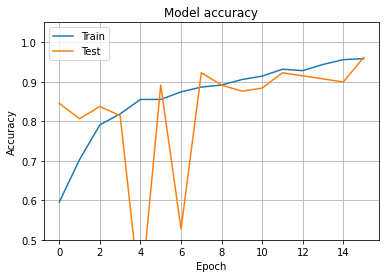

In [ ]:
plt.plot(result_list[study.best_trial.number].history["accuracy"])
plt.plot(result_list[study.best_trial.number].history["val_accuracy"])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Test"], loc="upper left")
plt.ylim(0.5, 1.05)
plt.grid()
plt.show()

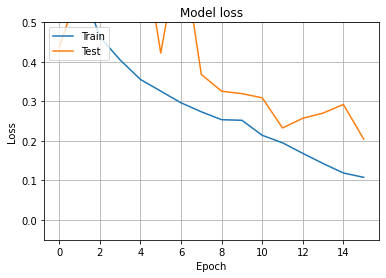

In [ ]:
plt.plot(result_list[study.best_trial.number].history["loss"])
plt.plot(result_list[study.best_trial.number].history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc="upper left")
plt.ylim(-0.05, 0.5)
plt.grid()
plt.show()

In [ ]:
model_list[study.best_trial.number].save("ohhara.h5")